## TODO
- are there fewer that are mapping to mouse orthologs?? Why no body length enrichment?? :(

# Environment set up

In [1]:
# load required packages

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import random

from IPython.display import display

import getpass
import ndex2

import json
import cdapsutil

# need ddot to parse the ontology
import ddot
from ddot import Ontology

# annotate the clusters
# gprofiler prelim annotation
from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")

from statsmodels.stats import contingency_tables

import requests

# find human orthologs of mouse genes
import mygene
mg = mygene.MyGeneInfo()

from scipy.stats import hypergeom
from scipy.stats import norm

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set(font_scale=1.4)

sns.set_style('white')

sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.rcParams['svg.fonttype'] = 'none'

import sys
from tqdm import tqdm

# % matplotlib inline

from random import randint
from matplotlib.patches import Patch

DISCLAIMIER: cdapsutil is experimental and may contain errors and interfaces may change


In [2]:
## LOAD PCNET
interactome_uuid='4de852d9-9908-11e9-bcaf-0ac135e8bacf' # for PCNet
# interactome_uuid='275bd84e-3d18-11e8-a935-0ac135e8bacf' # for STRING high confidence
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_int = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=interactome_uuid
        ).to_networkx()
nodes = list(G_int.nodes)

# pcnet appears to have some self edges... should remove them. 
G_int.remove_edges_from(nx.selfloop_edges(G_int))

# print out interactome num nodes and edges for diagnostic purposes
print('number of nodes:')
print(len(G_int.nodes))
print('\nnumber of edges:')
print(len(G_int.edges))

nodes = list(G_int.nodes)
pd.DataFrame(G_int.nodes).to_csv("pcnet_node_list.tsv", sep="\t", index=False, header=False)

number of nodes:
18820

number of edges:
2693109


In [3]:
## Load conserved network
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_overlap_cx = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid='3c980793-0115-11ec-b666-0ac135e8bacf'
        )


# print out interactome num nodes and edges for diagnostic purposes
G_overlap = G_overlap_cx.to_networkx()
print('number of nodes:')
print(len(G_overlap.nodes))
print('\nnumber of edges:')
print(len(G_overlap.edges))

number of nodes:
488

number of edges:
7272


## Get original hierarchy

In [32]:
## Get Brin's hierarchy
ndex_server='public.ndexbio.org'
USERNAME = input('NDEx user name: ')
PASSWORD = getpass.getpass('NDEx password: ')
G_hier_cx = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=USERNAME, 
            password=PASSWORD, 
            uuid='6a5d5b79-497f-11ec-b3be-0ac135e8bacf'
        )


# print out interactome num nodes and edges for diagnostic purposes
G_hier = G_hier_cx.to_networkx()
print('number of nodes:')
print(len(G_hier.nodes))
print('\nnumber of edges:')
print(len(G_hier.edges))

NDEx user name: snwright
NDEx password: ········
number of nodes:
54

number of edges:
54


In [33]:
hier_df = pd.DataFrame.from_dict(dict(G_hier.nodes(data=True)), orient="index")
hier_df_genes = hier_df.loc[:, ["CD_MemberList", "frac_d1_seeds", "frac_d2_seeds"]]

hier_df_genes.to_csv("../../Data/rat/data/final/height_hierarchy_data.tsv", sep="\t")

## Get Mouse data

In [6]:
from netcoloc import validation

In [14]:
def load_MPO(url='http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology', use_genes=True, mapping=None, restrict_to=None):
    """
    Function to parse and load mouse phenotype ontology, using DDOT's ontology module

    :param url: URL containing MPO ontology file
    :type url: str
    :return: MPO parsed using DDOT
    :rtype: :py:class:`ddot.Ontology`
    :raises ImportError: If DDOT package is not found
    """

    # download the mammalian phenotype ontology, parse with ddot
    r = requests.get(url, allow_redirects=True)
    open('MPheno_OBO.ontology', 'wb').write(r.content)
    ddot.parse_obo('MPheno_OBO.ontology',
                   'parsed_mp.txt',
                   'id2name_mp.txt',
                   'id2namespace_mp.txt',
                   'altID_mp.txt')

    MP2desc = pd.read_csv('id2name_mp.txt', sep='\t',
                          names=['MP', 'description'], index_col='MP')

    MP2desc = MP2desc.loc[MP2desc.index.dropna()]  # drop NAN from index
    print(len(MP2desc))

    #display(MP2desc.head())

    hierarchy = pd.read_table('parsed_mp.txt',
                              sep='\t',
                              header=None,
                              names=['Parent', 'Child', 'Relation', 'Namespace'])

    if use_genes:
        mouse_mapping = mapping.dropna().loc[:, ("human_ortholog", "MP")].reset_index()
        mouse_mapping = mouse_mapping.loc[:, ("human_ortholog", "MP")]
        mouse_mapping.columns = ["Gene", "Term"]
        if restrict_to is not None:
            mouse_mapping = mouse_mapping.loc[mouse_mapping.Gene.isin(restrict_to)]
        MPO = Ontology.from_table(
            table=hierarchy,
            parent='Parent',
            child='Child',
            add_root_name='MP:00SUPER',
            ignore_orphan_terms=True,
            mapping=mouse_mapping,
            mapping_parent='Term',
            mapping_child='Gene')
    else:
        #display(hierarchy.head())
        MPO = Ontology.from_table(
            table=hierarchy,
            parent='Parent',
            child='Child',
            add_root_name='MP:00SUPER',
            ignore_orphan_terms=True)

    # add description to node attribute
    terms_keep = list(np.unique(hierarchy['Parent'].tolist() + hierarchy['Child'].tolist()))
    MPO.node_attr = MP2desc.loc[terms_keep]

    return MPO

In [7]:
mgi_df = validation.load_MGI_mouseKO_data(url='http://www.informatics.jax.org/downloads/reports/MGI_PhenoGenoMP.rpt')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-24137...done.
Finished.
36 input query terms found dup hits:
	[('Adam1a', 2), ('Adam1b', 2), ('Adam5', 2), ('Ccdc39', 2), ('Chaserr', 2), ('Dnm3os', 2), ('Eldr', 
12250 input query terms found no hit:
	['+|Cav1', '+|Cm', '+|Del(10Prmt2-Pdxk)4Yey', '+|Del(11Mpo-Chad)18Brd', '+|Del(11Stat5a-Stat5b)1Mam'
Pass "re

In [8]:
MPO = validation.load_MPO(url='http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology')

14510


description
MP                                               
MP:0000001                    mammalian phenotype
MP:0000002                    obsolete Morphology
MP:0000003     abnormal adipose tissue morphology
MP:0000011     abnormal adipose tissue morphology
MP:0000005  increased brown adipose tissue amount

Parent       Child Relation        Namespace
0  MP:0005375  MP:0000003     is_a  MPheno.ontology
1  MP:0001778  MP:0000005     is_a  MPheno.ontology
2  MP:0001781  MP:0000008     is_a  MPheno.ontology
3  MP:0005334  MP:0000010     is_a  MPheno.ontology
4  MP:0000003  MP:0000013     is_a  MPheno.ontology

In [9]:
mouse_orthos = pd.read_csv("~/Data/Transfer/Data/rat/pcnet_node_list_MsOrtho.tsv", sep="\t")

In [11]:
MPO2 = load_MPO(url='http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology', use_genes=True, mapping=mgi_df,
               restrict_to = mouse_orthos.HsOrtho.values)

14510


In [15]:
MPO_full = load_MPO(url='http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology', use_genes=True, mapping=mgi_df)

14510


# Perform Enrichment

## Enrichment functions

In [12]:
def genes_per_node(MPO):
    node_order = MPO.topological_sorting(top_down=False)
    nodes = [i for i in node_order]
    results = {i: set(MPO.term_2_gene[i]) for i in node_order}
    genes = {i: set(MPO.gene_2_term[i]) for i in MPO.genes}
    while len(nodes) > 0:
        current = nodes.pop()
        children = MPO.parent_2_child[current]
        if len(children) > 0:
            for child in children:
                if child != current:
                    results[current] = results[current].union(results[child])
        for gene in results[current]:
            if gene not in genes.keys():
                genes[gene] = set([current])
            else:
                genes[gene] = genes[gene].union(set([current]))
        else:
            pass
    counts = {k: len(results[k]) for k in results.keys()}
    return counts, genes

def community_term_enrichment_full(community_name, hier_df, MPO, mgi_df, term_counts, gene_to_terms, seeds=None):
    # get the genes in the community
    genes = hier_df.loc[community_name, "CD_MemberList"]
    if type(genes) is str:  # split into a list of genes
        genes_all = genes.split(" ")
        N_hier = len(genes_all)
    genes = [ g for g in genes_all if g in MPO.genes ]  # only keep genes in the MGI ontology
    if seeds is not None:
        genes = [g for g in genes if g in seeds]
        N_hier = len([g for g in genes_all if g in seeds])
    
    if len(genes) == 0:
        print("0/"+str(len(genes_all)), "in MPO.genes/seeds")
        return pd.DataFrame()
        
    
    # Get the terms associated with these genes
    terms = []
    for gene in genes:
        terms += list(gene_to_terms[MPO.genes.index(gene)])

    # Join term totals and observed
    to_test = pd.DataFrame(pd.Series(terms, name="observed").value_counts()).join(pd.Series(term_counts, name="total"))
    M_pool_size = len(G_int.nodes())
    
    # Get odss ratio, p value of odds ratio, and 95% confidence interval
    OR_test = to_test.apply(lambda x: get_contingency_stats(x.observed, x.total, N_hier, M_pool_size), axis=1)
    try: 
        OR_test = pd.concat(list(OR_test), ignore_index=True)
    except TypeError:
        print(OR_test)
        print(N_hier, terms)
    OR_test.index = to_test.index
    to_test = pd.concat([to_test, OR_test], axis=1)
    
    to_test = to_test.assign(hyper_p=lambda z: hypergeom.sf(k=z.observed, M=M_pool_size, n=z.total, N=N_hier))
    desc = MPO.node_attr.loc[to_test.index]
    to_test = to_test.assign(sig_5e6=to_test["hyper_p"] < 5e-6)
    to_test = to_test.join(desc, how="left")
    to_test = to_test.assign(size=N_hier)
    ## TODO - should I filter some terms out? Due to too small?
    ## TODO - do OR stuff as well.
    return to_test

def get_contingency_stats(observed, term_size, community_size, network_size):
    q00 = observed
    q01 = term_size - observed
    q10 = community_size - observed
    q11 = network_size - q00 - q01 - q10
    results_table = [[q00, q01], [q10, q11]]
    #print(results_table)
    CT = contingency_tables.Table2x2(results_table)
    OR_p_temp = CT.oddsratio_pvalue()
    OR_CI_temp = CT.oddsratio_confint()
    OR = CT.oddsratio
    #print(CT.chi2_contribs)
    #return CT
    return pd.DataFrame({"OR":OR, "OR_p": OR_p_temp, "OR_CI_lower":OR_CI_temp[0], "OR_CI_upper":OR_CI_temp[1]}, index=[0])


def get_gene_hits(community_name, hier_df, term_mapping, term_query, MPO, mp_graph):
    genes = hier_df.loc[community_name, "CD_MemberList"]
    if type(genes) is str:  # split into a list of genes
        genes_all = genes.split(" ")
    term_to_include = nx.dfs_preorder_nodes(mp_graph, term_query)
    msOrthos = [1 if g in MPO.genes else 0 for g in genes_all]
    gene_hits = []
    for term in term_to_include:
        term_genes = [MPO.genes[i] for i in term_mapping[term]]
        genes_in_term = set(term_genes).intersection(set(genes_all))
        hits = [1 if g in genes_in_term else 0 for g in genes_all]
        gene_hits.append(pd.DataFrame({"gene":genes_all, "community":community_name,"MP": term, "MP_parent":term_query, "inMP": hits, 
                                       "MsOrtho":msOrthos}))
    gene_hits = pd.concat(gene_hits)
    desc = MPO.node_attr.loc[gene_hits.MP]
    gene_hits = gene_hits.assign(description=desc.values)
    return gene_hits


## Do enrichment

In [ ]:
# test number of genes with mouse orthos -> 434/488
genes = hier_df_genes.loc["C1121", "CD_MemberList"].split(" ")

In [23]:
mouse_orthos[mouse_orthos.HsOrtho.isin(genes)]

HsOrtho  MsOrtho  Homology_Score
16       AAMDC    Aamdc       73.940430
82     ABHD17A  Abhd17a       75.172035
100     ABLIM2   Ablim2       72.707890
207      ACTN4    Actn4       74.994194
210     ACTR1B   Actr1b       75.002235
...        ...      ...             ...
15306    ZFP41    Zfp41       81.056550
15316    ZFPL1    Zfpl1       75.233190
15374   ZNHIT1   Znhit1       74.232150
15390   ZRANB1   Zranb1       74.956200
15411   ZSWIM6   Zswim6       73.393560

[434 rows x 3 columns]

In [16]:
phenotypes_full = []
term_counts_full, gene_mapping_full = genes_per_node(MPO_full)
for community in tqdm(hier_df_genes.index):
    x = community_term_enrichment_full(community, hier_df_genes, MPO_full, mgi_df, term_counts_full, gene_mapping_full)
    x = x.assign(name=community)
    phenotypes_full.append(x)

 15%|█▍        | 8/54 [00:03<00:10,  4.31it/s]

0/5 in MPO.genes/seeds
0/5 in MPO.genes/seeds
0/4 in MPO.genes/seeds
0/4 in MPO.genes/seeds


 44%|████▍     | 24/54 [00:10<00:13,  2.26it/s]

0/4 in MPO.genes/seeds


 74%|███████▍  | 40/54 [00:12<00:01,  9.76it/s]

0/4 in MPO.genes/seeds


100%|██████████| 54/54 [00:14<00:00,  3.67it/s]


In [17]:
results = pd.concat(phenotypes_full)
results.head()

observed   total        OR      OR_p  OR_CI_lower  OR_CI_upper  \
MP:0000001     237.0  9120.0  1.074587  0.440382     0.895115     1.290043   
MP:0010768     140.0  4593.0  1.315818  0.007260     1.076900     1.607741   
MP:0010769     136.0  4195.0  1.424894  0.000599     1.164014     1.744242   
MP:0005378     130.0  4122.0  1.366974  0.002797     1.113637     1.677941   
MP:0005376     118.0  4166.0  1.177536  0.129447     0.953306     1.454509   

             hyper_p sig_5e6                        description   size   name  
MP:0000001  0.206551   False                mammalian phenotype  472.0  C1121  
MP:0010768  0.003514   False                    mortality/aging  472.0  C1121  
MP:0010769  0.000326   False                  abnormal survival  472.0  C1121  
MP:0005378  0.001426   False  growth/size/body region phenotype  472.0  C1121  
MP:0005376  0.059318   False   homeostasis/metabolism phenotype  472.0  C1121

In [33]:
results.loc["MP:0001256"]

observed  total         OR      OR_p  OR_CI_lower  OR_CI_upper  \
MP:0001256       8.0  259.0   1.243097  0.547990     0.611214     2.528231   
MP:0001256       5.0  259.0   2.068166  0.112553     0.842926     5.074364   
MP:0001256       2.0  259.0   1.070155  0.924463     0.263468     4.346751   
MP:0001256       1.0  259.0   1.794671  0.564249     0.245787    13.104218   
MP:0001256       1.0  259.0   3.266209  0.247909     0.438609    24.322614   
MP:0001256       1.0  259.0  10.273533  0.029602     1.259459    83.802258   
MP:0001256       1.0  259.0   8.988857  0.038754     1.120194    72.129937   
MP:0001256       1.0  259.0   8.988857  0.038754     1.120194    72.129937   

             hyper_p sig_5e6           description   size   name  
MP:0001256  0.204354   False  abnormal body length  472.0  C1121  
MP:0001256  0.038594   False  abnormal body length  180.0  C1122  
MP:0001256  0.288239   False  abnormal body length  136.0  C1123  
MP:0001256  0.109134   False  abnormal body length   41.0  C1125  
MP:0001256  0.039477   False  abnormal body length   23.0  C1128  
MP:0001256  0.005001   False  abnormal body length    8.0  C1139  
MP:0001256  0.006372   False  abnormal body length    9.0  C1136  
MP:0001256  0.006372   False  abnormal body length    9.0  C1137

In [29]:
counts = []
for g in genes:
    try:
        counts.append(len(gene_mapping_full[g]))
    except KeyError:
        counts.append(0)

In [32]:
sum([c==0 for c in counts])

237

In [36]:
np.median(counts)

0.0

## Plotting Functions

In [18]:
def plot_hierarchy_heatmap(enrichment_results,MPO, term_counts,value="hyper_p", root="MP:0000001", levels=1, min_term_size=5,
                          min_observation=1, min_percent=0):
    plot_df, mpG = _subset_results(enrichment_results, root, MPO)
    plot_df.loc[(plot_df.observed < min_observation), (value)] = 0
    plot_df["percent"] = plot_df.apply(lambda x: max(x.observed/x["size"], x.observed/x["total"]), axis=1)
    plot_df.loc[plot_df["percent"] < min_percent, ("value")] = 0
    
    all_terms = [k for k in term_counts.keys() if term_counts[k] >= min_term_size]
   
    
    fill_MP = [t for t in all_terms if t not in plot_df.MP]
    filler = pd.DataFrame({"MP":fill_MP, value:0, "name":plot_df.name[0], "size":plot_df["size"][0]}, index = [t for t in all_terms if t not in plot_df.MP])
    plot_df = pd.concat([plot_df, filler], axis=0)

    plot_df, colors, parent_map = _annotate_results(plot_df, root, mpG, levels=levels)
    
    #return plot_df
    to_plot = plot_df.pivot(columns="name", values=value)
    
    node_order = [node for node in nx.dfs_preorder_nodes(mpG, root)][1:]
    node_order = [node for node in node_order if node in plot_df.MP]
    to_plot = to_plot.loc[node_order]    
    #return to_plot, parent_map, colors
    color_list = [colors[parent_map.loc[node].parent] for node in to_plot.index]
    if levels == 2:
        color_list = [color_list, [colors[parent_map.loc[node].parent2] for node in to_plot.index]]
        assert len(to_plot) == len(color_list[0])
    else:
        assert len(to_plot) == len(color_list)
    x = sns.color_palette('flare', as_cmap=True)
    community_sizes = plot_df.loc[:, ("size", "name")].reset_index(drop=True).drop_duplicates()
    community_sizes.index=community_sizes["name"]
    community_sizes = community_sizes.loc[:,"size" ].to_dict()
    col_colors=[x(community_sizes[c]/max(plot_df["size"])) for c in to_plot.columns]

   #col_colors = {results.name.unique()[i]: color[i] for i range[n]}
    sns.clustermap(to_plot.fillna(0), xticklabels=True, yticklabels=False, cmap='viridis_r',
                  row_cluster=False, col_cluster=True, row_colors=color_list, col_colors=col_colors)
    handles = [Patch(facecolor=colors[node]) for node in plot_df.parent.unique()]
    
    print("handles", len(handles))
    if levels == 1:
        cmap1 = {MPO.node_attr.loc[node, "description"]: colors[node] for node in plot_df.parent.unique()}
        plt.legend(handles, cmap1, title="Mammalian Phenotypes")
    elif levels == 2:
        all_parents = list(plot_df.parent.unique()) + list(plot_df.sub_parent.unique())
        handles2 = [Patch(facecolor=colors[node]) for node in all_parents]
        cmap2 = {MPO.node_attr.loc[node, "description"]: colors[node] for node in all_parents}
        plt.legend(handles2, cmap2, title="Mammalian Phenotypes", loc="right")
        
    plot_df.loc[plot_df.MP.isin(fill_MP), ("name")] = 'fill'
    return plot_df, mpG, colors, parent_map


def plot_specific_community(plot_df, mpG, community, root, colors,MPO, parent_map, value="log10P"):
    all_MP = plot_df.MP.unique()
    plot_df["expected"] = plot_df.apply(lambda x: x["total"] * x["size"] / 18820 , axis=1)
    #return plot_df
    plot_subset = plot_df.loc[((plot_df.name == community) & (plot_df.expected > 1))]
    #return plot_subset
    filler_mp = [mp for mp in all_MP if mp not in plot_subset.MP]
    filler = pd.DataFrame({"MP":filler_mp, value:0, "size":plot_df["size"][0]}, index = [t for t in filler_mp])
    plot_subset = pd.concat([plot_subset, filler], axis=0)
    node_order = [node for node in nx.dfs_preorder_nodes(mpG, root)][1:]
    node_order = [node for node in node_order if node in plot_df.MP]
    plot_subset = plot_subset.loc[node_order]
    plot_subset["parents"] = [parent_map.loc[node].parent for node in plot_subset.index]
    plot_subset["number"] = [i for i in range(len(plot_subset))][::-1]
    #plt.scatter(x=plot_subset.number, y = plot_subset.log10P)
    cmap = {MPO.node_attr.loc[node, "description"]: colors[node] for node in colors.keys()}
    plot_subset["description"] = [MPO.node_attr.loc[node, "description"] for node in plot_subset.parents]
    g = sns.lmplot(y='number', x=value, data=plot_subset, hue='description', fit_reg=False, palette=cmap, height=11)
    g.set(yticks=[], ylabel="", title=community)
    return plot_subset
    
    
def plot_sum_of_nodes(plot_df, mpG, root, colors, MPO, parent_map, cutoff=0.01):
    plot_df["keep"] = a.hyper_p.apply(lambda x: 1 if x < cutoff else 0)
    node_counts = plot_df.groupby("MP").keep.sum()
    to_plot = pd.concat([node_counts, parent_map], axis=1)
    node_order = [node for node in nx.dfs_preorder_nodes(mpG, root)][1:]
    node_order = [node for node in node_order if node in to_plot.child]
    to_plot = to_plot.loc[node_order]
    to_plot["parents"] = [parent_map.loc[node].parent for node in to_plot.index]
    to_plot["number"] = [i for i in range(len(to_plot))][::-1]
    cmap = {MPO.node_attr.loc[node, "description"]: colors[node] for node in colors.keys()}
    to_plot["description"] = [MPO.node_attr.loc[node, "description"] for node in to_plot.parents]
    to_plot["number"] = [i for i in range(len(to_plot))][::-1]
    g = sns.lmplot(data=to_plot, x="keep", y="number", height=11, aspect=0.5, fit_reg=False, hue='description', palette=cmap)
    g.set(yticks=[], ylabel="", title="<"+str(cutoff))
    

def _subset_results(results, root, MPO, min_term_size=5):
    mp_graph = _get_mp_graph()
    results = results.assign(MP=results.index)
    results = results.loc[results.MP != root]
    include_nodes = [node for node in nx.dfs_preorder_nodes(mp_graph, root) if node in results.MP]
    results_subset = results.assign(MP=results.index)
    results_subset = results.assign(log10P=lambda x: -1 * np.log10(x.hyper_p + 1e-10))
    results_subset = results_subset.loc[results.MP.isin(include_nodes)]
    results_subset = results_subset.loc[results_subset.total >= min_term_size]
    return results_subset, mp_graph


def _get_mp_graph(datafile="parsed_mp.txt"):
    mp_data = pd.read_csv(datafile, sep="\t", header=None)
    mp_data.head()
    mp_graph = nx.from_pandas_edgelist(mp_data, 0,1, create_using=nx.DiGraph)
    return mp_graph


def _annotate_results(results_subset, root, mp_graph, levels=1):
    parents = [node for node in nx.dfs_preorder_nodes(mp_graph, root, 1)][1:]
    # color map
    color = []
    color_map = {}
    n = len(parents)
    for i, parent in enumerate(parents):
        color.append('#%06X' % randint(0, 0xFFFFFF))
        color_map[parent] = color[i]
        
    # parent map
    parent_map = []
    for parent in parents:
        
        if levels == 2:
            children = [node for node in nx.dfs_preorder_nodes(mp_graph, parent, 1)][1:]
            for sub_parent in children:
                color_map[sub_parent] = '#%06X' % randint(0, 0xFFFFFF)
                sub_children = [node for node in nx.dfs_preorder_nodes(mp_graph, sub_parent)]
                parent_map.append(pd.DataFrame({"child":sub_children, "parent":parent, "parent2": sub_parent}))
        else:
            children = [node for node in nx.dfs_preorder_nodes(mp_graph, parent)][1:]
            parent_map.append(pd.DataFrame({"child":children, "parent":parent}))
    parent_map = pd.concat(parent_map)
    parent_map = parent_map.drop_duplicates(subset="child")
    parent_map.index = parent_map.child
    # add parent to results
    
    results_subset = results_subset.loc[results_subset.MP.isin(parent_map.index)]
    results_subset.loc[:, "parent"] = results_subset.MP.apply(lambda x: parent_map.loc[x].parent if x not in parents else x)
    #return results_subset, parent_map
    if levels == 2:
        results_subset.loc[:, "sub_parent"] = results_subset.MP.apply(lambda x: parent_map.loc[x].parent2)
        results_subset = results_subset.sort_values(by=["parent", "sub_parent"])
    else:
        results_subset = results_subset.sort_values(by=["parent"]) 
    return results_subset, color_map, parent_map

## Enrichment Results
TODO
* name the communities
* enforce a minimum percent of community e.g. 10% so must be 8/80?

In [19]:
mp_graph = _get_mp_graph()
root="MP:0000001"

### Top-level data

In [26]:
def plot_CIs(results, root, mp_graph=mp_graph, use_node="C877"):
    top_level = nx.dfs_preorder_nodes(mp_graph, root, 1)
    exclude=[root, "MP:0002873", "MP:0003012"] # mammalian phenotype, normal phenotype, no_phenotypic analysis
    top_level = [node for node in top_level if (node not in exclude) and (node in results.loc[results.name==use_node].index)]
    to_plot= results.loc[results.name==use_node].loc[top_level].sort_values(by="OR_CI_lower")
    plt.figure(figsize=[7,len(to_plot)/2])
    ax = plt.scatter(to_plot.OR, [i for i in range(len(to_plot))])
    plt.hlines([i for i in range(len(to_plot))], to_plot.OR_CI_lower, to_plot.OR_CI_upper)
    plt.vlines(1.0, -1, len(to_plot), linestyles='dashed', colors='black')
    ylabels = [to_plot.loc[node, "description"] + " (N=" + str(int(to_plot.loc[node, "total"]))+")" for node in to_plot.index]
    
    a=plt.yticks(ticks=[i for i in range(len(to_plot))], labels=ylabels)
    if max(to_plot.OR_CI_upper) > 5:
        plt.xscale('log')    
    plt.xlabel("Odds ratio with 95% confidence interval")
    desc = results.loc[root, "description"].unique()[0]
    plt.title(use_node + " Enrichment for " + desc+"s")
    print("Significant traits:\n", to_plot.loc[(to_plot["OR_p"] < 0.05), ("description", "OR_p")])
    return to_plot
    
    
def plot_specific_CIs(results, mp_list, n_test, mp_graph=mp_graph, use_node="C877", sort=False):
    top_level = [node for node in mp_list if (node in results.loc[results.name==use_node].index)]
    to_plot= results.loc[results.name==use_node].loc[top_level]
    colors = ["blue" for _ in range(n_test)] + ["orange" for _ in range(len(top_level)-n_test)]
    to_plot["c"] = colors
    if sort:
        to_plot = to_plot.sort_values(by="OR_CI_lower")
    plt.figure(figsize=[7,len(to_plot)/3+0.1])
    
    ax = plt.scatter(to_plot.OR, [i for i in range(len(to_plot))], c=to_plot["c"], alpha=0.7)
    plt.hlines([i for i in range(len(to_plot))], to_plot.OR_CI_lower, to_plot.OR_CI_upper, colors=to_plot["c"], alpha=0.7)
    plt.vlines(1.0, -1, len(to_plot), linestyles='dashed', colors='black')
    ylabels = [to_plot.loc[node, "description"] + " (N=" + str(int(to_plot.loc[node, "total"]))+")" for node in to_plot.index]
    ylabels = [desc.split("abnormal ")[1] if ("abnormal" in desc) else desc for desc in ylabels]
    a=plt.yticks(ticks=[i for i in range(len(to_plot))], labels=ylabels)
    if max(to_plot.OR_CI_upper) > 5:
        plt.xscale('log')    
    plt.xlabel("Odds ratio with 95% confidence interval")
    try:
        desc = results.loc[root, "description"].unique()[0]
    except AttributeError:
        desc = results.loc[root, "description"]
    plt.title("Enrichment for " + desc+"s")
    return to_plot

Significant traits:
                                   description      OR_p
MP:0010768                    mortality/aging  0.007260
MP:0005378  growth/size/body region phenotype  0.002797


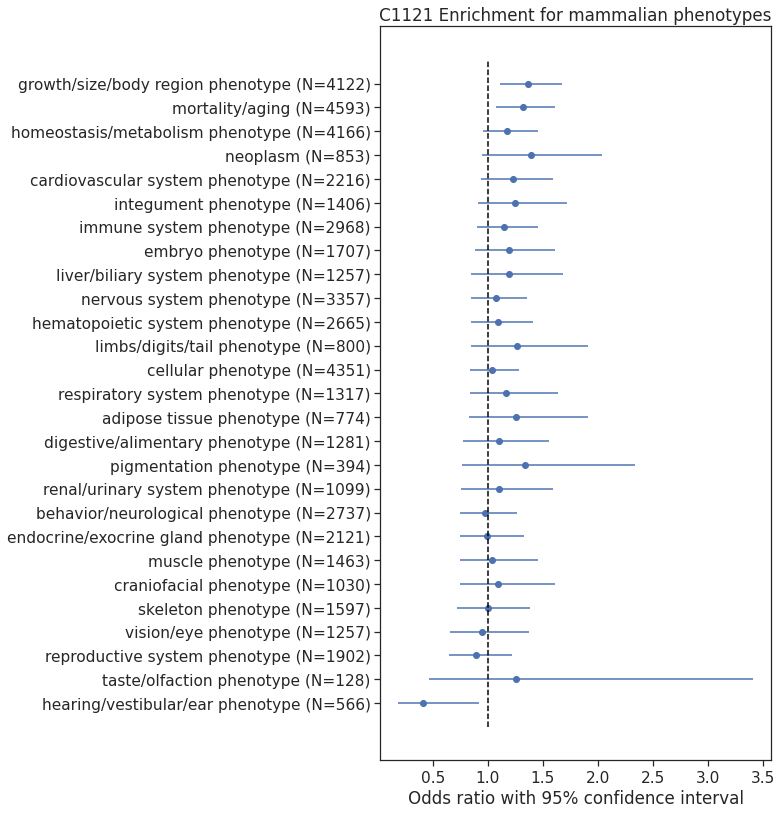

In [21]:
_ = plot_CIs(results, "MP:0000001", use_node="C1121")

Significant traits:
                                           description      OR_p
MP:0004196  abnormal prenatal growth/weight/body size  0.046047


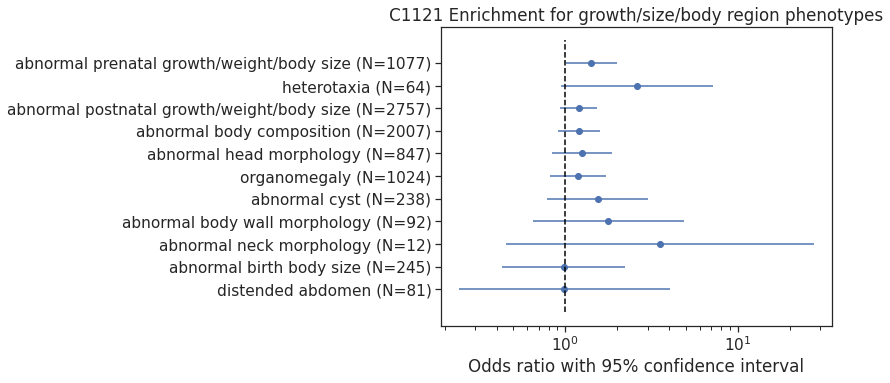

In [27]:
_ = plot_CIs(results, "MP:0005378", use_node="C1121")

Significant traits:
 Empty DataFrame
Columns: [description, OR_p]
Index: []


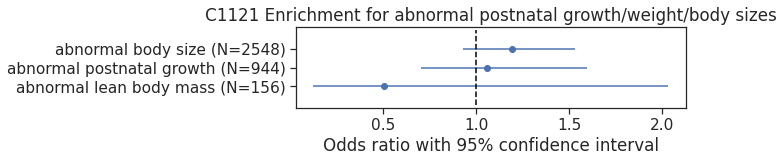

In [28]:
_ = plot_CIs(results, "MP:0002089", use_node="C1121")

Significant traits:
                                            description      OR_p
MP:0002088  abnormal embryonic growth/weight/body size  0.025695
MP:0010865                 prenatal growth retardation  0.020458


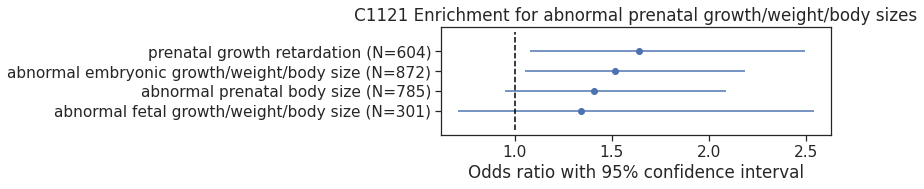

In [29]:
_ = plot_CIs(results, "MP:0004196", use_node="C1121")

Significant traits:
 Empty DataFrame
Columns: [description, OR_p]
Index: []


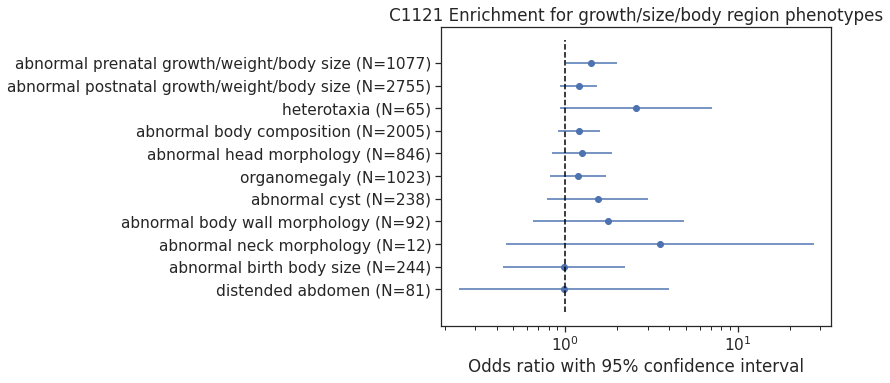

In [25]:
_ = plot_CIs(results, "MP:0005378", use_node="C1121")

In [1]:
_ = plot_CIs(results, "MP:0004016", use_node="C1121")

NameError: name 'plot_CIs' is not defined

Significant traits:
 Empty DataFrame
Columns: [description, OR_p]
Index: []


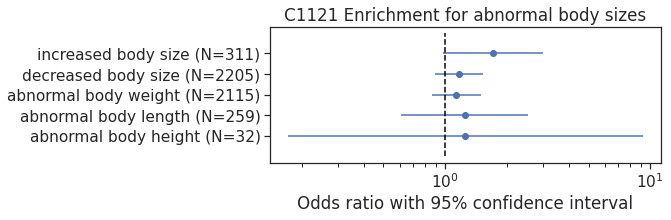

In [43]:
_ = plot_CIs(results, "MP:0003956", use_node="C1121")

Significant traits:
                   description      OR_p
MP:0010769  abnormal survival  0.000579


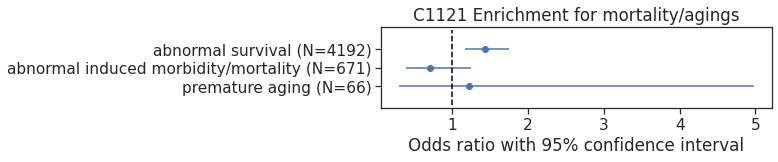

In [27]:
_ = plot_CIs(results, "MP:0010768", use_node="C1121")

Significant traits:
                      description      OR_p
MP:0010770  preweaning lethality  0.004335


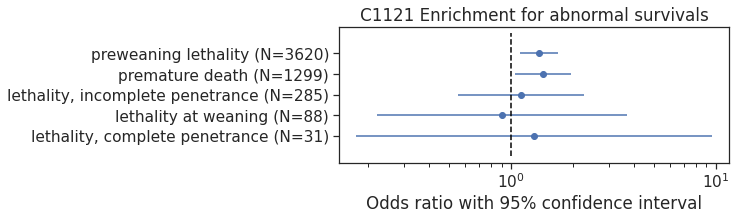

In [29]:
_ = plot_CIs(results, "MP:0010769", use_node="C1121")

### C1122 - lipoprotein lipase activity

Significant traits:
                                   description      OR_p
MP:0005382             craniofacial phenotype  0.008196
MP:0005381     digestive/alimentary phenotype  0.004393
MP:0003631           nervous system phenotype  0.001097
MP:0005371        limbs/digits/tail phenotype  0.002493
MP:0010768                    mortality/aging  0.000146
MP:0010771               integument phenotype  0.000474
MP:0005388       respiratory system phenotype  0.000385
MP:0005378  growth/size/body region phenotype  0.000027
MP:0005375           adipose tissue phenotype  0.000454
MP:0005385    cardiovascular system phenotype  0.000020


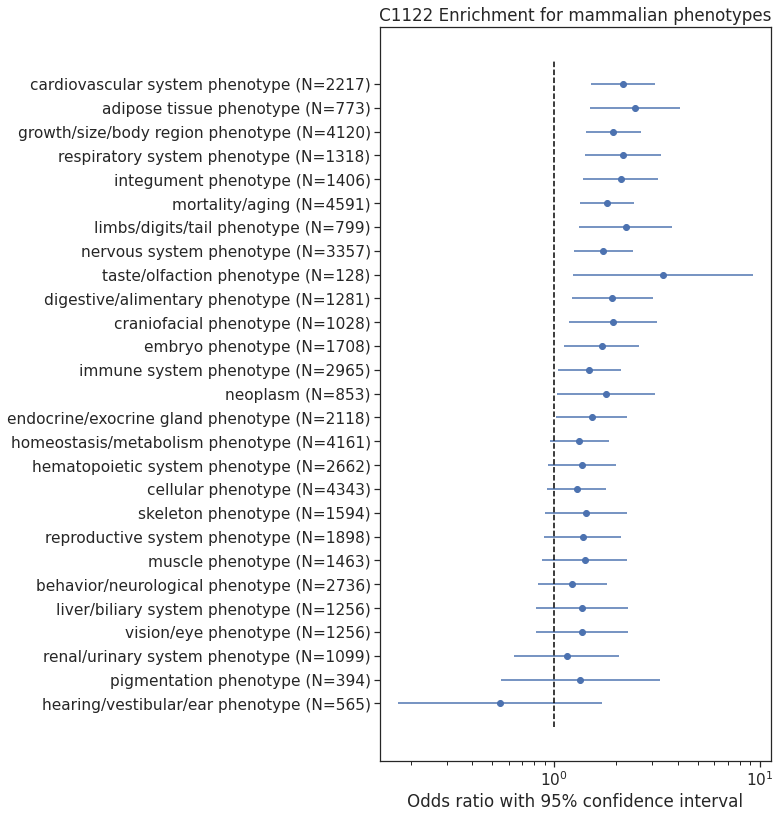

In [46]:
_ =plot_CIs(results, "MP:0000001", use_node="C1122")

Significant traits:
                                            description      OR_p
MP:0005278            abnormal cholesterol homeostasis  0.001849
MP:0003692                                    xanthoma  0.005693
MP:0002323  decreased susceptibility to hyperlipidemia  0.001277


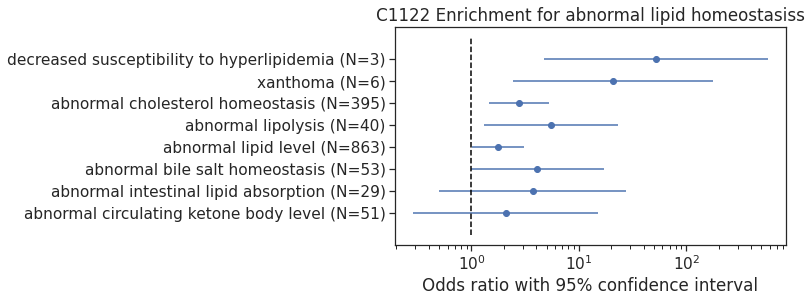

In [47]:
_ =plot_CIs(results, "MP:0002118", use_node="C1122")

#### Size

Significant traits:
                                            description      OR_p
MP:0005451                   abnormal body composition  0.009372
MP:0002089  abnormal postnatal growth/weight/body size  0.004225
MP:0000432                    abnormal head morphology  0.001717
MP:0004196   abnormal prenatal growth/weight/body size  0.000770
MP:0004133                                 heterotaxia  0.006395


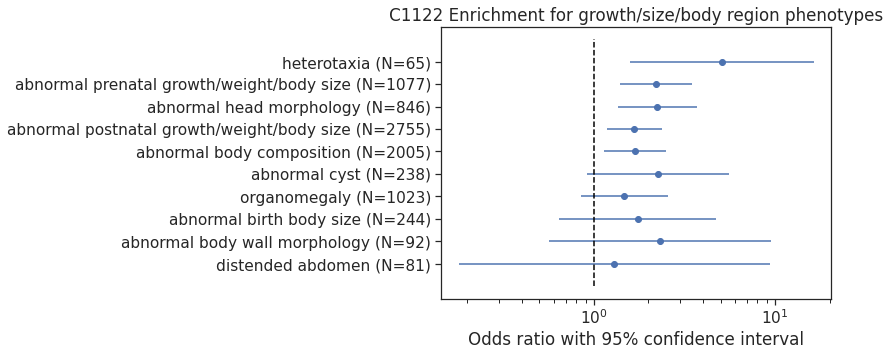

In [38]:
_ =plot_CIs(results, "MP:0005378", use_node="C1122")

Significant traits:
                                            description      OR_p
MP:0010865                 prenatal growth retardation  0.009898
MP:0002088  abnormal embryonic growth/weight/body size  0.000826
MP:0010866                 abnormal prenatal body size  0.000575


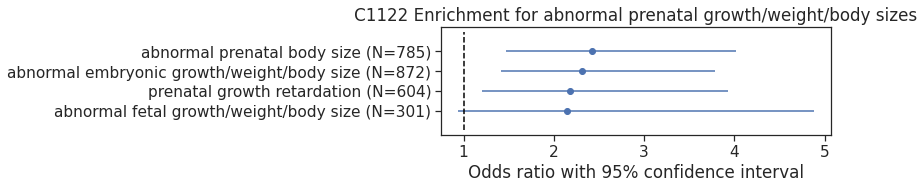

In [40]:
_ =plot_CIs(results, "MP:0004196", use_node="C1122")

Significant traits:
                    description     OR_p
MP:0003956  abnormal body size  0.00613


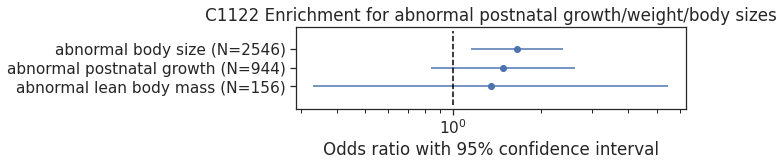

In [41]:
_ =plot_CIs(results, "MP:0002089", use_node="C1122")

Significant traits:
                     description      OR_p
MP:0001264  increased body size  0.004723


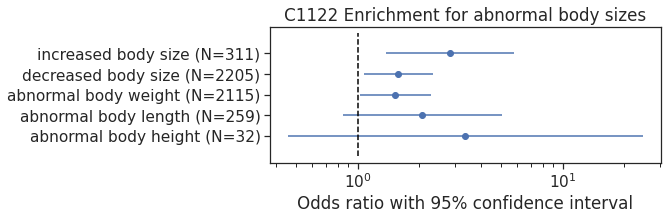

In [42]:
_ =plot_CIs(results, "MP:0003956", use_node="C1122")

Significant traits:
                       description      OR_p
MP:0001260  increased body weight  0.003639
MP:0001257  increased body length  0.008178


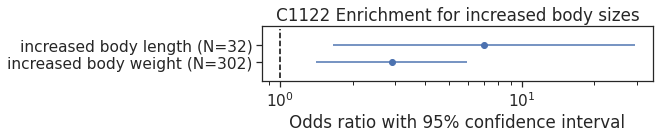

In [44]:
_ =plot_CIs(results, "MP:0001264", use_node="C1122")

Significant traits:
 Empty DataFrame
Columns: [description, OR_p]
Index: []


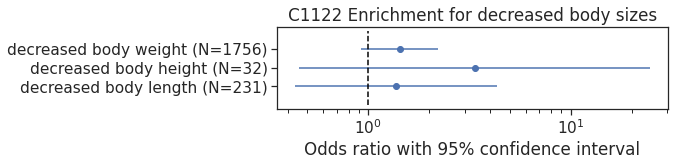

In [45]:
_ =plot_CIs(results, "MP:0001265", use_node="C1122")

#### cardio

Significant traits:
                                           description      OR_p
MP:0002127  abnormal cardiovascular system morphology  0.000025


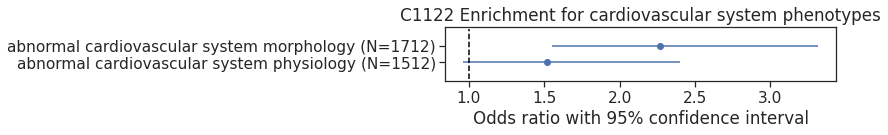

In [36]:
_ =plot_CIs(results, "MP:0005385", use_node="C1122")

Significant traits:
                                     description          OR_p
MP:0001614     abnormal blood vessel morphology  3.223645e-05
MP:0000266            abnormal heart morphology  2.437334e-05
MP:0002925  abnormal cardiovascular development  4.717844e-08


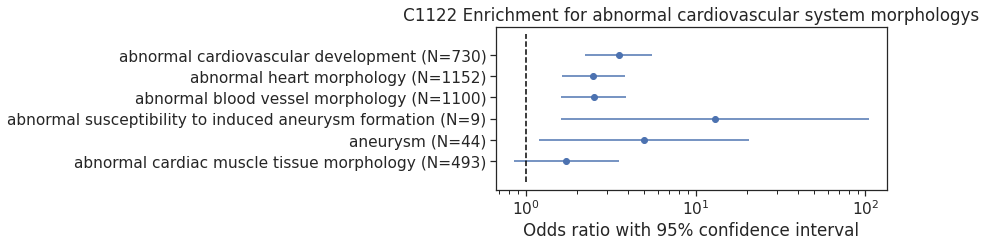

In [37]:
_ =plot_CIs(results, "MP:0002127", use_node="C1122")

#### adipose

Significant traits:
                                    description      OR_p
MP:0000003  abnormal adipose tissue morphology  0.000283


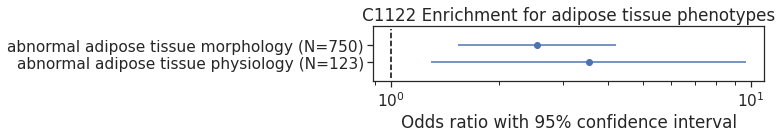

In [46]:
_ =plot_CIs(results, "MP:0005375", use_node="C1122")

Significant traits:
                                                description      OR_p
MP:0002971        abnormal brown adipose tissue morphology  0.005044
MP:0012320                          abnormal body fat mass  0.005902
MP:0005334                     abnormal fat pad morphology  0.000099
MP:0030007  abnormal bone marrow adipose tissue morphology  0.003631


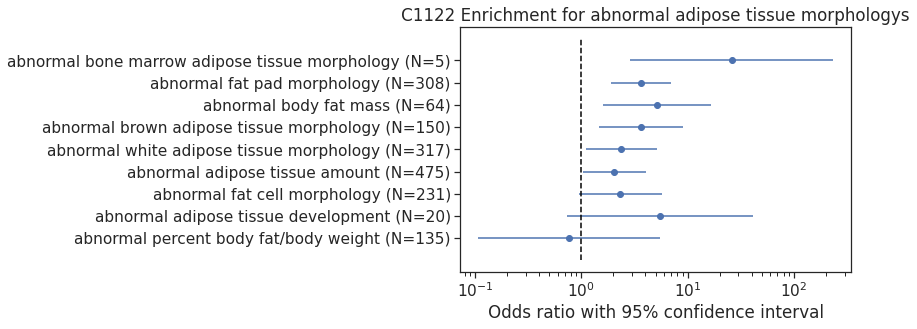

In [47]:
_ =plot_CIs(results, "MP:0000003", use_node="C1122")

#### Respiratory

Significant traits:
                                        description      OR_p
MP:0002132  abnormal respiratory system morphology  0.000043


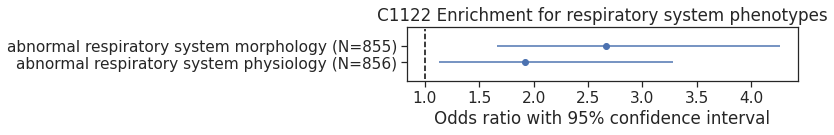

In [48]:
_ =plot_CIs(results, "MP:0005388", use_node="C1122")

Significant traits:
                          description      OR_p
MP:0001175  abnormal lung morphology  0.000003


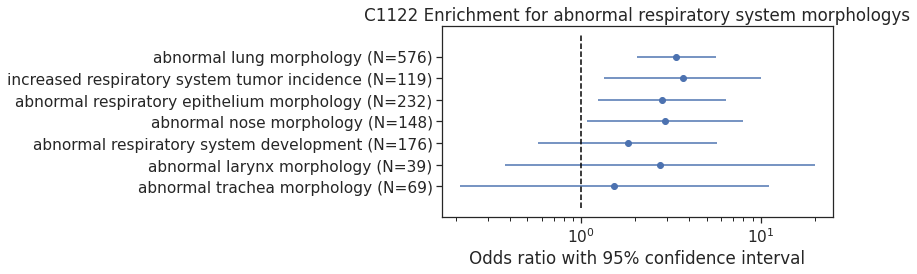

In [49]:
_ =plot_CIs(results, "MP:0002132", use_node="C1122")

### ?????C1124 - mitochondrion organization - why so few????


Significant traits:
 Empty DataFrame
Columns: [description, OR_p]
Index: []


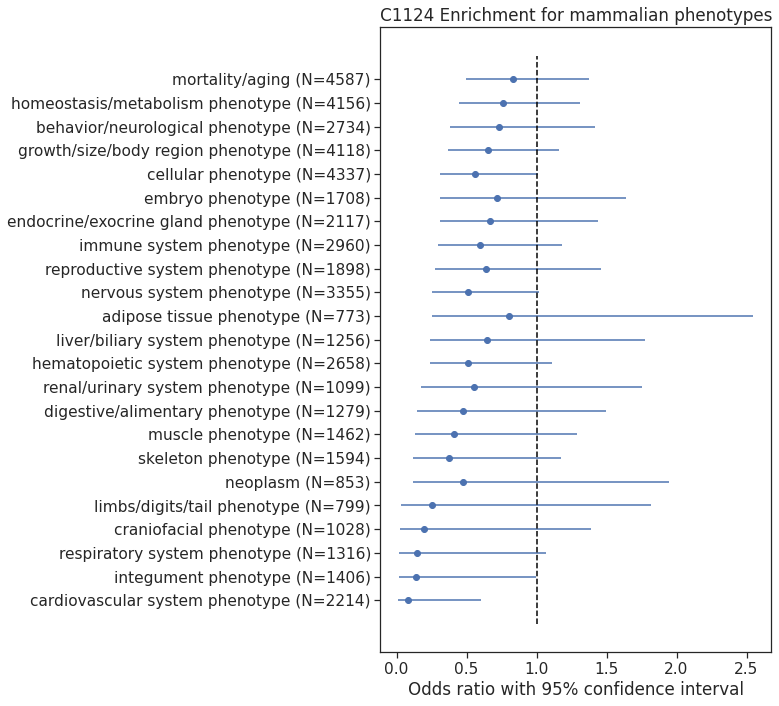

In [52]:
a = plot_CIs(results, "MP:0000001", use_node="C1124")

observed   total        OR      OR_p  OR_CI_lower  OR_CI_upper  \
MP:0005385       1.0  2214.0  0.083861  0.013733     0.011678     0.602208   
MP:0010771       1.0  1406.0  0.138550  0.049442     0.019289     0.995182   
MP:0005388       1.0  1316.0  0.148802  0.058257     0.020715     1.068868   
MP:0005382       1.0  1028.0  0.193681  0.102770     0.026958     1.391530   
MP:0005371       1.0   799.0  0.252485  0.171359     0.035133     1.814512   

             hyper_p sig_5e6                      description  size   name  
MP:0005385  0.999837   False  cardiovascular system phenotype  90.0  C1124  
MP:0010771  0.992468   False             integument phenotype  90.0  C1124  
MP:0005388  0.988734   False     respiratory system phenotype  90.0  C1124  
MP:0005382  0.960796   False           craniofacial phenotype  90.0  C1124  
MP:0005371  0.899983   False      limbs/digits/tail phenotype  90.0  C1124

### C1129 - sphingolipid biosynthetic process - again very few...

Significant traits:
 Empty DataFrame
Columns: [description, OR_p]
Index: []


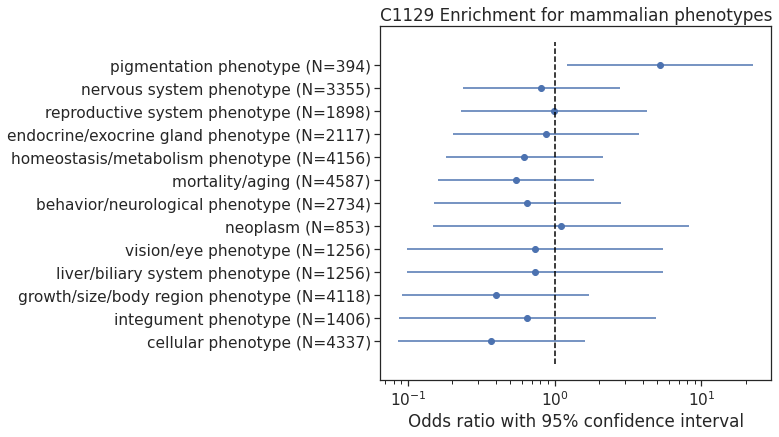

In [55]:
a = plot_CIs(results, "MP:0000001", use_node="C1129")

### C1125 - histone demethylation

Significant traits:
                                    description      OR_p
MP:0005380                    embryo phenotype  0.005988
MP:0005379  endocrine/exocrine gland phenotype  0.002553
MP:0003631            nervous system phenotype  0.000186
MP:0010768                     mortality/aging  0.000012


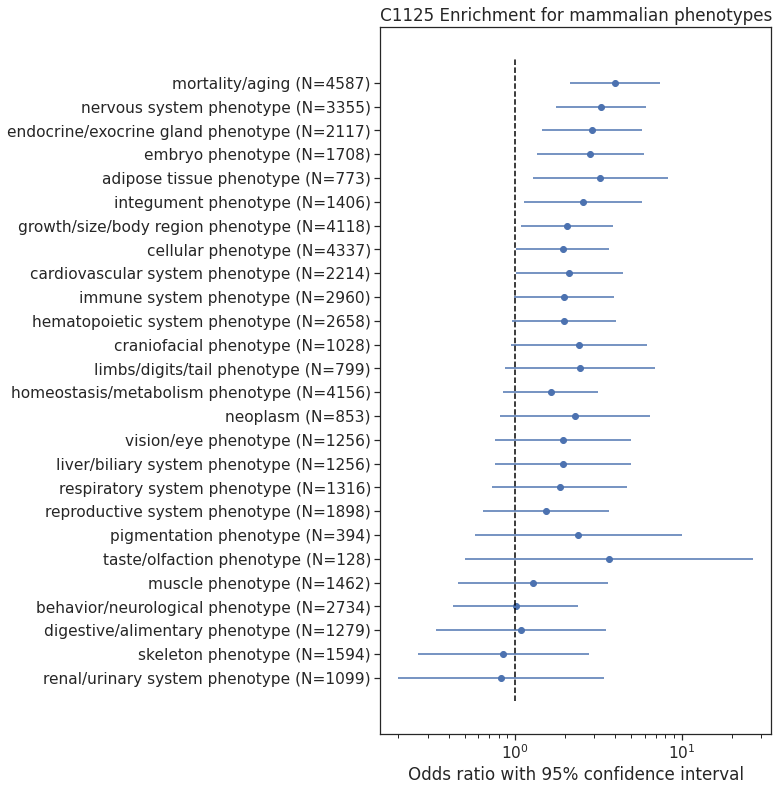

In [59]:
_ = plot_CIs(results, "MP:0000001", use_node="C1125")

#### body size

Significant traits:
                                           description      OR_p
MP:0004196  abnormal prenatal growth/weight/body size  0.000437


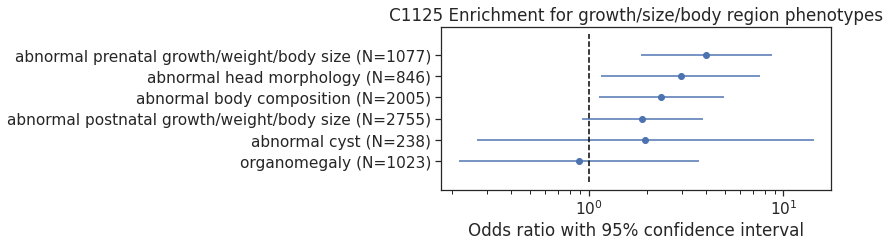

In [60]:
_ = plot_CIs(results, "MP:0005378", use_node="C1125")

Significant traits:
                                            description      OR_p
MP:0002088  abnormal embryonic growth/weight/body size  0.004291
MP:0010865                 prenatal growth retardation  0.002671
MP:0010866                 abnormal prenatal body size  0.000179


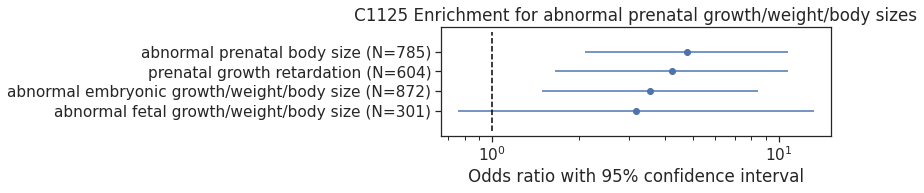

In [61]:
_ = plot_CIs(results, "MP:0004196", use_node="C1125")

Significant traits:
 Empty DataFrame
Columns: [description, OR_p]
Index: []


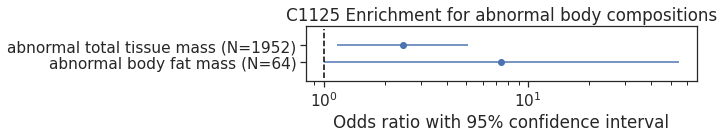

In [63]:
_ = plot_CIs(results, "MP:0005451", use_node="C1125")

Significant traits:
 Empty DataFrame
Columns: [description, OR_p]
Index: []


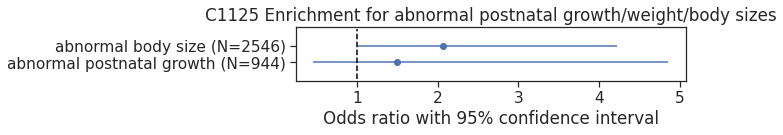

In [64]:
_ = plot_CIs(results, "MP:0002089", use_node="C1125")

Significant traits:
                      description      OR_p
MP:0001253  abnormal body height  0.008258


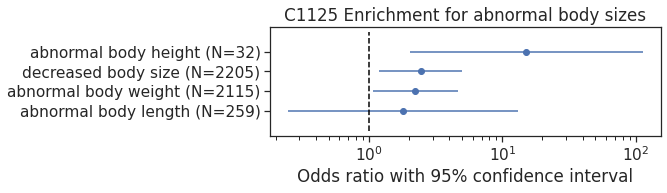

In [65]:
_ = plot_CIs(results, "MP:0003956", use_node="C1125")

#### Mortality/Aging

Significant traits:
                   description      OR_p
MP:0010769  abnormal survival  0.000032


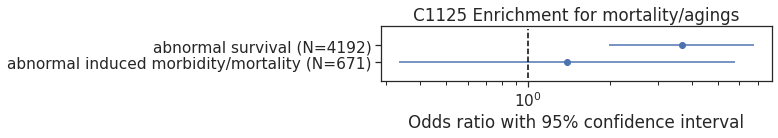

In [66]:
_ = plot_CIs(results, "MP:0010768", use_node="C1125")

Significant traits:
                                description      OR_p
MP:0011400  lethality, complete penetrance  0.007542
MP:0010770            preweaning lethality  0.000009


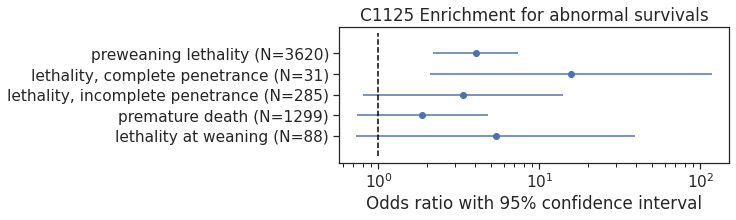

In [67]:
_ = plot_CIs(results, "MP:0010769", use_node="C1125")

#### nervous system

Significant traits:
                                    description      OR_p
MP:0003632  abnormal nervous system morphology  0.000006


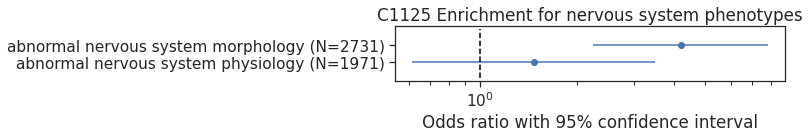

In [68]:
_ = plot_CIs(results, "MP:0003631", use_node="C1125")

Significant traits:
                                     description      OR_p
MP:0003861  abnormal nervous system development  0.006110
MP:0002882           abnormal neuron morphology  0.003517
MP:0002152            abnormal brain morphology  0.000853
MP:0003634       abnormal glial cell morphology  0.002717


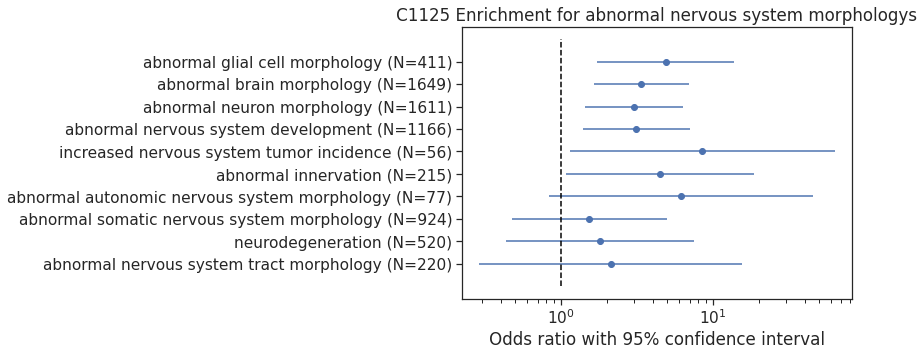

In [70]:
_ = plot_CIs(results, "MP:0003632", use_node="C1125")

#### endo/exocrine

Significant traits:
                           description      OR_p
MP:0002163  abnormal gland morphology  0.000908


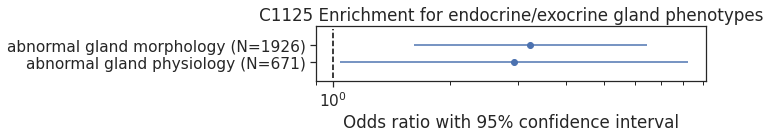

In [71]:
_ = plot_CIs(results, "MP:0005379", use_node="C1125")

Significant traits:
                                 description      OR_p
MP:0010288  increased gland tumor incidence  0.001723


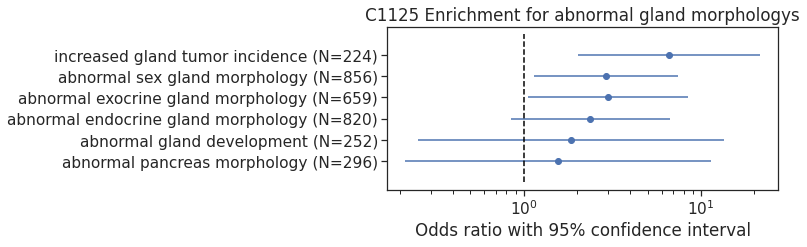

In [72]:
_ = plot_CIs(results, "MP:0002163", use_node="C1125")

### C1127 - elastic fiber

Significant traits:
 Empty DataFrame
Columns: [description, OR_p]
Index: []


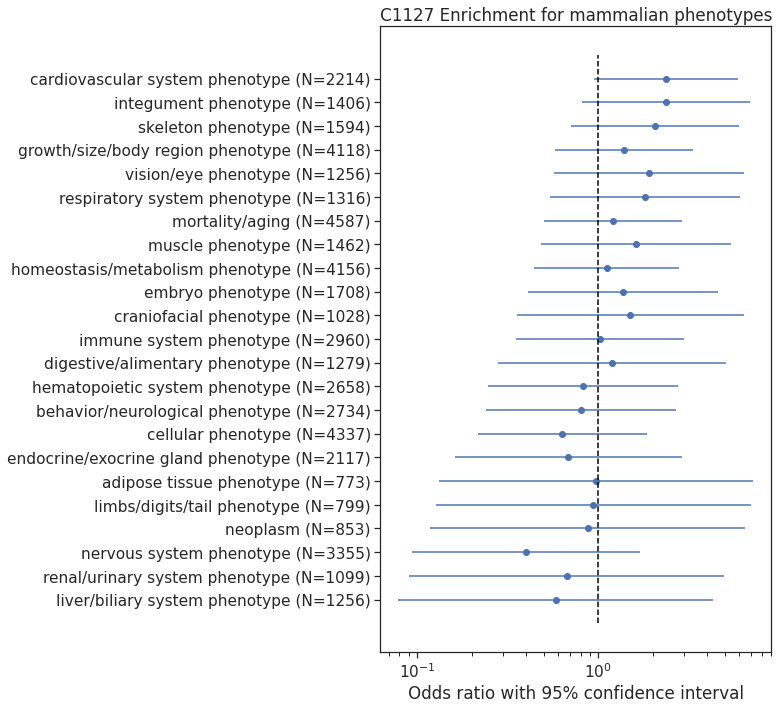

In [74]:
_ = plot_CIs(results, "MP:0000001", use_node="C1127")

# Old version (full sizes)

In [168]:
def genes_per_node(MPO):
    node_order = MPO.topological_sorting(top_down=False)
    nodes = [i for i in node_order]
    results = {i: set(MPO.term_2_gene[i]) for i in node_order}
    genes = {i: set(MPO.gene_2_term[i]) for i in MPO.genes}
    while len(nodes) > 0:
        current = nodes.pop()
        children = MPO.parent_2_child[current]
        if len(children) > 0:
            for child in children:
                if child != current:
                    results[current] = results[current].union(results[child])
        for gene in results[current]:
            if gene not in genes.keys():
                genes[gene] = set([current])
            else:
                genes[gene] = genes[gene].union(set([current]))
        else:
            pass
    counts = {k: len(results[k]) for k in results.keys()}
    return counts, genes

def community_term_enrichment_full(community_name, hier_df, MPO, mgi_df, term_counts, gene_to_terms, seeds=None):
    # get the genes in the community
    genes = hier_df.loc[community_name, "CD_MemberList"]
    if type(genes) is str:  # split into a list of genes
        genes_all = genes.split(" ")
        N_hier = len(genes_all)
    genes = [ g for g in genes_all if g in MPO.genes ]  # only keep genes in the MGI ontology
    if seeds is not None:
        genes = [g for g in genes if g in seeds]
        N_hier = len([g for g in genes_all if g in seeds])
    
    if len(genes) == 0:
        print("0/"+str(len(genes_all)), "in MPO.genes/seeds")
        return pd.DataFrame()
        
    
    # Get the terms associated with these genes
    terms = []
    for gene in genes:
        terms += list(gene_to_terms[MPO.genes.index(gene)])

    # Join term totals and observed
    to_test = pd.DataFrame(pd.Series(terms, name="observed").value_counts()).join(pd.Series(term_counts, name="total"))
    M_pool_size = len(G_int.nodes())
    
    # Get odss ratio, p value of odds ratio, and 95% confidence interval
    OR_test = to_test.apply(lambda x: get_contingency_stats(x.observed, x.total, N_hier, M_pool_size), axis=1)
    try: 
        OR_test = pd.concat(list(OR_test), ignore_index=True)
    except TypeError:
        print(OR_test)
        print(N_hier, terms)
    OR_test.index = to_test.index
    to_test = pd.concat([to_test, OR_test], axis=1)
    
    to_test = to_test.assign(hyper_p=lambda z: hypergeom.sf(k=z.observed, M=M_pool_size, n=z.total, N=N_hier))
    desc = MPO.node_attr.loc[to_test.index]
    to_test = to_test.assign(sig_5e6=to_test["hyper_p"] < 5e-6)
    to_test = to_test.join(desc, how="left")
    to_test = to_test.assign(size=N_hier)
    ## TODO - should I filter some terms out? Due to too small?
    ## TODO - do OR stuff as well.
    return to_test

In [27]:
phenotypes_old = []
term_counts_old, gene_mapping_old = genes_per_node(MPO_old)
for community in tqdm(hier_df_genes.index):
    x = community_term_enrichment_old(community, hier_df_genes, MPO_old, mgi_df, term_counts_old, gene_mapping_old)
    x = x.assign(name=community)
    phenotypes_old.append(x)

  0%|          | 0/61 [00:00<?, ?it/s]

[[359, 8740], [283, 9438]]
[[194, 4393], [448, 13785]]
[[184, 4008], [458, 14170]]
[[182, 4155], [460, 14023]]
[[171, 3947], [471, 14231]]
[[171, 3449], [471, 14729]]
[[167, 3188], [475, 14990]]
[[160, 3996], [482, 14182]]
[[159, 3727], [483, 14451]]
[[130, 2604], [512, 15574]]
[[130, 2604], [512, 15574]]
[[129, 3282], [513, 14896]]
[[125, 2606], [517, 15572]]
[[118, 2637], [524, 15541]]
[[113, 2433], [529, 15745]]
[[109, 2135], [533, 16043]]
[[108, 1863], [534, 16315]]
[[102, 2153], [540, 16025]]
[[98, 2116], [544, 16062]]
[[97, 2863], [545, 15315]]
[[92, 2113], [550, 16065]]
[[90, 2201], [552, 15977]]
[[89, 2569], [553, 15609]]
[[87, 2030], [555, 16148]]
[[87, 1807], [555, 16371]]
[[87, 2028], [555, 16150]]
[[84, 1527], [558, 16651]]
[[82, 1844], [560, 16334]]
[[81, 1924], [561, 16254]]
[[81, 1817], [561, 16361]]
[[81, 1619], [561, 16559]]
[[81, 1614], [561, 16564]]
[[80, 1569], [562, 16609]]
[[78, 1874], [564, 16304]]
[[76, 1518], [566, 16660]]
[[74, 1638], [568, 16540]]
[[73, 1424]

  2%|▏         | 1/61 [00:03<03:40,  3.68s/it]

[[6, 9093], [5, 9716]]
[[3, 4115], [8, 14694]]
[[3, 2752], [8, 16057]]
[[3, 2112], [8, 16697]]
[[3, 1949], [8, 16860]]
[[3, 2543], [8, 16266]]
[[3, 2002], [8, 16807]]
[[2, 1892], [9, 16917]]
[[2, 2732], [9, 16077]]
[[2, 300], [9, 18509]]
[[2, 2212], [9, 16597]]
[[2, 1346], [9, 17463]]
[[2, 1693], [9, 17116]]
[[2, 1698], [9, 17111]]
[[2, 1510], [9, 17299]]
[[2, 300], [9, 18509]]
[[2, 1441], [9, 17368]]
[[2, 309], [9, 18500]]
[[2, 986], [9, 17823]]
[[2, 952], [9, 17857]]
[[2, 3618], [9, 15191]]
[[2, 4585], [9, 14224]]
[[2, 4190], [9, 14619]]
[[2, 1460], [9, 17349]]
[[2, 1710], [9, 17099]]
[[2, 2732], [9, 16077]]
[[2, 1150], [9, 17659]]
[[1, 401], [10, 18408]]
[[1, 237], [10, 18572]]
[[1, 358], [10, 18451]]
[[1, 284], [10, 18525]]
[[1, 350], [10, 18459]]
[[1, 416], [10, 18393]]
[[1, 1251], [10, 17558]]
[[1, 835], [10, 17974]]
[[1, 235], [10, 18574]]
[[1, 23], [10, 18786]]
[[1, 2959], [10, 15850]]
[[1, 103], [10, 18706]]
[[1, 72], [10, 18737]]
[[1, 829], [10, 17980]]
[[1, 2254], [10, 16555

  5%|▍         | 3/61 [00:04<01:06,  1.14s/it]

[[1, 28], [9, 18782]]
[[1, 3], [9, 18807]]
[[1, 114], [9, 18696]]
[[1, 310], [9, 18500]]
[[1, 73], [9, 18737]]
[[1, 85], [9, 18725]]
[[1, 1276], [9, 17534]]
[[1, 10], [9, 18800]]
[[1, 548], [9, 18262]]
[[1, 94], [9, 18716]]
[[1, 404], [9, 18406]]
[[1, 108], [9, 18702]]
[[1, 456], [9, 18354]]
[[1, 351], [9, 18459]]
[[1, 75], [9, 18735]]
[[1, 89], [9, 18721]]
[[1, 28], [9, 18782]]
[[1, 354], [9, 18456]]
[[1, 78], [9, 18732]]
[[1, 92], [9, 18718]]
[[1, 582], [9, 18228]]
[[1, 79], [9, 18731]]
[[1, 42], [9, 18768]]
[[1, 33], [9, 18777]]
[[1, 158], [9, 18652]]
[[1, 305], [9, 18505]]
[[1, 575], [9, 18235]]
[[1, 313], [9, 18497]]
[[1, 57], [9, 18753]]
[[1, 52], [9, 18758]]
[[1, 17], [9, 18793]]
[[1, 1], [9, 18809]]
[[1, 36], [9, 18774]]
[[1, 6], [9, 18804]]
[[1, 3], [9, 18807]]
[[1, 17], [9, 18793]]
[[1, 19], [9, 18791]]
[[1, 52], [9, 18758]]
[[1, 37], [9, 18773]]
[[1, 65], [9, 18745]]
[[1, 369], [9, 18441]]
[[1, 4], [9, 18806]]
[[1, 30], [9, 18780]]
[[1, 40], [9, 18770]]
[[1, 16], [9, 18794]]

  7%|▋         | 4/61 [00:04<00:46,  1.23it/s]

[[1, 507], [8, 18304]]
[[1, 292], [8, 18519]]
[[1, 926], [8, 17885]]
[[1, 218], [8, 18593]]
[[1, 514], [8, 18297]]
[[1, 1672], [8, 17139]]
[[1, 218], [8, 18593]]
[[1, 137], [8, 18674]]
[[1, 27], [8, 18784]]
[[1, 392], [8, 18419]]
[[1, 174], [8, 18637]]
[[1, 72], [8, 18739]]
[[1, 238], [8, 18573]]
[[1, 41], [8, 18770]]
[[1, 3619], [8, 15192]]
[[1, 27], [8, 18784]]
[[1, 66], [8, 18745]]
[[1, 98], [8, 18713]]
[[1, 1256], [8, 17555]]
[[1, 300], [8, 18511]]
[[1, 2243], [8, 16568]]
[[1, 1707], [8, 17104]]
[[1, 41], [8, 18770]]
[[1, 443], [8, 18368]]
[[1, 401], [8, 18410]]
[[1, 2254], [8, 16557]]
[[1, 305], [8, 18506]]
[[1, 1251], [8, 17560]]
[[1, 603], [8, 18208]]
[[1, 20], [8, 18791]]
[[1, 871], [8, 17940]]
[[1, 38], [8, 18773]]
[[1, 725], [8, 18086]]
[[1, 985], [8, 17826]]
[[1, 1076], [8, 17735]]
[[1, 142], [8, 18669]]
[[1, 46], [8, 18765]]
[[1, 1099], [8, 17712]]
[[1, 23], [8, 18788]]
[[1, 736], [8, 18075]]
[[1, 170], [8, 18641]]
[[1, 144], [8, 18667]]
[[1, 4191], [8, 14620]]
[[1, 798], [

 10%|▉         | 6/61 [00:04<00:24,  2.21it/s]

[[1, 248], [6, 18565]]
[[1, 11], [6, 18802]]
[[1, 13], [6, 18800]]
[[1, 15], [6, 18798]]
[[1, 500], [6, 18313]]
[[1, 3], [6, 18810]]
[[1, 24], [6, 18789]]
[[1, 224], [6, 18589]]
[[1, 85], [6, 18728]]
[[1, 334], [6, 18479]]
[[1, 100], [6, 18713]]
[[1, 10], [6, 18803]]
[[1, 17], [6, 18796]]
[[1, 670], [6, 18143]]
[[1, 486], [6, 18327]]
[[1, 393], [6, 18420]]
[[1, 17], [6, 18796]]
[[1, 101], [6, 18712]]
[[1, 568], [6, 18245]]
[[1, 457], [6, 18356]]
[[1, 1589], [6, 17224]]
[[1, 42], [6, 18771]]
[[1, 109], [6, 18704]]
[[1, 123], [6, 18690]]
[[1, 133], [6, 18680]]
[[1, 261], [6, 18552]]
[[1, 93], [6, 18720]]
[[1, 601], [6, 18212]]
[[1, 651], [6, 18162]]
[[1, 1593], [6, 17220]]
[[1, 54], [6, 18759]]
[[1, 88], [6, 18725]]
[[1, 623], [6, 18190]]
[[1, 123], [6, 18690]]
[[1, 190], [6, 18623]]
[[1, 170], [6, 18643]]
[[1, 702], [6, 18111]]
[[1, 153], [6, 18660]]
[[1, 966], [6, 17847]]
[[1, 250], [6, 18563]]
[[1, 883], [6, 17930]]
[[1, 183], [6, 18630]]
[[1, 554], [6, 18259]]
[[1, 2320], [6, 16493]]

 15%|█▍        | 9/61 [00:05<00:14,  3.62it/s]

[[3, 9096], [4, 9717]]
[[2, 264], [5, 18549]]
[[2, 4154], [5, 14659]]
[[2, 4585], [5, 14228]]
[[2, 859], [5, 17954]]
[[2, 4190], [5, 14623]]
[[1, 2254], [6, 16559]]
[[1, 480], [6, 18333]]
[[1, 8], [6, 18805]]
[[1, 284], [6, 18529]]
[[1, 749], [6, 18064]]
[[1, 237], [6, 18576]]
[[1, 2204], [6, 16609]]
[[1, 943], [6, 17870]]
[[1, 237], [6, 18576]]
[[1, 108], [6, 18705]]
[[1, 87], [6, 18726]]
[[1, 105], [6, 18708]]
[[1, 4117], [6, 14696]]
[[1, 2730], [6, 16083]]
[[1, 3354], [6, 15459]]
[[1, 2545], [6, 16268]]
[[1, 923], [6, 17890]]
[[1, 2754], [6, 16059]]
[[1, 2733], [6, 16080]]
[[1, 1610], [6, 17203]]
[[1, 37], [6, 18776]]
[[1, 135], [6, 18678]]
[[1, 564], [6, 18249]]
[[1, 3885], [6, 14928]]
[[1, 1593], [6, 17220]]
[[1, 10], [6, 18803]]
[[1, 267], [6, 18546]]
[[1, 25], [6, 18788]]
[[1, 104], [6, 18709]]
[[1, 157], [6, 18656]]
[[1, 57], [6, 18756]]
[[1, 101], [6, 18712]]
[[1, 17], [6, 18796]]
[[1, 74], [6, 18739]]
[[1, 202], [6, 18611]]
[[1, 101], [6, 18712]]
[[1, 2733], [6, 16080]]
[[1, 

 18%|█▊        | 11/61 [00:05<00:10,  4.89it/s]

[[1, 458], [4, 18357]]
[[1, 327], [4, 18488]]
[[1, 681], [4, 18134]]
[[1, 829], [4, 17986]]
[[1, 212], [4, 18603]]
[[1, 683], [4, 18132]]
[[1, 42], [4, 18773]]
[[1, 601], [4, 18214]]
[[1, 91], [4, 18724]]
[[1, 174], [4, 18641]]
[[1, 203], [4, 18612]]
[[1, 17], [4, 18798]]
[[1, 393], [4, 18422]]
[[1, 607], [4, 18208]]
[[1, 173], [4, 18642]]
[[1, 1970], [4, 16845]]
[[1, 26], [4, 18789]]
[[1, 351], [4, 18464]]
[[1, 591], [4, 18224]]
[[1, 617], [4, 18198]]
[[1, 835], [4, 17980]]
[[1, 205], [4, 18610]]
[[1, 599], [4, 18216]]
[[1, 360], [4, 18455]]
[[1, 133], [4, 18682]]
[[1, 70], [4, 18745]]
[[1, 234], [4, 18581]]
[[1, 2545], [4, 16270]]
[[1, 495], [4, 18320]]
[[1, 651], [4, 18164]]
[[1, 845], [4, 17970]]
[[1, 1593], [4, 17222]]
[[1, 345], [4, 18470]]
[[1, 220], [4, 18595]]
[[1, 1568], [4, 17247]]
[[1, 196], [4, 18619]]
[[1, 854], [4, 17961]]
[[1, 570], [4, 18245]]
[[1, 219], [4, 18596]]
[[1, 1298], [4, 17517]]
[[1, 1648], [4, 17167]]
[[1, 1165], [4, 17650]]
[[1, 159], [4, 18656]]
[[1, 527]

 20%|█▉        | 12/61 [00:05<00:08,  5.48it/s]

[[1, 1255], [4, 17560]]
[[1, 220], [4, 18595]]
[[1, 77], [4, 18738]]
[[1, 206], [4, 18609]]
[[1, 707], [4, 18108]]
[[1, 159], [4, 18656]]
[[1, 591], [4, 18224]]
[[1, 1897], [4, 16918]]
[[1, 455], [4, 18360]]
[[1, 702], [4, 18113]]
[[1, 19], [4, 18796]]
[[1, 214], [4, 18601]]
[[1, 66], [4, 18749]]
[[1, 1594], [4, 17221]]
[[4, 9095], [1, 9720]]
[[2, 1693], [3, 17122]]
[[2, 2212], [3, 16603]]
[[2, 1698], [3, 17117]]
[[2, 396], [3, 18419]]
[[2, 1710], [3, 17105]]
[[2, 1097], [3, 17718]]
[[2, 1098], [3, 17717]]
[[1, 502], [4, 18313]]
[[1, 859], [4, 17956]]
[[1, 116], [4, 18699]]
[[1, 41], [4, 18774]]
[[1, 221], [4, 18594]]
[[1, 93], [4, 18722]]
[[1, 101], [4, 18714]]
[[1, 310], [4, 18505]]
[[1, 68], [4, 18747]]
[[1, 183], [4, 18632]]
[[1, 41], [4, 18774]]
[[1, 7], [4, 18808]]
[[1, 53], [4, 18762]]
[[1, 1086], [4, 17729]]
[[1, 1056], [4, 17759]]
[[1, 1347], [4, 17468]]
[[1, 19], [4, 18796]]
[[1, 94], [4, 18721]]
[[1, 445], [4, 18370]]
[[1, 48], [4, 18767]]
[[1, 2733], [4, 16082]]
[[1, 98], [

 21%|██▏       | 13/61 [00:05<00:09,  4.93it/s]


[[1, 135], [4, 18680]]
[[1, 277], [4, 18538]]
[[1, 247], [4, 18568]]
[[1, 66], [4, 18749]]
[[1, 87], [4, 18728]]
[[1, 142], [4, 18673]]
[[1, 930], [4, 17885]]
[[1, 401], [4, 18414]]
[[1, 1755], [4, 17060]]
[[1, 223], [4, 18592]]
[[1, 655], [4, 18160]]
[[1, 183], [4, 18632]]
[[1, 158], [4, 18657]]
[[1, 30], [4, 18785]]
[[1, 620], [4, 18195]]
[[1, 386], [4, 18429]]
[[1, 220], [4, 18595]]
[[1, 42], [4, 18773]]
[[1, 46], [4, 18769]]
[[1, 445], [4, 18370]]
[[1, 428], [4, 18387]]
[[1, 966], [4, 17849]]
[[1, 486], [4, 18329]]
[[1, 115], [4, 18700]]
[[1, 181], [4, 18634]]
[[1, 151], [4, 18664]]
[[1, 423], [4, 18392]]
[[1, 178], [4, 18637]]
[[1, 74], [4, 18741]]
[[1, 153], [4, 18662]]
[[1, 71], [4, 18744]]
[[1, 1461], [4, 17354]]
[[1, 1403], [4, 17412]]
[[1, 167], [4, 18648]]
[[1, 451], [4, 18364]]
[[1, 135], [4, 18680]]
[[1, 1006], [4, 17809]]
[[1, 220], [4, 18595]]
[[1, 49], [4, 18766]]
[[1, 195], [4, 18620]]
[[1, 845], [4, 17970]]
[[1, 860], [4, 17955]]
[[1, 215], [4, 18600]]
[[1, 274], [4,

 23%|██▎       | 14/61 [00:05<00:09,  4.76it/s]


[[1, 618], [4, 18197]]
[[1, 114], [4, 18701]]
[[1, 17], [4, 18798]]
[[1, 273], [4, 18542]]
[[1, 17], [4, 18798]]
[[1, 772], [4, 18043]]
[[1, 318], [4, 18497]]
[[1, 161], [4, 18654]]
[[1, 798], [4, 18017]]
[[1, 258], [4, 18557]]
[[1, 853], [4, 17962]]
[[1, 128], [4, 18687]]
[[1, 6], [4, 18809]]
[[1, 90], [4, 18725]]
[[1, 99], [4, 18716]]
[[1, 94], [4, 18721]]
[[1, 1098], [4, 17717]]
[[1, 327], [4, 18488]]
[[1, 130], [4, 18685]]
[[1, 2], [4, 18813]]
[[1, 3], [4, 18812]]
[[1, 680], [4, 18135]]
[[1, 1112], [4, 17703]]
[[1, 1022], [4, 17793]]
[[1, 126], [4, 18689]]
[[1, 20], [4, 18795]]
[[1, 507], [4, 18308]]
[[1, 920], [4, 17895]]
[[1, 948], [4, 17867]]
[[1, 610], [4, 18205]]
[[1, 527], [4, 18288]]
[[1, 25], [4, 18790]]
[[1, 697], [4, 18118]]
[[1, 44], [4, 18771]]
[[1, 1699], [4, 17116]]
[[1, 130], [4, 18685]]
[[1, 246], [4, 18569]]
[[1, 1017], [4, 17798]]
[[1, 166], [4, 18649]]
[[1, 238], [4, 18577]]
[[1, 1165], [4, 17650]]
[[1, 76], [4, 18739]]
[[1, 91], [4, 18724]]
[[1, 637], [4, 18178

 25%|██▍       | 15/61 [00:05<00:08,  5.17it/s]

[[1, 554], [3, 18262]]
[[1, 571], [3, 18245]]
[[1, 242], [3, 18574]]
[[1, 957], [3, 17859]]
[[1, 1699], [3, 17117]]
[[1, 41], [3, 18775]]
[[1, 343], [3, 18473]]
[[1, 79], [3, 18737]]
[[1, 51], [3, 18765]]
[[1, 874], [3, 17942]]
[[1, 84], [3, 18732]]
[[1, 39], [3, 18777]]
[[1, 154], [3, 18662]]
[[1, 8], [3, 18808]]
[[1, 1086], [3, 17730]]
[[1, 140], [3, 18676]]
[[1, 717], [3, 18099]]
[[1, 464], [3, 18352]]
[[1, 19], [3, 18797]]
[[1, 155], [3, 18661]]
[[1, 6], [3, 18810]]
[[1, 1], [3, 18815]]
[[1, 413], [3, 18403]]
[[1, 670], [3, 18146]]
[[1, 64], [3, 18752]]
[[1, 1], [3, 18815]]
[[1, 1], [3, 18815]]
[[1, 218], [3, 18598]]
[[1, 662], [3, 18154]]
[[1, 451], [3, 18365]]
[[1, 181], [3, 18635]]
[[1, 1756], [3, 17060]]
[[1, 38], [3, 18778]]
[[1, 258], [3, 18558]]
[[1, 39], [3, 18777]]
[[1, 40], [3, 18776]]
[[1, 948], [3, 17868]]
[[1, 19], [3, 18797]]
[[1, 307], [3, 18509]]
[[1, 142], [3, 18674]]
[[1, 117], [3, 18699]]
[[1, 445], [3, 18371]]
[[1, 1112], [3, 17704]]
[[1, 97], [3, 18719]]
[[1, 1

 28%|██▊       | 17/61 [00:08<00:24,  1.82it/s]

[[62, 9037], [95, 9626]]
[[46, 4541], [111, 14122]]
[[45, 4147], [112, 14516]]
[[43, 3577], [114, 15086]]
[[35, 4302], [122, 14361]]
[[32, 2223], [125, 16440]]
[[30, 3856], [127, 14807]]
[[28, 1645], [129, 17018]]
[[23, 4095], [134, 14568]]
[[20, 3335], [137, 15328]]
[[20, 4136], [137, 14527]]
[[19, 1689], [138, 16974]]
[[18, 2713], [139, 15950]]
[[15, 2229], [142, 16434]]
[[14, 2741], [143, 15922]]
[[14, 601], [143, 18062]]
[[14, 615], [143, 18048]]
[[13, 1239], [144, 17424]]
[[13, 1064], [144, 17599]]
[[13, 1289], [144, 17374]]
[[13, 1653], [144, 17010]]
[[12, 1688], [145, 16975]]
[[12, 2722], [145, 15941]]
[[12, 2722], [145, 15941]]
[[12, 3399], [145, 15264]]
[[12, 1683], [145, 16980]]
[[12, 2534], [145, 16129]]
[[12, 1599], [145, 17064]]
[[12, 1637], [145, 17026]]
[[12, 2948], [145, 15715]]
[[11, 861], [146, 17802]]
[[11, 1887], [146, 16776]]
[[11, 1007], [146, 17656]]
[[11, 1332], [146, 17331]]
[[11, 2194], [146, 16469]]
[[11, 1584], [146, 17079]]
[[11, 975], [146, 17688]]
[[10, 2

 30%|██▉       | 18/61 [00:09<00:29,  1.47it/s]

[[35, 9064], [18, 9703]]
[[24, 4313], [29, 14454]]
[[22, 3864], [31, 14903]]
[[22, 4565], [31, 14202]]
[[21, 3599], [32, 15168]]
[[21, 4171], [32, 14596]]
[[21, 3334], [32, 15433]]
[[19, 4099], [34, 14668]]
[[18, 4138], [35, 14629]]
[[18, 2713], [35, 16054]]
[[14, 2200], [39, 16567]]
[[14, 2241], [39, 16526]]
[[14, 3397], [39, 15370]]
[[13, 2742], [40, 16025]]
[[13, 1695], [40, 17072]]
[[12, 2232], [41, 16535]]
[[12, 2722], [41, 16045]]
[[12, 1959], [41, 16808]]
[[12, 2534], [41, 16233]]
[[12, 2646], [41, 16121]]
[[12, 1661], [41, 17106]]
[[12, 1700], [41, 17067]]
[[12, 2722], [41, 16045]]
[[12, 1637], [41, 17130]]
[[11, 774], [42, 17993]]
[[11, 1883], [42, 16884]]
[[11, 1066], [42, 17701]]
[[10, 1601], [43, 17166]]
[[10, 1351], [43, 17416]]
[[10, 1156], [43, 17611]]
[[10, 2231], [43, 16536]]
[[10, 1242], [43, 17525]]
[[10, 2195], [43, 16572]]
[[10, 1981], [43, 16786]]
[[9, 918], [44, 17849]]
[[9, 2282], [44, 16485]]
[[9, 1488], [44, 17279]]
[[9, 1453], [44, 17314]]
[[9, 1691], [44, 17

 31%|███       | 19/61 [00:10<00:31,  1.34it/s]

[[20, 9079], [11, 9710]]
[[15, 4177], [16, 14612]]
[[15, 4572], [16, 14217]]
[[15, 3605], [16, 15184]]
[[14, 2230], [17, 16559]]
[[12, 4106], [19, 14683]]
[[11, 4326], [20, 14463]]
[[11, 1583], [20, 17206]]
[[11, 1486], [20, 17303]]
[[10, 1247], [21, 17542]]
[[9, 1307], [22, 17482]]
[[8, 1015], [23, 17774]]
[[8, 2109], [23, 16680]]
[[8, 1687], [23, 17102]]
[[8, 2747], [23, 16042]]
[[8, 905], [23, 17884]]
[[8, 3878], [23, 14911]]
[[8, 1692], [23, 17097]]
[[8, 1918], [23, 16871]]
[[7, 3404], [24, 15385]]
[[7, 4149], [24, 14640]]
[[7, 1021], [24, 17768]]
[[7, 1021], [24, 17768]]
[[7, 1245], [24, 17544]]
[[7, 3348], [24, 15441]]
[[6, 1273], [25, 17516]]
[[6, 2728], [25, 16061]]
[[6, 2728], [25, 16061]]
[[6, 2725], [25, 16064]]
[[6, 634], [25, 18155]]
[[6, 793], [25, 17996]]
[[6, 2208], [25, 16581]]
[[6, 2199], [25, 16590]]
[[6, 2540], [25, 16249]]
[[6, 985], [25, 17804]]
[[5, 851], [26, 17938]]
[[5, 841], [26, 17948]]
[[5, 1338], [26, 17451]]
[[5, 620], [26, 18169]]
[[5, 676], [26, 18113]]

 34%|███▍      | 21/61 [00:10<00:22,  1.79it/s]

[[3, 3352], [14, 15451]]
[[3, 9096], [14, 9707]]
[[3, 2731], [14, 16072]]
[[3, 1968], [14, 16835]]
[[3, 777], [14, 18026]]
[[3, 2731], [14, 16072]]
[[2, 258], [15, 18545]]
[[2, 215], [15, 18588]]
[[2, 616], [15, 18187]]
[[2, 1892], [15, 16911]]
[[2, 349], [15, 18454]]
[[2, 748], [15, 18055]]
[[1, 33], [16, 18770]]
[[1, 279], [16, 18524]]
[[1, 85], [16, 18718]]
[[1, 435], [16, 18368]]
[[1, 118], [16, 18685]]
[[1, 2213], [16, 16590]]
[[1, 224], [16, 18579]]
[[1, 28], [16, 18775]]
[[1, 51], [16, 18752]]
[[1, 1694], [16, 17109]]
[[1, 198], [16, 18605]]
[[1, 953], [16, 17850]]
[[1, 1511], [16, 17292]]
[[1, 275], [16, 18528]]
[[1, 1699], [16, 17104]]
[[1, 327], [16, 18476]]
[[1, 81], [16, 18722]]
[[1, 85], [16, 18718]]
[[1, 654], [16, 18149]]
[[1, 178], [16, 18625]]
[[1, 2004], [16, 16799]]
[[1, 196], [16, 18607]]
[[1, 17], [16, 18786]]
[[1, 1], [16, 18802]]
[[1, 600], [16, 18203]]
[[1, 143], [16, 18660]]
[[1, 131], [16, 18672]]
[[1, 492], [16, 18311]]
[[1, 38], [16, 18765]]
[[1, 56], [16, 1

 36%|███▌      | 22/61 [00:10<00:16,  2.30it/s]

[[13, 9086], [3, 9718]]
[[10, 4327], [6, 14477]]
[[10, 3876], [6, 14928]]
[[9, 4578], [7, 14226]]
[[7, 4185], [9, 14619]]
[[6, 4112], [10, 14692]]
[[6, 1337], [10, 17467]]
[[6, 1660], [10, 17144]]
[[6, 3614], [10, 15190]]
[[5, 2955], [11, 15849]]
[[5, 1707], [11, 17097]]
[[5, 1072], [11, 17732]]
[[5, 1703], [11, 17101]]
[[5, 4151], [11, 14653]]
[[5, 2209], [11, 16595]]
[[5, 2653], [11, 16151]]
[[5, 780], [11, 18024]]
[[5, 1668], [11, 17136]]
[[5, 2250], [11, 16554]]
[[4, 726], [12, 18078]]
[[4, 923], [12, 17881]]
[[4, 607], [12, 18197]]
[[4, 615], [12, 18189]]
[[4, 1148], [12, 17656]]
[[4, 1691], [12, 17113]]
[[4, 1894], [12, 16910]]
[[4, 1590], [12, 17214]]
[[4, 1248], [12, 17556]]
[[4, 868], [12, 17936]]
[[4, 1275], [12, 17529]]
[[4, 1493], [12, 17311]]
[[4, 1253], [12, 17551]]
[[4, 982], [12, 17822]]
[[4, 2240], [12, 16564]]
[[4, 1696], [12, 17108]]
[[4, 733], [12, 18071]]
[[3, 762], [13, 18042]]
[[3, 312], [13, 18492]]
[[3, 946], [13, 17858]]
[[3, 1274], [13, 17530]]
[[3, 910], [13

 38%|███▊      | 23/61 [00:11<00:16,  2.36it/s]

[[1, 31], [15, 18773]]
[[1, 327], [15, 18477]]
[[1, 1098], [15, 17706]]
[[1, 252], [15, 18552]]
[[1, 725], [15, 18079]]
[[1, 367], [15, 18437]]
[[1, 1165], [15, 17639]]
[[1, 19], [15, 18785]]
[[1, 116], [15, 18688]]
[[1, 318], [15, 18486]]
[[1, 798], [15, 18006]]
[[1, 8], [15, 18796]]
[[1, 40], [15, 18764]]
[[1, 139], [15, 18665]]
[[1, 401], [15, 18403]]
[[1, 40], [15, 18764]]
[[1, 129], [15, 18675]]
[[1, 293], [15, 18511]]
[[1, 21], [15, 18783]]
[[1, 474], [15, 18330]]
[[1, 18], [15, 18786]]
[[1, 62], [15, 18742]]
[[1, 49], [15, 18755]]
[[1, 4], [15, 18800]]
[[1, 388], [15, 18416]]
[[1, 170], [15, 18634]]
[[1, 516], [15, 18288]]
[[1, 1511], [15, 17293]]
[[1, 55], [15, 18749]]
[[1, 197], [15, 18607]]
[[1, 197], [15, 18607]]
[[1, 600], [15, 18204]]
[[1, 278], [15, 18526]]
[[1, 22], [15, 18782]]
[[1, 20], [15, 18784]]
[[1, 46], [15, 18758]]
[[1, 10], [15, 18794]]
[[1, 24], [15, 18780]]
[[1, 404], [15, 18400]]
[[1, 310], [15, 18494]]
[[1, 50], [15, 18754]]
[[1, 34], [15, 18770]]
[[1, 404]

 39%|███▉      | 24/61 [00:11<00:12,  2.96it/s]

[[2, 1255], [13, 17550]]
[[2, 442], [13, 18363]]
[[2, 141], [13, 18664]]
[[2, 575], [13, 18230]]
[[2, 198], [13, 18607]]
[[2, 2958], [13, 15847]]
[[2, 2729], [13, 16076]]
[[2, 323], [13, 18482]]
[[2, 761], [13, 18044]]
[[2, 2115], [13, 16690]]
[[2, 1647], [13, 17158]]
[[2, 1016], [13, 17789]]
[[2, 4154], [13, 14651]]
[[2, 1341], [13, 17464]]
[[2, 2732], [13, 16073]]
[[2, 564], [13, 18241]]
[[2, 3353], [13, 15452]]
[[2, 1706], [13, 17099]]
[[2, 1896], [13, 16909]]
[[2, 1300], [13, 17505]]
[[2, 1593], [13, 17212]]
[[2, 2732], [13, 16073]]
[[2, 679], [13, 18126]]
[[2, 1664], [13, 17141]]
[[2, 4116], [13, 14689]]
[[2, 601], [13, 18204]]
[[2, 1026], [13, 17779]]
[[2, 2253], [13, 16552]]
[[2, 603], [13, 18202]]
[[1, 1511], [14, 17294]]
[[1, 74], [14, 18731]]
[[1, 527], [14, 18278]]
[[1, 526], [14, 18279]]
[[1, 1112], [14, 17693]]
[[1, 1990], [14, 16815]]
[[1, 10], [14, 18795]]
[[1, 1672], [14, 17133]]
[[1, 926], [14, 17879]]
[[1, 736], [14, 18069]]
[[1, 2213], [14, 16592]]
[[1, 954], [14, 17

 41%|████      | 25/61 [00:11<00:12,  2.87it/s]


[[1, 214], [13, 18592]]
[[1, 75], [13, 18731]]
[[1, 206], [13, 18600]]
[[1, 609], [13, 18197]]
[[1, 134], [13, 18672]]
[[1, 954], [13, 17852]]
[[1, 178], [13, 18628]]
[[1, 424], [13, 18382]]
[[1, 572], [13, 18234]]
[[1, 5], [13, 18801]]
[[1, 99], [13, 18707]]
[[1, 12], [13, 18794]]
[[1, 132], [13, 18674]]
[[1, 65], [13, 18741]]
[[1, 227], [13, 18579]]
[[1, 6], [13, 18800]]
[[1, 257], [13, 18549]]
[[1, 749], [13, 18057]]
[[1, 42], [13, 18764]]
[[1, 67], [13, 18739]]
[[1, 78], [13, 18728]]
[[1, 17], [13, 18789]]
[[1, 83], [13, 18723]]
[[1, 251], [13, 18555]]
[[1, 81], [13, 18725]]
[[1, 112], [13, 18694]]
[[1, 267], [13, 18539]]
[[1, 124], [13, 18682]]
[[1, 62], [13, 18744]]
[[1, 293], [13, 18513]]
[[1, 19], [13, 18787]]
[[1, 617], [13, 18189]]
[[1, 17], [13, 18789]]
[[1, 119], [13, 18687]]
[[1, 117], [13, 18689]]
[[1, 203], [13, 18603]]
[[1, 278], [13, 18528]]
[[1, 172], [13, 18634]]
[[1, 286], [13, 18520]]
[[1, 139], [13, 18667]]
[[1, 26], [13, 18780]]
[[1, 620], [13, 18186]]
[[1, 71],

 44%|████▍     | 27/61 [00:12<00:10,  3.30it/s]


[[1, 394], [33, 18392]]
[[1, 95], [33, 18691]]
[[1, 1050], [33, 17736]]
[[1, 913], [33, 17873]]
[[1, 301], [33, 18485]]
[[1, 234], [33, 18552]]
[[1, 28], [33, 18758]]
[[1, 94], [33, 18692]]
[[1, 1], [33, 18785]]
[[1, 667], [33, 18119]]
[[1, 358], [33, 18428]]
[[1, 218], [33, 18568]]
[[1, 119], [33, 18667]]
[[1, 187], [33, 18599]]
[[1, 476], [33, 18310]]
[[1, 79], [33, 18707]]
[[1, 199], [33, 18587]]
[[1, 670], [33, 18116]]
[[1, 88], [33, 18698]]
[[1, 508], [33, 18278]]
[[1, 512], [33, 18274]]
[[1, 466], [33, 18320]]
[[1, 215], [33, 18571]]
[[1, 231], [33, 18555]]
[[1, 176], [33, 18610]]
[[1, 285], [33, 18501]]
[[1, 577], [33, 18209]]
[[1, 128], [33, 18658]]
[[1, 50], [33, 18736]]
[[1, 15], [33, 18771]]
[[1, 66], [33, 18720]]
[[1, 117], [33, 18669]]
[[1, 89], [33, 18697]]
[[1, 98], [33, 18688]]
[[1, 8], [33, 18778]]
[[1, 144], [33, 18642]]
[[1, 19], [33, 18767]]
[[1, 15], [33, 18771]]
[[1, 883], [33, 17903]]
[[1, 474], [33, 18312]]
[[1, 9], [33, 18777]]
[[1, 559], [33, 18227]]
[[1, 844

 48%|████▊     | 29/61 [00:14<00:19,  1.63it/s]

[[3, 4115], [2, 14700]]
[[3, 9096], [2, 9719]]
[[3, 2731], [2, 16084]]
[[3, 2731], [2, 16084]]
[[2, 1255], [3, 17560]]
[[2, 194], [3, 18621]]
[[2, 619], [3, 18196]]
[[2, 63], [3, 18752]]
[[2, 911], [3, 17904]]
[[2, 1441], [3, 17374]]
[[2, 922], [3, 17893]]
[[2, 4190], [3, 14625]]
[[2, 4585], [3, 14230]]
[[2, 2003], [3, 16812]]
[[2, 653], [3, 18162]]
[[2, 1404], [3, 17411]]
[[2, 859], [3, 17956]]
[[2, 2242], [3, 16573]]
[[2, 1969], [3, 16846]]
[[2, 1609], [3, 17206]]
[[2, 1892], [3, 16923]]
[[2, 1755], [3, 17060]]
[[2, 575], [3, 18240]]
[[2, 2203], [3, 16612]]
[[2, 194], [3, 18621]]
[[2, 2544], [3, 16271]]
[[2, 1950], [3, 16865]]
[[2, 1754], [3, 17061]]
[[2, 822], [3, 17993]]
[[2, 1346], [3, 17469]]
[[2, 2729], [3, 16086]]
[[2, 3353], [3, 15462]]
[[2, 247], [3, 18568]]
[[2, 2753], [3, 16062]]
[[2, 1314], [3, 17501]]
[[2, 2113], [3, 16702]]
[[2, 3618], [3, 15197]]
[[1, 41], [4, 18774]]
[[1, 142], [4, 18673]]
[[1, 493], [4, 18322]]
[[1, 762], [4, 18053]]
[[1, 112], [4, 18703]]
[[1, 1925],

 49%|████▉     | 30/61 [00:14<00:15,  2.03it/s]


[[1, 53], [9, 18757]]
[[1, 1165], [9, 17645]]
[[1, 954], [9, 17856]]
[[1, 948], [9, 17862]]
[[1, 327], [9, 18483]]
[[1, 683], [9, 18127]]
[[1, 152], [9, 18658]]
[[1, 23], [9, 18787]]
[[1, 2754], [9, 16056]]
[[1, 14], [9, 18796]]
[[1, 39], [9, 18771]]
[[1, 71], [9, 18739]]
[[1, 931], [9, 17879]]
[[1, 60], [9, 18750]]
[[1, 36], [9, 18774]]
[[1, 55], [9, 18755]]
[[1, 1755], [9, 17055]]
[[1, 32], [9, 18778]]
[[1, 2114], [9, 16696]]
[[1, 1951], [9, 16859]]
[[1, 2545], [9, 16265]]
[[1, 141], [9, 18669]]
[[1, 173], [9, 18637]]
[[1, 90], [9, 18720]]
[[1, 198], [9, 18612]]
[[1, 72], [9, 18738]]
[[1, 2004], [9, 16806]]
[[1, 97], [9, 18713]]
[[1, 19], [9, 18791]]
[[1, 18], [9, 18792]]
[[1, 5], [9, 18805]]
[[1, 30], [9, 18780]]
[[1, 178], [9, 18632]]
[[1, 127], [9, 18683]]
[[1, 11], [9, 18799]]
[[1, 149], [9, 18661]]
[[1, 19], [9, 18791]]
[[1, 90], [9, 18720]]
[[1, 34], [9, 18776]]
[[1, 266], [9, 18544]]
[[1, 10], [9, 18800]]
[[1, 19], [9, 18791]]
[[1, 14], [9, 18796]]
[[1, 681], [9, 18129]]
[[1,

 51%|█████     | 31/61 [00:15<00:13,  2.31it/s]

[[1, 0], [9, 18810]]
[[1, 434], [9, 18376]]
[[1, 17], [9, 18793]]
[[1, 53], [9, 18757]]
[[1, 24], [9, 18786]]
[[1, 41], [9, 18769]]
[[1, 23], [9, 18787]]
[[1, 563], [9, 18247]]
[[1, 36], [9, 18774]]
[[1, 953], [9, 17857]]
[[1, 6], [9, 18804]]
[[1, 211], [9, 18599]]
[[1, 321], [9, 18489]]
[[1, 186], [9, 18624]]
[[1, 233], [9, 18577]]
[[1, 1461], [9, 17349]]
[[1, 43], [9, 18767]]
[[1, 1141], [9, 17669]]
[[1, 93], [9, 18717]]
[[1, 9], [9, 18801]]
[[1, 456], [9, 18354]]
[[1, 397], [9, 18413]]
[[1, 259], [9, 18551]]
[[1, 225], [9, 18585]]
[[1, 5], [9, 18805]]
[[1, 231], [9, 18579]]
[[1, 651], [9, 18159]]
[[1, 5], [9, 18805]]
[[1, 18], [9, 18792]]
[[1, 399], [9, 18411]]
[[1, 22], [9, 18788]]
[[1, 145], [9, 18665]]
[[1, 6], [9, 18804]]
[[1, 0], [9, 18810]]
[[1, 6], [9, 18804]]
[[1, 139], [9, 18671]]
[[1, 28], [9, 18782]]
[[1, 450], [9, 18360]]
[[1, 196], [9, 18614]]
[[1, 5], [9, 18805]]
[[1, 22], [9, 18788]]
[[1, 3], [9, 18807]]
[[1, 0], [9, 18810]]
[[1, 24], [9, 18786]]
[[1, 51], [9, 18759]]

 52%|█████▏    | 32/61 [00:15<00:12,  2.38it/s]

[[1, 3], [8, 18808]]
[[1, 2], [8, 18809]]
[[1, 710], [8, 18101]]
[[1, 237], [8, 18574]]
[[1, 9], [8, 18802]]
[[1, 443], [8, 18368]]
[[1, 388], [8, 18423]]
[[1, 36], [8, 18775]]
[[1, 3], [8, 18808]]
[[1, 296], [8, 18515]]
[[1, 435], [8, 18376]]
[[1, 94], [8, 18717]]
[[1, 701], [8, 18110]]
[[1, 11], [8, 18800]]
[[1, 16], [8, 18795]]
[[1, 4], [8, 18807]]
[[1, 155], [8, 18656]]
[[1, 44], [8, 18767]]
[[1, 122], [8, 18689]]
[[1, 293], [8, 18518]]
[[1, 910], [8, 17901]]
[[1, 528], [8, 18283]]
[[1, 250], [8, 18561]]
[[1, 620], [8, 18191]]
[[1, 233], [8, 18578]]
[[1, 269], [8, 18542]]
[[1, 30], [8, 18781]]
[[1, 411], [8, 18400]]
[[1, 1], [8, 18810]]
[[1, 771], [8, 18040]]
[[1, 190], [8, 18621]]
[[1, 614], [8, 18197]]
[[1, 113], [8, 18698]]
[[1, 186], [8, 18625]]
[[1, 98], [8, 18713]]
[[1, 2], [8, 18809]]
[[1, 226], [8, 18585]]
[[1, 53], [8, 18758]]
[[1, 609], [8, 18202]]
[[1, 80], [8, 18731]]
[[1, 171], [8, 18640]]
[[1, 13], [8, 18798]]
[[1, 18], [8, 18793]]
[[1, 74], [8, 18737]]
[[1, 37], [8, 

 54%|█████▍    | 33/61 [00:15<00:10,  2.77it/s]

[[2, 1892], [6, 16920]]
[[2, 1097], [6, 17715]]
[[2, 17], [6, 18795]]
[[2, 153], [6, 18659]]
[[2, 41], [6, 18771]]
[[2, 66], [6, 18746]]
[[2, 965], [6, 17847]]
[[2, 54], [6, 18758]]
[[2, 266], [6, 18546]]
[[2, 609], [6, 18203]]
[[2, 68], [6, 18744]]
[[2, 2544], [6, 16268]]
[[2, 242], [6, 18570]]
[[2, 622], [6, 18190]]
[[2, 147], [6, 18665]]
[[2, 42], [6, 18770]]
[[2, 43], [6, 18769]]
[[2, 2732], [6, 16080]]
[[2, 2203], [6, 16609]]
[[2, 609], [6, 18203]]
[[2, 1609], [6, 17203]]
[[2, 2212], [6, 16600]]
[[2, 26], [6, 18786]]
[[2, 918], [6, 17894]]
[[2, 735], [6, 18077]]
[[2, 834], [6, 17978]]
[[2, 594], [6, 18218]]
[[2, 184], [6, 18628]]
[[2, 1075], [6, 17737]]
[[2, 3], [6, 18809]]
[[2, 2289], [6, 16523]]
[[2, 870], [6, 17942]]
[[2, 2753], [6, 16059]]
[[2, 24], [6, 18788]]
[[2, 1250], [6, 17562]]
[[2, 42], [6, 18770]]
[[2, 675], [6, 18137]]
[[2, 783], [6, 18029]]
[[2, 272], [6, 18540]]
[[2, 1706], [6, 17106]]
[[2, 65], [6, 18747]]
[[2, 14], [6, 18798]]
[[2, 364], [6, 18448]]
[[2, 617], [6

 56%|█████▌    | 34/61 [00:16<00:09,  2.80it/s]

[[1, 1022], [31, 17766]]
[[1, 309], [31, 18479]]
[[1, 53], [31, 18735]]
[[1, 60], [31, 18728]]
[[1, 54], [31, 18734]]
[[1, 10], [31, 18778]]
[[1, 25], [31, 18763]]
[[1, 1136], [31, 17652]]
[[1, 1050], [31, 17738]]
[[1, 275], [31, 18513]]
[[1, 114], [31, 18674]]
[[1, 839], [31, 17949]]
[[1, 196], [31, 18592]]
[[1, 158], [31, 18630]]
[[1, 35], [31, 18753]]
[[1, 576], [31, 18212]]
[[1, 556], [31, 18232]]
[[1, 14], [31, 18774]]
[[1, 1251], [31, 17537]]
[[1, 82], [31, 18706]]
[[1, 39], [31, 18749]]
[[1, 11], [31, 18777]]
[[1, 136], [31, 18652]]
[[1, 985], [31, 17803]]
[[1, 855], [31, 17933]]
[[1, 46], [31, 18742]]
[[1, 2], [31, 18786]]
[[1, 1251], [31, 17537]]
[[1, 222], [31, 18566]]
[[1, 52], [31, 18736]]
[[1, 3], [31, 18785]]
[[1, 28], [31, 18760]]
[[1, 37], [31, 18751]]
[[1, 72], [31, 18716]]
[[1, 28], [31, 18760]]
[[1, 943], [31, 17845]]
[[1, 87], [31, 18701]]
[[1, 296], [31, 18492]]
[[1, 50], [31, 18738]]
[[1, 38], [31, 18750]]
[[1, 80], [31, 18708]]
[[1, 28], [31, 18760]]
[[1, 51], [3

 57%|█████▋    | 35/61 [00:16<00:07,  3.29it/s]

[[1, 280], [13, 18526]]
[[1, 591], [13, 18215]]
[[1, 104], [13, 18702]]
[[1, 72], [13, 18734]]
[[1, 198], [13, 18608]]
[[1, 274], [13, 18532]]
[[1, 3], [13, 18803]]
[[1, 670], [13, 18136]]
[[1, 215], [13, 18591]]
[[1, 601], [13, 18205]]
[[1, 81], [13, 18725]]
[[1, 210], [13, 18596]]
[[1, 1405], [13, 17401]]
[[1, 195], [13, 18611]]
[[1, 324], [13, 18482]]
[[1, 101], [13, 18705]]
[[1, 135], [13, 18671]]
[[1, 186], [13, 18620]]
[[1, 251], [13, 18555]]
[[1, 860], [13, 17946]]
[[1, 2959], [13, 15847]]
[[1, 271], [13, 18535]]
[[1, 301], [13, 18505]]
[[1, 2733], [13, 16073]]
[[1, 114], [13, 18692]]
[[1, 379], [13, 18427]]
[[1, 987], [13, 17819]]
[[1, 855], [13, 17951]]
[[1, 42], [13, 18764]]
[[1, 310], [13, 18496]]
[[1, 926], [13, 17880]]
[[1, 24], [13, 18782]]
[[1, 954], [13, 17852]]
[[1, 1694], [13, 17112]]
[[1, 1897], [13, 16909]]
[[1, 12], [13, 18794]]
[[1, 697], [13, 18109]]
[[1, 62], [13, 18744]]
[[1, 187], [13, 18619]]
[[1, 527], [13, 18279]]
[[1, 948], [13, 17858]]
[[1, 292], [13, 185

 59%|█████▉    | 36/61 [00:16<00:09,  2.53it/s]

[[1, 124], [10, 18685]]
[[1, 177], [10, 18632]]
[[1, 189], [10, 18620]]
[[1, 144], [10, 18665]]
[[1, 25], [10, 18784]]
[[1, 1672], [10, 17137]]
[[1, 139], [10, 18670]]
[[1, 44], [10, 18765]]
[[1, 12], [10, 18797]]
[[1, 581], [10, 18228]]
[[1, 100], [10, 18709]]
[[1, 119], [10, 18690]]
[[1, 34], [10, 18775]]
[[1, 131], [10, 18678]]
[[1, 70], [10, 18739]]
[[1, 31], [10, 18778]]
[[1, 122], [10, 18687]]
[[1, 5], [10, 18804]]
[[1, 243], [10, 18566]]
[[1, 5], [10, 18804]]
[[1, 85], [10, 18724]]
[[1, 706], [10, 18103]]
[[1, 28], [10, 18781]]
[[1, 150], [10, 18659]]
[[1, 30], [10, 18779]]
[[1, 565], [10, 18244]]
[[1, 233], [10, 18576]]
[[1, 710], [10, 18099]]
[[1, 428], [10, 18381]]
[[1, 110], [10, 18699]]
[[1, 15], [10, 18794]]
[[1, 130], [10, 18679]]
[[1, 575], [10, 18234]]
[[1, 466], [10, 18343]]
[[1, 158], [10, 18651]]
[[1, 957], [10, 17852]]
[[1, 15], [10, 18794]]
[[1, 392], [10, 18417]]
[[1, 865], [10, 17944]]
[[1, 198], [10, 18611]]
[[1, 102], [10, 18707]]
[[1, 33], [10, 18776]]
[[1, 11

 64%|██████▍   | 39/61 [00:17<00:04,  4.71it/s]

[[2, 599], [9, 18210]]
[[2, 953], [9, 17856]]
[[2, 2212], [9, 16597]]
[[2, 2253], [9, 16556]]
[[2, 1664], [9, 17145]]
[[2, 984], [9, 17825]]
[[2, 1706], [9, 17103]]
[[2, 1297], [9, 17512]]
[[2, 627], [9, 18182]]
[[2, 165], [9, 18644]]
[[2, 1710], [9, 17099]]
[[2, 1341], [9, 17468]]
[[1, 20], [10, 18789]]
[[1, 1699], [10, 17110]]
[[1, 1511], [10, 17298]]
[[1, 32], [10, 18777]]
[[1, 72], [10, 18737]]
[[1, 85], [10, 18724]]
[[1, 2204], [10, 16605]]
[[1, 41], [10, 18768]]
[[1, 435], [10, 18374]]
[[1, 92], [10, 18717]]
[[1, 148], [10, 18661]]
[[1, 179], [10, 18630]]
[[1, 176], [10, 18633]]
[[1, 211], [10, 18598]]
[[1, 62], [10, 18747]]
[[1, 50], [10, 18759]]
[[1, 559], [10, 18250]]
[[1, 131], [10, 18678]]
[[1, 25], [10, 18784]]
[[1, 14], [10, 18795]]
[[1, 211], [10, 18598]]
[[1, 124], [10, 18685]]
[[1, 214], [10, 18595]]
[[1, 18], [10, 18791]]
[[1, 46], [10, 18763]]
[[1, 261], [10, 18548]]
[[1, 492], [10, 18317]]
[[1, 1056], [10, 17753]]
[[1, 140], [10, 18669]]
[[1, 167], [10, 18642]]
[[1, 

 67%|██████▋   | 41/61 [00:17<00:03,  6.35it/s]


[[1, 620], [9, 18190]]
[[1, 65], [9, 18745]]
[[1, 623], [9, 18187]]
[[1, 445], [9, 18365]]
[[1, 1610], [9, 17200]]
[[1, 458], [9, 18352]]
[[1, 2959], [9, 15851]]
[[1, 45], [9, 18765]]
[[1, 142], [9, 18668]]
[[1, 602], [9, 18208]]
[[1, 604], [9, 18206]]
[[1, 565], [9, 18245]]
[[1, 38], [9, 18772]]
[[1, 670], [9, 18140]]
[[1, 96], [9, 18714]]
[[1, 204], [9, 18606]]
[[1, 218], [9, 18592]]
[[1, 28], [9, 18782]]
[[1, 139], [9, 18671]]
[[1, 2320], [9, 16490]]
[[1, 12], [9, 18798]]
[[1, 154], [9, 18656]]
[[1, 746], [9, 18064]]
[[30, 9069], [38, 9683]]
[[22, 4565], [46, 14187]]
[[22, 4170], [46, 14582]]
[[22, 3598], [46, 15154]]
[[18, 4319], [50, 14433]]
[[17, 2238], [51, 16514]]
[[15, 1658], [53, 17094]]
[[13, 4143], [55, 14609]]
[[13, 3873], [55, 14879]]
[[9, 1889], [59, 16863]]
[[9, 1586], [59, 17166]]
[[9, 1699], [59, 17053]]
[[9, 4109], [59, 14643]]
[[9, 3346], [59, 15406]]
[[8, 2723], [60, 16029]]
[[8, 3403], [60, 15349]]
[[8, 1393], [60, 17359]]
[[8, 2236], [60, 16516]]
[[7, 622], [61,

 70%|███████   | 43/61 [00:17<00:03,  5.32it/s]

[[1, 75], [67, 18677]]
[[1, 120], [67, 18632]]
[[1, 114], [67, 18638]]
[[1, 259], [67, 18493]]
[[1, 210], [67, 18542]]
[[1, 94], [67, 18658]]
[[1, 81], [67, 18671]]
[[1, 25], [67, 18727]]
[[1, 57], [67, 18695]]
[[1, 60], [67, 18692]]
[[1, 216], [67, 18536]]
[[1, 78], [67, 18674]]
[[1, 134], [67, 18618]]
[[1, 56], [67, 18696]]
[[1, 435], [67, 18317]]
[[1, 212], [67, 18540]]
[[1, 22], [67, 18730]]
[[1, 52], [67, 18700]]
[[1, 519], [67, 18233]]
[[1, 81], [67, 18671]]
[[1, 399], [67, 18353]]
[[1, 218], [67, 18534]]
[[1, 923], [67, 17829]]
[[1, 62], [67, 18690]]
[[1, 48], [67, 18704]]
[[1, 171], [67, 18581]]
[[1, 361], [67, 18391]]
[[1, 296], [67, 18456]]
[[1, 174], [67, 18578]]
[[1, 75], [67, 18677]]
[[1, 80], [67, 18672]]
[[1, 27], [67, 18725]]
[[1, 65], [67, 18687]]
[[1, 61], [67, 18691]]
[[1, 144], [67, 18608]]
[[1, 128], [67, 18624]]
[[1, 174], [67, 18578]]
[[1, 10], [67, 18742]]
[[1, 67], [67, 18685]]
[[1, 4], [67, 18748]]
[[1, 39], [67, 18713]]
[[1, 54], [67, 18698]]
[[1, 292], [67, 

 80%|████████  | 49/61 [00:18<00:01,  7.42it/s]

[[2, 1300], [4, 17514]]
[[2, 3618], [4, 15196]]
[[2, 1706], [4, 17108]]
[[2, 627], [4, 18187]]
[[2, 4335], [4, 14479]]
[[2, 761], [4, 18053]]
[[2, 4585], [4, 14229]]
[[2, 613], [4, 18201]]
[[2, 1671], [4, 17143]]
[[2, 9097], [4, 9717]]
[[2, 4190], [4, 14624]]
[[2, 3884], [4, 14930]]
[[2, 2253], [4, 16561]]
[[1, 954], [5, 17860]]
[[1, 24], [5, 18790]]
[[1, 432], [5, 18382]]
[[1, 458], [5, 18356]]
[[1, 784], [5, 18030]]
[[1, 258], [5, 18556]]
[[1, 424], [5, 18390]]
[[1, 230], [5, 18584]]
[[1, 2545], [5, 16269]]
[[1, 610], [5, 18204]]
[[1, 618], [5, 18196]]
[[1, 1342], [5, 17472]]
[[1, 697], [5, 18117]]
[[1, 33], [5, 18781]]
[[1, 2004], [5, 16810]]
[[1, 2204], [5, 16610]]
[[1, 2754], [5, 16060]]
[[1, 1255], [5, 17559]]
[[1, 4117], [5, 14697]]
[[1, 1076], [5, 17738]]
[[1, 94], [5, 18720]]
[[1, 871], [5, 17943]]
[[1, 292], [5, 18522]]
[[1, 1251], [5, 17563]]
[[1, 1665], [5, 17149]]
[[1, 155], [5, 18659]]
[[1, 258], [5, 18556]]
[[1, 39], [5, 18775]]
[[1, 65], [5, 18749]]
[[1, 278], [5, 18536

 84%|████████▎ | 51/61 [00:19<00:01,  5.38it/s]

[[1, 87], [26, 18706]]
[[1, 133], [26, 18660]]
[[1, 428], [26, 18365]]
[[1, 446], [26, 18347]]
[[1, 60], [26, 18733]]
[[1, 710], [26, 18083]]
[[1, 58], [26, 18735]]
[[1, 98], [26, 18695]]
[[1, 30], [26, 18763]]
[[1, 197], [26, 18596]]
[[1, 19], [26, 18774]]
[[1, 81], [26, 18712]]
[[1, 793], [26, 18000]]
[[1, 63], [26, 18730]]
[[4, 9095], [3, 9718]]
[[4, 3351], [3, 15462]]
[[3, 1968], [4, 16845]]
[[2, 2544], [5, 16269]]
[[2, 2113], [5, 16700]]
[[2, 1300], [5, 17513]]
[[2, 1254], [5, 17559]]
[[2, 4116], [5, 14697]]
[[2, 2753], [5, 16060]]
[[2, 4335], [5, 14478]]
[[2, 4154], [5, 14659]]
[[2, 3884], [5, 14929]]
[[2, 1111], [5, 17702]]
[[2, 834], [5, 17979]]
[[2, 1028], [5, 17785]]
[[2, 1950], [5, 16863]]
[[2, 2003], [5, 16810]]
[[2, 828], [5, 17985]]
[[2, 2729], [5, 16084]]
[[2, 606], [5, 18207]]
[[1, 1756], [6, 17057]]
[[1, 299], [6, 18514]]
[[1, 318], [6, 18495]]
[[1, 44], [6, 18769]]
[[1, 4586], [6, 14227]]
[[1, 1594], [6, 17219]]
[[1, 2213], [6, 16600]]
[[1, 454], [6, 18359]]
[[1, 388]

 87%|████████▋ | 53/61 [00:19<00:01,  5.61it/s]

[[7, 9092], [4, 9717]]
[[3, 4334], [8, 14475]]
[[3, 3883], [8, 14926]]
[[2, 2958], [9, 15851]]
[[2, 880], [9, 17929]]
[[2, 120], [9, 18689]]
[[2, 1593], [9, 17216]]
[[2, 2656], [9, 16153]]
[[2, 1353], [9, 17456]]
[[2, 1441], [9, 17368]]
[[2, 2115], [9, 16694]]
[[2, 1588], [9, 17221]]
[[2, 1476], [9, 17333]]
[[2, 1892], [9, 16917]]
[[2, 376], [9, 18433]]
[[2, 669], [9, 18140]]
[[2, 3409], [9, 15400]]
[[2, 1896], [9, 16913]]
[[2, 1969], [9, 16840]]
[[2, 1277], [9, 17532]]
[[2, 1378], [9, 17431]]
[[2, 2732], [9, 16077]]
[[2, 1389], [9, 17420]]
[[2, 1410], [9, 17399]]
[[2, 2289], [9, 16520]]
[[2, 989], [9, 17820]]
[[2, 4154], [9, 14655]]
[[2, 929], [9, 17880]]
[[2, 2732], [9, 16077]]
[[2, 1346], [9, 17463]]
[[2, 2319], [9, 16490]]
[[2, 3353], [9, 15456]]
[[1, 280], [10, 18529]]
[[1, 170], [10, 18639]]
[[1, 835], [10, 17974]]
[[1, 931], [10, 17878]]
[[1, 437], [10, 18372]]
[[1, 772], [10, 18037]]
[[1, 106], [10, 18703]]
[[1, 283], [10, 18526]]
[[1, 4], [10, 18805]]
[[1, 46], [10, 18763]]
[[

 89%|████████▊ | 54/61 [00:19<00:01,  5.64it/s]

[[1, 309], [14, 18496]]
[[1, 1022], [14, 17783]]
[[1, 1102], [14, 17703]]
[[1, 177], [14, 18628]]
[[1, 424], [14, 18381]]
[[1, 662], [14, 18143]]
[[1, 1601], [14, 17204]]
[[1, 406], [14, 18399]]
[[1, 235], [14, 18570]]
[[1, 602], [14, 18203]]
[[1, 113], [14, 18692]]
[[1, 712], [14, 18093]]
[[1, 302], [14, 18503]]
[[1, 1007], [14, 17798]]
[[1, 413], [14, 18392]]
[[1, 142], [14, 18663]]
[[1, 71], [14, 18734]]
[[1, 1354], [14, 17451]]
[[1, 2657], [14, 16148]]
[[1, 459], [14, 18346]]
[[1, 1421], [14, 17384]]
[[1, 25], [14, 18780]]
[[1, 1136], [14, 17669]]
[[1, 1050], [14, 17755]]
[[1, 324], [14, 18481]]
[[1, 3], [14, 18802]]
[[1, 201], [14, 18604]]
[[1, 656], [14, 18149]]
[[1, 188], [14, 18617]]
[[1, 289], [14, 18516]]
[[1, 564], [14, 18241]]
[[1, 2240], [14, 16565]]
[[1, 204], [14, 18601]]
[[1, 35], [14, 18770]]
[[1, 158], [14, 18647]]
[[1, 196], [14, 18609]]
[[1, 568], [14, 18237]]
[[1, 1477], [14, 17328]]
[[1, 957], [14, 17848]]
[[1, 1622], [14, 17183]]
[[1, 516], [14, 18289]]
[[1, 839]

 90%|█████████ | 55/61 [00:19<00:01,  5.68it/s]


[[1, 55], [7, 18757]]
[[1, 36], [7, 18776]]
[[1, 746], [7, 18066]]
[[1, 11], [7, 18801]]
[[1, 219], [7, 18593]]
[[1, 24], [7, 18788]]
[[1, 150], [7, 18662]]
[[1, 42], [7, 18770]]
[[1, 610], [7, 18202]]
[[1, 637], [7, 18175]]
[[1, 8], [7, 18804]]
[[1, 6], [7, 18806]]
[[1, 101], [7, 18711]]
[[1, 2730], [7, 16082]]
[[1, 127], [7, 18685]]
[[1, 3], [7, 18809]]
[[1, 838], [7, 17974]]
[[1, 27], [7, 18785]]
[[1, 1648], [7, 17164]]
[[1, 127], [7, 18685]]
[[1, 966], [7, 17846]]
[[1, 265], [7, 18547]]
[[1, 79], [7, 18733]]
[[1, 169], [7, 18643]]
[[1, 52], [7, 18760]]
[[1, 275], [7, 18537]]
[[1, 120], [7, 18692]]
[[1, 71], [7, 18741]]
[[1, 218], [7, 18594]]
[[1, 454], [7, 18358]]
[[1, 523], [7, 18289]]
[[1, 3], [7, 18809]]
[[1, 105], [7, 18707]]
[[1, 161], [7, 18651]]
[[1, 367], [7, 18445]]
[[1, 222], [7, 18590]]
[[1, 25], [7, 18787]]
[[1, 30], [7, 18782]]
[[1, 20], [7, 18792]]
[[1, 210], [7, 18602]]
[[1, 44], [7, 18768]]
[[1, 114], [7, 18698]]
[[1, 251], [7, 18561]]
[[1, 18], [7, 18794]]
[[1, 21

 93%|█████████▎| 57/61 [00:20<00:00,  5.01it/s]

[[3, 9096], [2, 9719]]
[[2, 457], [3, 18358]]
[[2, 4116], [3, 14699]]
[[2, 4585], [3, 14230]]
[[2, 258], [3, 18557]]
[[2, 918], [3, 17897]]
[[2, 225], [3, 18590]]
[[2, 616], [3, 18199]]
[[2, 1592], [3, 17223]]
[[2, 1892], [3, 16923]]
[[2, 2732], [3, 16083]]
[[2, 1275], [3, 17540]]
[[2, 4190], [3, 14625]]
[[2, 860], [3, 17955]]
[[2, 267], [3, 18548]]
[[2, 737], [3, 18078]]
[[2, 834], [3, 17981]]
[[2, 2732], [3, 16083]]
[[2, 1399], [3, 17416]]
[[2, 748], [3, 18067]]
[[2, 186], [3, 18629]]
[[2, 3884], [3, 14931]]
[[2, 658], [3, 18157]]
[[2, 778], [3, 18037]]
[[2, 577], [3, 18238]]
[[2, 609], [3, 18206]]
[[2, 4335], [3, 14480]]
[[2, 1402], [3, 17413]]
[[2, 1593], [3, 17222]]
[[2, 1896], [3, 16919]]
[[2, 799], [3, 18016]]
[[2, 1495], [3, 17320]]
[[2, 313], [3, 18502]]
[[2, 706], [3, 18109]]
[[2, 1441], [3, 17374]]
[[1, 614], [4, 18201]]
[[1, 595], [4, 18220]]
[[1, 453], [4, 18362]]
[[1, 683], [4, 18132]]
[[1, 20], [4, 18795]]
[[1, 217], [4, 18598]]
[[1, 101], [4, 18714]]
[[1, 987], [4, 1782

 95%|█████████▌| 58/61 [00:20<00:00,  5.34it/s]

[[1, 358], [6, 18455]]
[[1, 94], [6, 18719]]
[[1, 3354], [6, 15459]]
[[1, 1496], [6, 17317]]
[[1, 20], [6, 18793]]
[[1, 27], [6, 18786]]
[[1, 225], [6, 18588]]
[[1, 697], [6, 18116]]
[[1, 19], [6, 18794]]
[[1, 9], [6, 18804]]
[[1, 49], [6, 18764]]
[[1, 680], [6, 18133]]
[[1, 33], [6, 18780]]
[[1, 1022], [6, 17791]]
[[1, 990], [6, 17823]]
[[1, 501], [6, 18312]]
[[1, 193], [6, 18620]]
[[1, 21], [6, 18792]]
[[1, 218], [6, 18595]]
[[1, 85], [6, 18728]]
[[1, 2730], [6, 16083]]
[[1, 114], [6, 18699]]
[[1, 80], [6, 18733]]
[[1, 57], [6, 18756]]
[[1, 140], [6, 18673]]
[[1, 1951], [6, 16862]]
[[1, 771], [6, 18042]]
[[1, 706], [6, 18107]]
[[1, 1256], [6, 17557]]
[[1, 2243], [6, 16570]]
[[1, 511], [6, 18302]]
[[1, 214], [6, 18599]]
[[1, 137], [6, 18676]]
[[1, 9], [6, 18804]]
[[1, 823], [6, 17990]]
[[1, 527], [6, 18286]]
[[1, 639], [6, 18174]]
[[1, 392], [6, 18421]]
[[1, 33], [6, 18780]]
[[1, 2204], [6, 16609]]
[[1, 0], [6, 18813]]
[[1, 1755], [6, 17058]]
[[1, 101], [6, 18712]]
[[1, 104], [6, 1870

100%|██████████| 61/61 [00:20<00:00,  2.94it/s]

[[1, 275], [6, 18538]]
[[1, 556], [6, 18257]]
[[1, 624], [6, 18189]]
[[1, 912], [6, 17901]]
[[1, 218], [6, 18595]]
[[1, 2116], [6, 16697]]
[[1, 518], [6, 18295]]
[[1, 578], [6, 18235]]
[[1, 1665], [6, 17148]]
[[1, 295], [6, 18518]]
[[1, 110], [6, 18703]]
[[2, 2115], [3, 16700]]
[[2, 657], [3, 18158]]
[[2, 9097], [3, 9718]]
[[2, 1404], [3, 17411]]
[[2, 1924], [3, 16891]]
[[2, 859], [3, 17956]]
[[1, 284], [4, 18531]]
[[1, 58], [4, 18757]]
[[1, 73], [4, 18742]]
[[1, 3354], [4, 15461]]
[[1, 133], [4, 18682]]
[[1, 2240], [4, 16575]]
[[1, 99], [4, 18716]]
[[1, 115], [4, 18700]]
[[1, 636], [4, 18179]]
[[1, 1622], [4, 17193]]
[[1, 987], [4, 17828]]
[[1, 31], [4, 18784]]
[[1, 393], [4, 18422]]
[[1, 1136], [4, 17679]]
[[1, 96], [4, 18719]]
[[1, 140], [4, 18675]]
[[1, 1442], [4, 17373]]
[[1, 362], [4, 18453]]
[[1, 36], [4, 18779]]
[[1, 1421], [4, 17394]]
[[1, 145], [4, 18670]]
[[1, 487], [4, 18328]]
[[1, 1665], [4, 17150]]
[[1, 59], [4, 18756]]
[[1, 1648], [4, 17167]]
[[1, 445], [4, 18370]]
[[1, 

In [451]:
gene_mapping

{'A1CF': {175,
  181,
  184,
  185,
  187,
  221,
  227,
  948,
  1116,
  1120,
  1150,
  1155,
  1294,
  1296,
  1453,
  1477,
  1484,
  1495,
  1791,
  1792,
  1884,
  1907,
  1908,
  1944,
  1980,
  1981,
  2033,
  2093,
  2110,
  2165,
  2187,
  2261,
  2264,
  2265,
  2341,
  2342,
  2506,
  2514,
  2569,
  2595,
  2775,
  2912,
  2918,
  2980,
  2999,
  3000,
  3002,
  3007,
  3160,
  3166,
  3167,
  3169,
  3189,
  3197,
  3289,
  3305,
  3556,
  3557,
  3635,
  3636,
  3637,
  4176,
  4199,
  4209,
  4231,
  4307,
  4309,
  4327,
  4339,
  4344,
  4345,
  4348,
  4533,
  4565,
  4566,
  4575,
  4588,
  4596,
  4625,
  4631,
  4673,
  4675,
  4769,
  4771,
  4772,
  4878,
  4881,
  4927,
  5054,
  5286,
  5751,
  5777,
  5798,
  6379,
  6661,
  6662,
  7343,
  7409,
  7514,
  7527,
  7570,
  7586,
  7637,
  7644,
  7732,
  7761,
  7961,
  7962,
  7965,
  8089,
  8097,
  8427,
  8635,
  8636,
  8637,
  8928,
  8956,
  9690,
  10084,
  10090,
  10981,
  11401,
  12071,
  13024,
  

In [28]:
results_old = pd.concat(phenotypes_old)

In [151]:
node_df = pd.DataFrame.from_dict(dict(G_overlap.nodes(data=True)), orient='index')
node_df.head()

z_hBMI hBMI_seeds rBMI_seeds              z_both  \
EMILIN2   3.2993274507173282          0          0   4.319544181058447   
BACE2     2.8994208805031514          1          0  5.1352520072145325   
ABCF3     1.3422866127228419          0          0  3.1658845767318398   
EIF2AK4    6.620334089952722          0          1   61.32723979498262   
HSP90AB1  2.4374615254638914          0          1  25.352273034423177   

                      z_rBMI  
EMILIN2   1.3092196047771212  
BACE2     1.7711302425066986  
ABCF3      2.358575692198711  
EIF2AK4    9.263466006655953  
HSP90AB1  10.401096702274387

In [211]:
rat_seeds = pd.read_csv("~/Data/rat/data/final/ratBMI_seed_relaxed.txt")["0"].values

In [188]:
human_seeds_1000 = pd.read_csv("~/Data/rat/data/final/GIANT_BMI_pascal.sum.genescores.txt", sep="\t").sort_values('pvalue',ascending=True).head(1000).gene_symbol.tolist()
human_seeds = list(np.intersect1d(human_seeds_1000,G_int.nodes())) # only use genes in interactome

In [215]:
results_old.head()

observed   total        OR      OR_p  OR_CI_lower  OR_CI_upper  \
MP:0000001     359.0  9099.0  1.369861  0.000100     1.169075     1.605131   
MP:0010768     194.0  4587.0  1.358843  0.000470     1.144300     1.613610   
MP:0010769     184.0  4192.0  1.420347  0.000082     1.192765     1.691352   
MP:0005384     182.0  4337.0  1.335314  0.001208     1.120838     1.590831   
MP:0005378     171.0  4118.0  1.309012  0.003111     1.095015     1.564829   

             hyper_p sig_5e6                        description   size  name  
MP:0000001  0.000040   False                mammalian phenotype  642.0  C877  
MP:0010768  0.000251   False                    mortality/aging  642.0  C877  
MP:0010769  0.000049   False                  abnormal survival  642.0  C877  
MP:0005384  0.000630   False                 cellular phenotype  642.0  C877  
MP:0005378  0.001579   False  growth/size/body region phenotype  642.0  C877

In [216]:
rat_only.head()

observed  total        OR      OR_p  OR_CI_lower  OR_CI_upper  \
MP:0000001       158   9099  1.236224  0.071501     0.981618     1.556869   
MP:0010768        87   4587  1.303606  0.039579     1.012725     1.678035   
MP:0010769        83   4192  1.373570  0.015145     1.063197     1.774549   
MP:0010770        76   3620  1.466954  0.004367     1.127157     1.909188   
MP:0005384        76   4337  1.161714  0.264265     0.892909     1.511442   

             hyper_p  sig_5e6           description  size name  
MP:0000001  0.031166    False   mammalian phenotype   295  all  
MP:0010768  0.018015    False       mortality/aging   295  all  
MP:0010769  0.007127    False     abnormal survival   295  all  
MP:0010770  0.002220    False  preweaning lethality   295  all  
MP:0005384  0.118475    False    cellular phenotype   295  all

In [206]:
human_only = [] 
df_human = pd.DataFrame({"CD_MemberList":" ".join(human_seeds)}, index=["all"])
for community in tqdm(df_human.index):
    x = community_term_enrichment_old(community, df_human, MPO_old, mgi_df, term_counts_old, gene_mapping_old, seeds=human_seeds)
    x = x.assign(name=community)
    human_only.append(x)
human_only = human_only[0]

  0%|          | 0/1 [00:00<?, ?it/s]

[[432, 8667], [348, 9373]]
[[253, 4334], [527, 13706]]
[[234, 3958], [546, 14082]]
[[224, 4113], [556, 13927]]
[[221, 3897], [559, 14143]]
[[217, 3669], [563, 14371]]
[[215, 3405], [565, 14635]]
[[196, 3159], [584, 14881]]
[[196, 3960], [584, 14080]]
[[174, 3237], [606, 14803]]
[[154, 2577], [626, 15463]]
[[153, 2602], [627, 15438]]
[[147, 2587], [633, 15453]]
[[147, 2587], [633, 15453]]
[[142, 2404], [638, 15636]]
[[133, 2111], [647, 15929]]
[[131, 2124], [649, 15916]]
[[129, 2831], [651, 15209]]
[[128, 2530], [652, 15510]]
[[127, 2078], [653, 15962]]
[[127, 2164], [653, 15876]]
[[124, 1847], [656, 16193]]
[[115, 2000], [665, 16040]]
[[113, 2004], [667, 16036]]
[[113, 1892], [667, 16148]]
[[112, 1840], [668, 16200]]
[[111, 2103], [669, 15937]]
[[110, 2131], [670, 15909]]
[[110, 1784], [670, 16256]]
[[106, 1820], [674, 16220]]
[[100, 2221], [680, 15819]]
[[99, 1658], [681, 16382]]
[[99, 1657], [681, 16383]]
[[99, 1609], [681, 16431]]
[[98, 1551], [682, 16489]]
[[96, 1515], [684, 16525]

100%|██████████| 1/1 [00:04<00:00,  4.48s/it]


In [212]:
rat_only = [] 
df_rat = pd.DataFrame({"CD_MemberList":" ".join(rat_seeds)}, index=["all"])
for community in tqdm(df_rat.index):
    x = community_term_enrichment_old(community, df_rat, MPO_old, mgi_df, term_counts_old, gene_mapping_old, seeds=rat_seeds)
    x = x.assign(name=community)
    rat_only.append(x)
rat_only = rat_only[0]

  0%|          | 0/1 [00:00<?, ?it/s]

[[158, 8941], [137, 9584]]
[[87, 4500], [208, 14025]]
[[83, 4109], [212, 14416]]
[[76, 3544], [219, 14981]]
[[76, 4261], [219, 14264]]
[[72, 4046], [223, 14479]]
[[68, 3818], [227, 14707]]
[[64, 4092], [231, 14433]]
[[52, 3359], [243, 15166]]
[[51, 2163], [244, 16362]]
[[50, 2205], [245, 16320]]
[[50, 3305], [245, 15220]]
[[47, 2913], [248, 15612]]
[[46, 2688], [249, 15837]]
[[46, 2688], [249, 15837]]
[[45, 2710], [250, 15815]]
[[43, 1623], [252, 16902]]
[[42, 2202], [253, 16323]]
[[41, 1671], [254, 16854]]
[[40, 1668], [255, 16857]]
[[40, 2506], [255, 16019]]
[[39, 1634], [256, 16891]]
[[39, 2282], [256, 16243]]
[[38, 1662], [257, 16863]]
[[38, 1657], [257, 16868]]
[[37, 2254], [258, 16271]]
[[36, 2695], [259, 15830]]
[[36, 1307], [259, 17218]]
[[35, 2170], [260, 16355]]
[[35, 2623], [260, 15902]]
[[33, 1219], [262, 17306]]
[[33, 2084], [262, 16441]]
[[31, 1563], [264, 16962]]
[[30, 1868], [265, 16657]]
[[30, 1975], [265, 16550]]
[[30, 2211], [265, 16314]]
[[30, 1941], [265, 16584]]
[

100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


In [213]:
rat_only.head()

observed  total        OR      OR_p  OR_CI_lower  OR_CI_upper  \
MP:0000001       158   9099  1.236224  0.071501     0.981618     1.556869   
MP:0010768        87   4587  1.303606  0.039579     1.012725     1.678035   
MP:0010769        83   4192  1.373570  0.015145     1.063197     1.774549   
MP:0010770        76   3620  1.466954  0.004367     1.127157     1.909188   
MP:0005384        76   4337  1.161714  0.264265     0.892909     1.511442   

             hyper_p  sig_5e6           description  size name  
MP:0000001  0.031166    False   mammalian phenotype   295  all  
MP:0010768  0.018015    False       mortality/aging   295  all  
MP:0010769  0.007127    False     abnormal survival   295  all  
MP:0010770  0.002220    False  preweaning lethality   295  all  
MP:0005384  0.118475    False    cellular phenotype   295  all

/cellar/users/snwright/anaconda3/envs/netcoloc_R/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/cellar/users/snwright/anaconda3/envs/netcoloc_R/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


handles 28


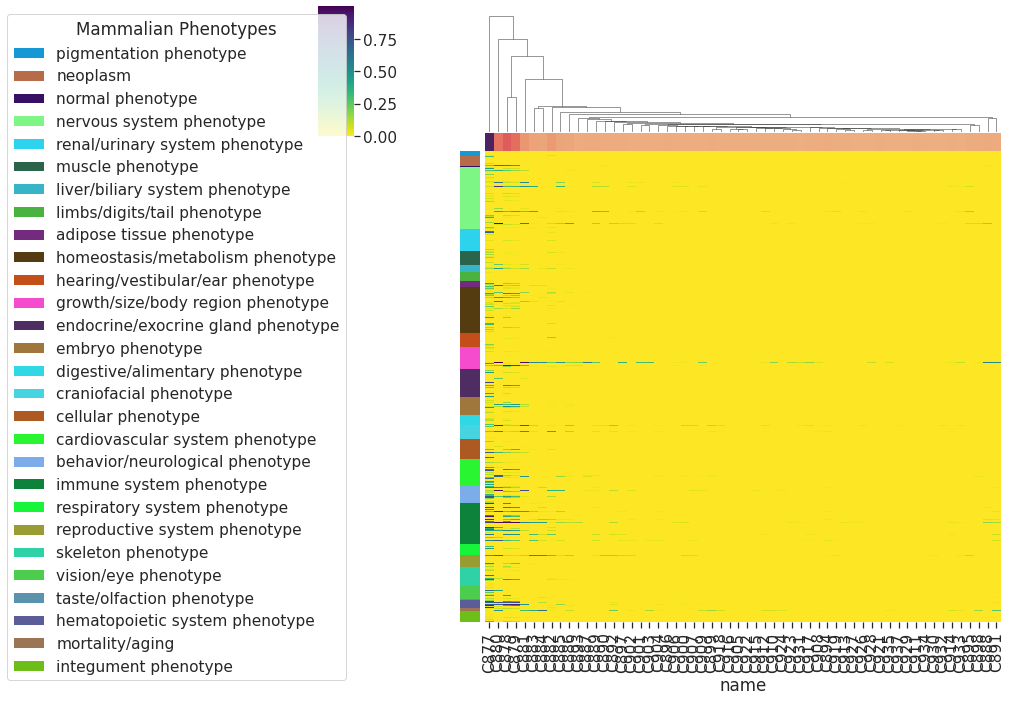

In [490]:
a, mpG, colors, parent_map = plot_hierarchy_heatmap(results_old,MPO_old, term_counts_old,value="hyper_p", root="MP:0000001", levels=1, min_term_size=2,
                          min_observation=1, min_percent=0)

In [492]:
a["log10_ORp"] = -1 * np.log10(a["OR_p"] + 1e-10)

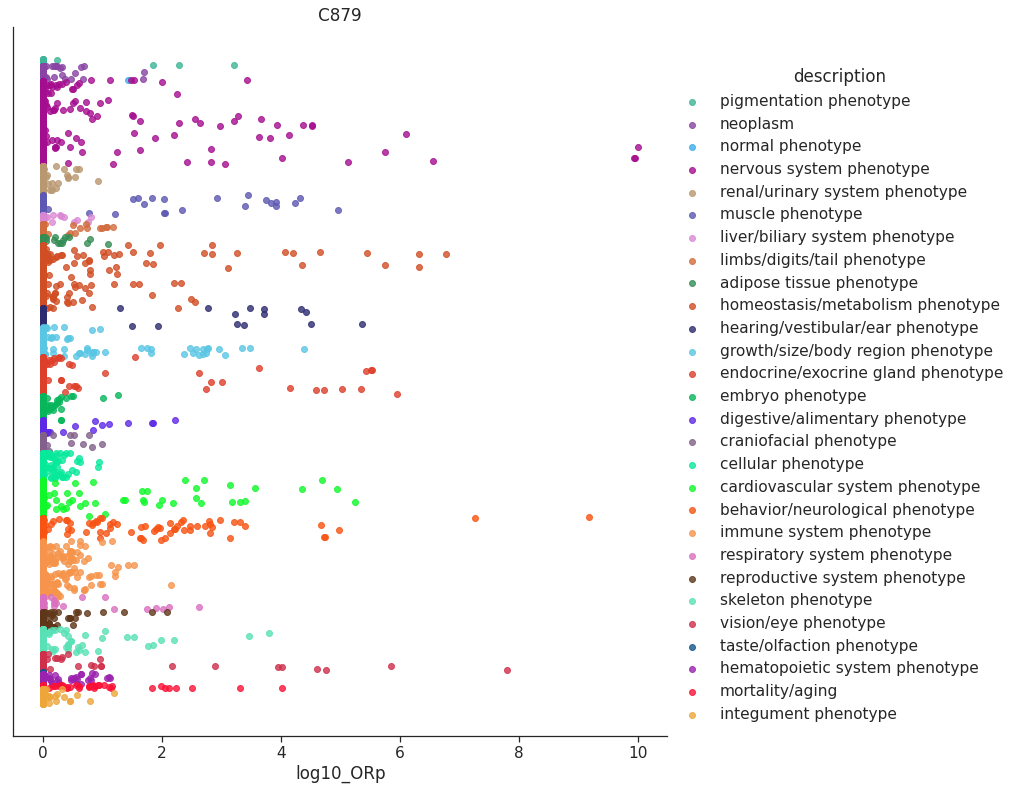

In [488]:
_ = plot_specific_community(a, mpG,"C879", root, colors,MPO_old, parent_map, value="log10_ORp")

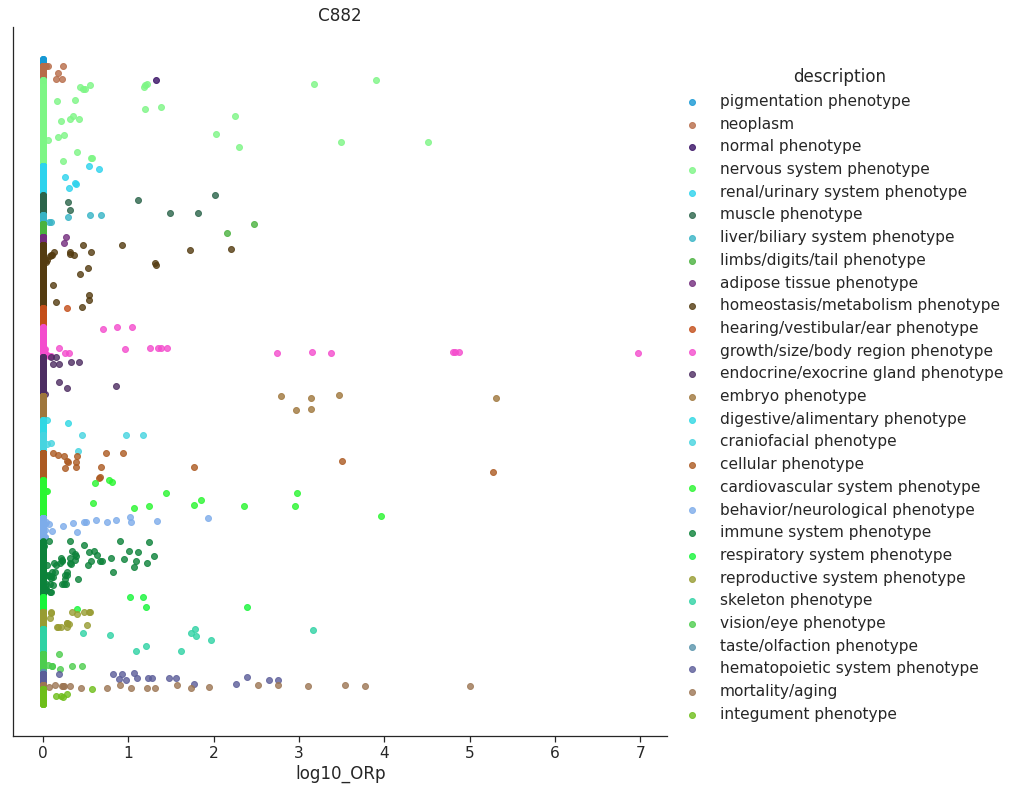

In [493]:
_ = plot_specific_community(a, mpG,"C882", root, colors,MPO_old, parent_map, value="log10_ORp")

In [453]:
x.head()

observed  total   OR  OR_p  OR_CI_lower  OR_CI_upper  hyper_p  \
MP:0001188       NaN    NaN  0.0   NaN          NaN          NaN      NaN   
MP:0011276       NaN    NaN  0.0   NaN          NaN          NaN      NaN   
MP:0011278       NaN    NaN  0.0   NaN          NaN          NaN      NaN   
MP:0030051       NaN    NaN  0.0   NaN          NaN          NaN      NaN   
MP:0000575       NaN    NaN  0.0   NaN          NaN          NaN      NaN   

           sig_5e6             description  size name          MP  log10P  \
MP:0001188     NaN  pigmentation phenotype  10.0  NaN  MP:0001188     NaN   
MP:0011276     NaN  pigmentation phenotype  10.0  NaN  MP:0011276     NaN   
MP:0011278     NaN  pigmentation phenotype  10.0  NaN  MP:0011278     NaN   
MP:0030051     NaN  pigmentation phenotype  10.0  NaN  MP:0030051     NaN   
MP:0000575     NaN  pigmentation phenotype  10.0  NaN  MP:0000575     NaN   

            percent  value parent  expected     parents  number  
MP:0001188      NaN    NaN    NaN       NaN  MP:0001186    7097  
MP:0011276      NaN    NaN    NaN       NaN  MP:0001186    7096  
MP:0011278      NaN    NaN    NaN       NaN  MP:0001186    7095  
MP:0030051      NaN    NaN    NaN       NaN  MP:0001186    7094  
MP:0000575      NaN    NaN    NaN       NaN  MP:0001186    7093

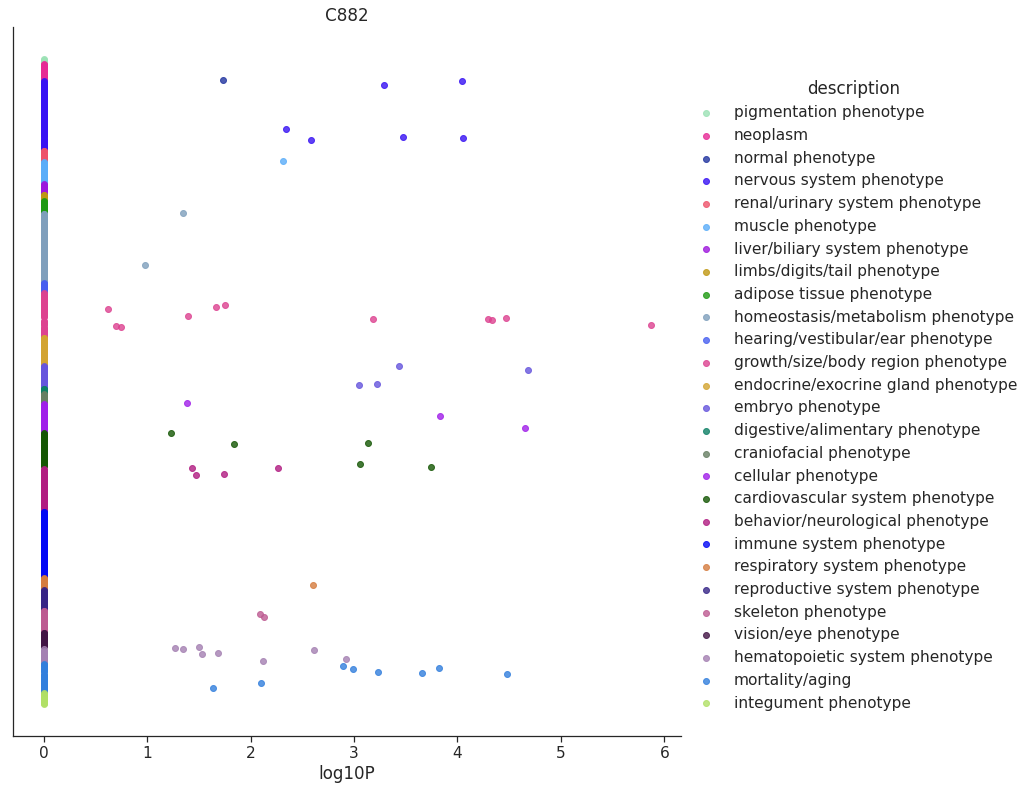

In [420]:
plot_specific_community(a.loc[a.observed > 6], mpG,"C882", root, colors,MPO_old, parent_map, value="log10P")

In [371]:
plot_specific_community(a.loc[a.observed > 2], mpG,"C907", root, colors,MPO_old, parent_map, value="log10P")

AttributeError: 'NoneType' object has no attribute 'loc'

In [407]:
a.loc[a]

observed  total          OR          OR_p  OR_CI_lower  \
MP:0002075       1.0  192.0   12.185864  1.868476e-02     1.516704   
MP:0002877       2.0   81.0   52.686357  5.186336e-07    11.204651   
MP:0008733       1.0    5.0  522.388889  8.128688e-08    53.076963   
MP:0005075       1.0   53.0   40.081197  5.175467e-04     4.988188   
MP:0001324       1.0  160.0    1.745330  5.815557e-01     0.240808   

            OR_CI_upper  hyper_p sig_5e6  \
MP:0002075    97.906561      0.0   False   
MP:0002877   247.741065      0.0   False   
MP:0008733  5141.404768      0.0    True   
MP:0005075   322.061299      0.0   False   
MP:0001324    12.649791      0.0   False   

                                                 description  size  name  \
MP:0002075                   abnormal coat/hair pigmentation   9.0  C906   
MP:0002877                    abnormal melanocyte morphology  11.0  C894   
MP:0008733  abnormal hair shaft melanin granule distribution  10.0  C904   
MP:0005075                    abnormal melanosome morphology  10.0  C904   
MP:0001324                         abnormal eye pigmentation  68.0  C881   

                    MP    log10P   percent  value      parent  
MP:0002075  MP:0002075  2.449061  0.111111    NaN  MP:0001186  
MP:0002877  MP:0002877  4.907912  0.181818    NaN  MP:0001186  
MP:0008733  MP:0008733  5.595326  0.200000    NaN  MP:0001186  
MP:0005075  MP:0005075  3.462003  0.100000    NaN  MP:0001186  
MP:0001324  MP:0001324  0.943458  0.014706    NaN  MP:0001186

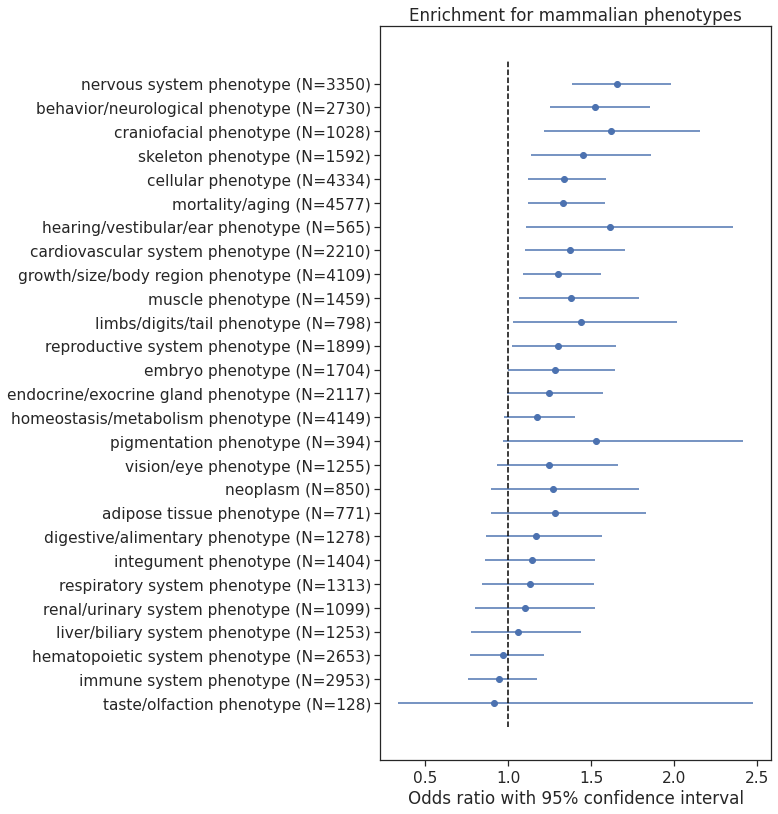

In [166]:
plot_CIs(results_old, "MP:0000001")

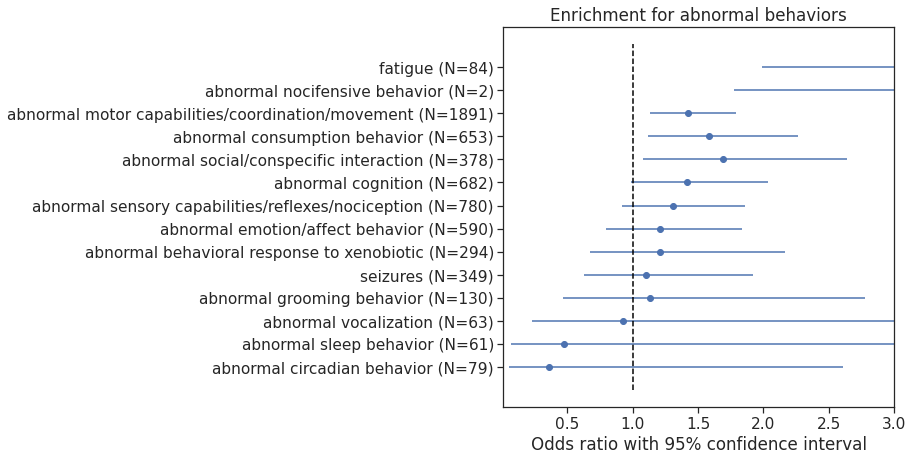

In [170]:
plot_CIs(results_old, "MP:0004924")
plt.xlim([0.01, 3])
plt.xscale("linear")

In [201]:
len(G_int.nodes)
get_contingency_stats(30, 9083,50, 18800)

[[30, 9053], [20, 9697]]


OR      OR_p  OR_CI_lower  OR_CI_upper
0  1.606705  0.100896     0.911802     2.831207

In [192]:
30/9053

0.003313818623660665

In [181]:
len(MPO_old.genes)

9083

# Chi squared

In [273]:
from scipy.stats import chisquare
def chi_squared_test(observed, term_size, community_size, network_size):
    q00 = observed
    q01 = term_size - observed
    q10 = community_size - observed
    q11 = network_size - q00 - q01 - q10
    results_table = np.array([[q00, q01], [q10, q11]])
    p_term = term_size/network_size
    p_community = community_size/network_size
    expected = np.array([[p_term * p_community, p_term*(1 - p_community)], [(1-p_term)*p_community, (1-p_term)*(1-p_community)]])
    expected = expected * network_size
    a = chisquare(results_table, expected, axis=None)
    print(results_table)
    print(expected)
    print(sum(sum(((results_table - expected)**2)/expected)))
    return a

In [281]:
r = chi_squared_test(191, 4577, 642, 18820)
r

[[  191  4386]
 [  451 13792]]
[[  156.1335813  4420.8664187]
 [  485.8664187 13757.1335813]]
10.651481706274563


Power_divergenceResult(statistic=10.651481706274563, pvalue=0.013767744616351732)

In [286]:
ch = get_contingency_stats(191, 4577, 642,18820)

[[191, 4386], [451, 13792]]
[[7.78607102 0.27498391]
 [2.50206046 0.08836631]]


In [293]:
ch.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [290]:
print(ch.test_ordinal_association())

null_mean   13757.133581296494
null_sd     10.683507684171557
pvalue      0.0011001642053493645
statistic   13792.0
zscore      3.2635740745676434


In [292]:
?contingency_tables.Table2x2.oddsratio_pvalue

# Poster figures

In [29]:
results_old.head()

observed   total        OR      OR_p  OR_CI_lower  OR_CI_upper  \
MP:0000001     359.0  9099.0  1.369861  0.000100     1.169075     1.605131   
MP:0010768     194.0  4587.0  1.358843  0.000470     1.144300     1.613610   
MP:0010769     184.0  4192.0  1.420347  0.000082     1.192765     1.691352   
MP:0005384     182.0  4337.0  1.335314  0.001208     1.120838     1.590831   
MP:0005378     171.0  4118.0  1.309012  0.003111     1.095015     1.564829   

             hyper_p sig_5e6                        description   size  name  
MP:0000001  0.000040   False                mammalian phenotype  642.0  C877  
MP:0010768  0.000251   False                    mortality/aging  642.0  C877  
MP:0010769  0.000049   False                  abnormal survival  642.0  C877  
MP:0005384  0.000630   False                 cellular phenotype  642.0  C877  
MP:0005378  0.001579   False  growth/size/body region phenotype  642.0  C877

observed   total        OR      OR_p  OR_CI_lower  OR_CI_upper  \
MP:0000516      29.0   845.0  1.006577  0.972957     0.689031     1.470467   
MP:0002420      48.0  1412.0  0.996120  0.979683     0.738507     1.343594   
MP:0002092      45.0  1142.0  1.173667  0.309884     0.861619     1.598727   
MP:0005451      81.0  2005.0  1.219768  0.101422     0.961704     1.547082   
MP:0002089     118.0  2755.0  1.327149  0.006525     1.082310     1.627375   
MP:0004196      52.0  1077.0  1.474917  0.008732     1.103138     1.971992   
MP:0002069      34.0   655.0  1.581008  0.011336     1.109058     2.253793   
MP:0020182       4.0    37.0  3.447326  0.019762     1.217651     9.759823   

             hyper_p sig_5e6                                 description  \
MP:0000516  0.437308   False    abnormal renal/urinary system morphology   
MP:0002420  0.471760   False                  abnormal adaptive immunity   
MP:0002092  0.136335   False                     abnormal eye morphology   
MP:0005451  0.046655   False                   abnormal body composition   
MP:0002089  0.003360   False  abnormal postnatal growth/weight/body size   
MP:0004196  0.004707   False   abnormal prenatal growth/weight/body size   
MP:0002069  0.006070   False               abnormal consumption behavior   
MP:0020182  0.008034   False                    abnormal body mass index   

             size  name       c  
MP:0000516  642.0  C877  orange  
MP:0002420  642.0  C877  orange  
MP:0002092  642.0  C877  orange  
MP:0005451  642.0  C877    blue  
MP:0002089  642.0  C877    blue  
MP:0004196  642.0  C877    blue  
MP:0002069  642.0  C877    blue  
MP:0020182  642.0  C877    blue

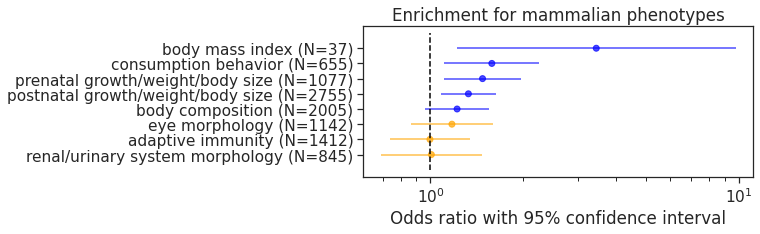

In [30]:
plot_specific_CIs(results_old, ["MP:0002069", "MP:0002089", "MP:0005451", "MP:0004196", "MP:0020182","MP:0002420","MP:0000516", "MP:0002092"], n_test=5, sort=True)#, n_control=3)

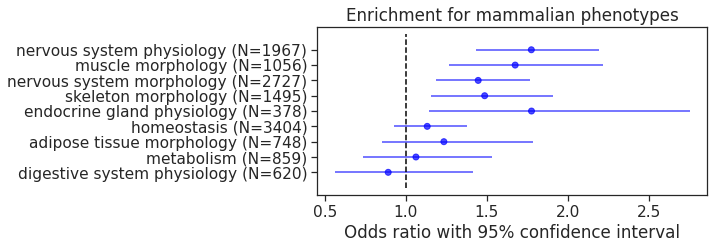

In [598]:
plot_specific_CIs(results_old, ["MP:0003633", "MP:0003632", "MP:0013561", "MP:0002108", "MP:0005508", "MP:0005266", "MP:0001764", "MP:0001663", "MP:0000003"], n_test=9, sort=True)

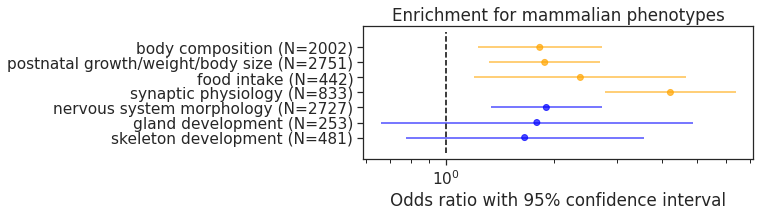

In [642]:
c879 = plot_specific_CIs(results_old, ["MP:0005451", "MP:0002089", "MP:0005449", "MP:0021009", "MP:0003632", "MP:0020973", "MP:0002113"][::-1], n_test=3, sort=False, use_node="C879")

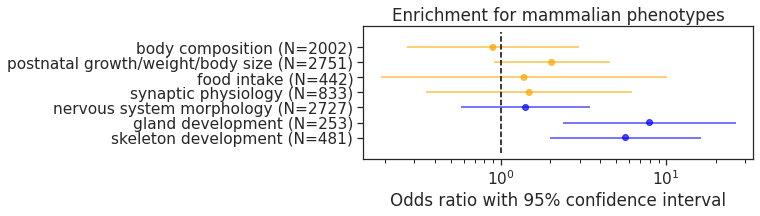

In [643]:
c885 = plot_specific_CIs(results_old, ["MP:0005451", "MP:0002089", "MP:0005449", "MP:0021009", "MP:0003632", "MP:0020973", "MP:0002113"][::-1], n_test=3, sort=False, use_node="C885")

Text(0.5, 0, 'Odds ratio with 95% confidence interval')

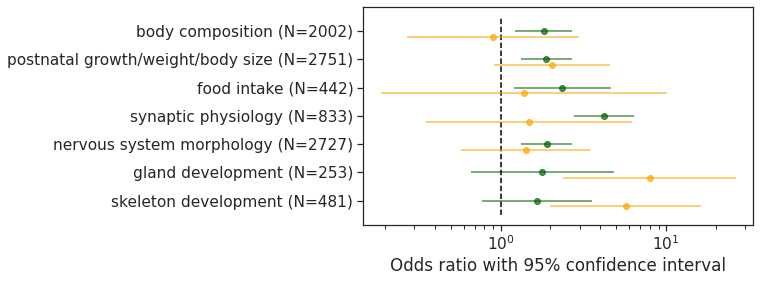

In [651]:
plt.figure(figsize=(7,4))
plt.scatter(c879.OR, [i for i in range(len(c879))], c='darkgreen', alpha=0.7)
plt.scatter(c885.OR, [i-0.2 for i in range(len(c885))], c='orange', alpha=0.7)
plt.hlines([i for i in range(len(c879))], c879.OR_CI_lower, c879.OR_CI_upper, colors="darkgreen", alpha=0.7)
plt.vlines(1.0, -0.5, len(c879)-0.5, linestyles='dashed', colors='black')
plt.hlines([i-0.2 for i in range(len(c885))], c885.OR_CI_lower, c885.OR_CI_upper, colors="orange", alpha=0.7)
plt.xscale("log")
ylabels = [c879.loc[node, "description"] + " (N=" + str(int(c879.loc[node, "total"]))+")" for node in c879.index]
ylabels = [desc.split("abnormal ")[1] for desc in ylabels]
a=plt.yticks(ticks=[i for i in range(len(c879))], labels=ylabels)
plt.xlabel("Odds ratio with 95% confidence interval")

### New version

In [377]:
mps = ["MP:0002089", "MP:0004196", "MP:0005451", "MP:0002069", "MP:0003632", "MP:0003633", "MP:0005508", "MP:0001533",
      "MP:0002108", "MP:0002106", "MP:0002127", "MP:0001544", "MP:0000358", "MP:0005621", "MP:0014134", "MP:0008932",
      "MP:0000685", "MP:0001790", "MP:0000516", "MP:0005502"]

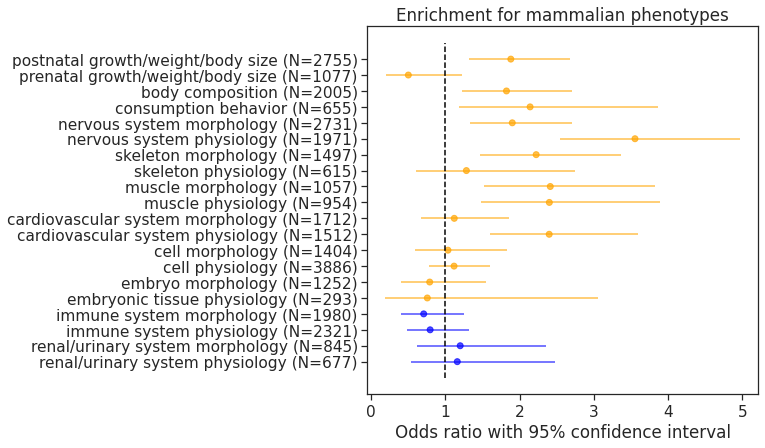

In [449]:
c879 = plot_specific_CIs(results_old, mps[::-1], n_test=4, sort=False, use_node="C879")

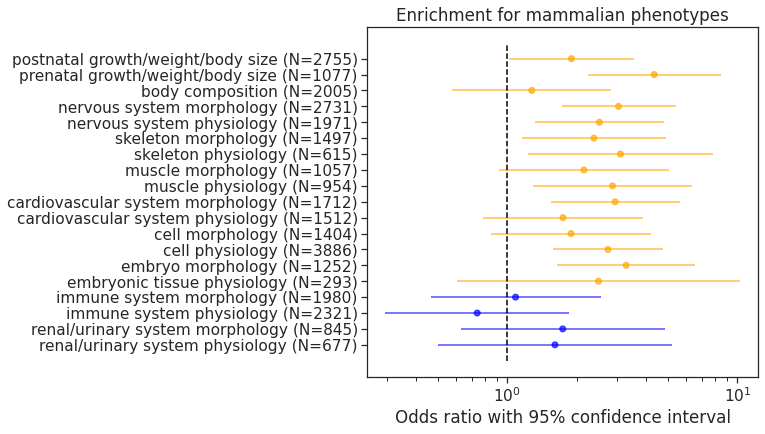

In [380]:
c882 = plot_specific_CIs(results_old, mps[::-1], n_test=4, sort=False, use_node="C882")

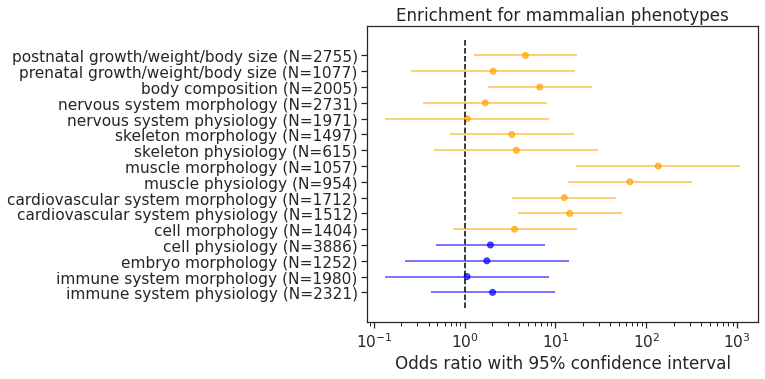

In [381]:
c907 = plot_specific_CIs(results_old, mps[::-1], n_test=4, sort=False, use_node="C907")

In [401]:
to_plot=c879.join(c882.loc[:, ("OR", "OR_CI_lower", "OR_CI_upper")], how="outer", lsuffix="", rsuffix="c882")
to_plot = to_plot.join(c907.loc[:, ("OR", "OR_CI_lower", "OR_CI_upper")], how="outer", lsuffix="", rsuffix="c907")
to_plot.head()
to_plot=to_plot.loc[mps]

In [410]:
to_plot.loc[to_plot.ORc882.isna(), "ORc882"] = 1
to_plot.loc[to_plot.ORc907.isna(), "ORc907"] = 1

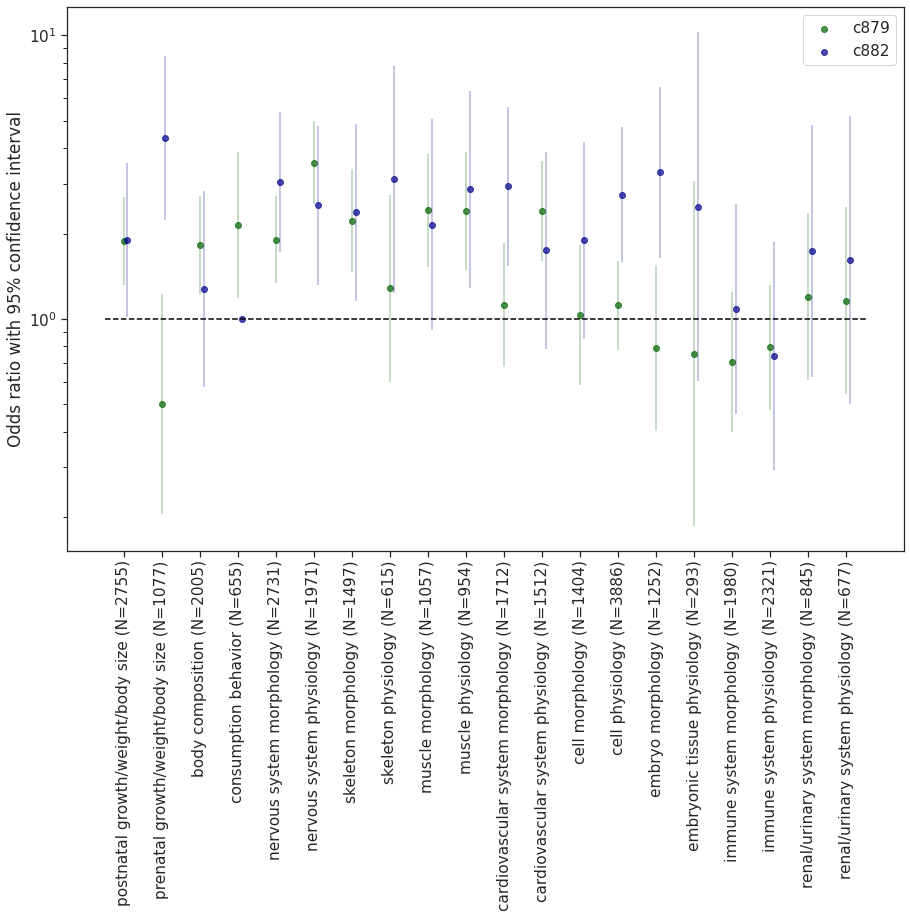

In [428]:
plt.figure(figsize=(15,10))
plt.scatter(y=to_plot.OR, x=[i for i in range(len(to_plot))], c='darkgreen', alpha=0.7, label="c879")
plt.scatter(y=to_plot.ORc882, x=[i+0.1 for i in range(len(to_plot))], c='darkblue', alpha=0.7, label="c882")
#plt.scatter(y=to_plot.ORc907, x=[i+0.2 for i in range(len(to_plot))], c="orange", alpha=0.7, label="c907")
plt.vlines([i for i in range(len(to_plot))], to_plot.OR_CI_lower, to_plot.OR_CI_upper, colors="darkgreen", alpha=0.3)
plt.hlines(1.0, -0.5, len(to_plot)-0.5, linestyles='dashed', colors='black')
plt.vlines([i+0.1 for i in range(len(to_plot))], to_plot.OR_CI_lowerc882, to_plot.OR_CI_upperc882, colors="darkblue", alpha=0.3)
#plt.vlines([i+0.2 for i in range(len(to_plot))], to_plot.OR_CI_lowerc907, to_plot.OR_CI_upperc907, colors="orange", alpha=0.3)
plt.yscale("log")
xlabels = [to_plot.loc[node, "description"] + " (N=" + str(int(to_plot.loc[node, "total"]))+")" for node in to_plot.index]
xlabels = [desc.split("abnormal ")[1] for desc in xlabels]
a=plt.xticks(ticks=[i for i in range(len(to_plot))], labels=xlabels, rotation='vertical')
plt.ylabel("Odds ratio with 95% confidence interval")
#plt.vlines(np.array([3,5,7,9,11,13,15,17])+0.7, 0.5, 10, color="grey")
plt.legend()

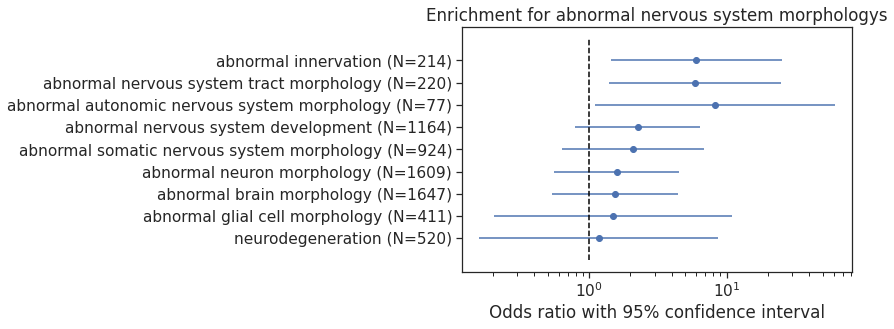

In [619]:
plot_CIs(results_old, root="MP:0003632", use_node="C885")

# BMI terms


In [15]:
mp_graph = _get_mp_graph()

In [21]:
MPO2.node_attr

description
MP                                                  
MP:0000001                       mammalian phenotype
MP:0000003        abnormal adipose tissue morphology
MP:0000005     increased brown adipose tissue amount
MP:0000008     increased white adipose tissue amount
MP:0000010     abnormal abdominal fat pad morphology
...                                              ...
MP:0031321      enhanced cardiac muscle regeneration
MP:3000001              abnormal gastrula morphology
MP:3000003         abnormal Ebner's gland morphology
MP:3000004  abnormal nictitating membrane morphology
MP:3000005          abnormal lacrimal sac morphology

[13376 rows x 1 columns]

In [27]:
#desc = MPO.node_attr.loc[to_test.index]
[(node, MPO2.node_attr.loc[node, "description"]) for node in nx.dfs_preorder_nodes(mp_graph, "MP:0005451")]

[('MP:0005451', 'abnormal body composition'),
 ('MP:0000676', 'abnormal body water content'),
 ('MP:0000679', 'increased percent water in carcass'),
 ('MP:0000683', 'decreased percent water in carcass'),
 ('MP:0003959', 'abnormal lean body mass'),
 ('MP:0003960', 'increased lean body mass'),
 ('MP:0003961', 'decreased lean body mass'),
 ('MP:0012320', 'abnormal body fat mass'),
 ('MP:0014142', 'increased body fat mass'),
 ('MP:0014143', 'decreased body fat mass'),
 ('MP:0012321', 'abnormal total tissue mass'),
 ('MP:0012322', 'decreased total tissue mass'),
 ('MP:0001262', 'decreased body weight'),
 ('MP:0001263', 'weight loss'),
 ('MP:0005150', 'cachexia'),
 ('MP:0008489', 'slow postnatal weight gain'),
 ('MP:0012323', 'increased total tissue mass'),
 ('MP:0001260', 'increased body weight'),
 ('MP:0001261', 'obese'),
 ('MP:0020182', 'abnormal body mass index'),
 ('MP:0006086', 'decreased body mass index'),
 ('MP:0006087', 'increased body mass index')]

In [39]:
keep = []
tested = []
queue = ["MP:0000001"]
while len(queue) > 0:
    root = queue.pop()
    children = [node for node in nx.dfs_preorder_nodes(mp_graph, root, 1) if node not in tested]
    if len(children) > 0:
        for i in children: 
            tested.append(i)
            x = input(MPO2.node_attr.loc[i, "description"])
            if x == "y":
                keep.append(i)
                
                queue.append(i)
print(keep)

mammalian phenotypey
pigmentation phenotypen
neoplasmn
normal phenotypen
no phenotypic analysisn
nervous system phenotypen
renal/urinary system phenotypen
muscle phenotypen
liver/biliary system phenotypen
limbs/digits/tail phenotypen
adipose tissue phenotypen
homeostasis/metabolism phenotypen
hearing/vestibular/ear phenotypen
growth/size/body region phenotypey
endocrine/exocrine gland phenotypen
embryo phenotypen
digestive/alimentary phenotypen
craniofacial phenotypen
cellular phenotypen
cardiovascular system phenotypen
behavior/neurological phenotypen
immune system phenotypen
respiratory system phenotypen
reproductive system phenotypen
skeleton phenotypen
vision/eye phenotypen
taste/olfaction phenotypen
hematopoietic system phenotypen
mortality/agingn
integument phenotypen
abnormal head morphologyn
distended abdomeny
abnormal postnatal growth/weight/body sizey
abnormal body wall morphologyn
heterotaxian
abnormal chest morphologyn
abnormal prenatal growth/weight/body sizey
abnormal bod

In [41]:
keep_body_size=keep

In [42]:
keep = []
tested = []
queue = ["MP:0000001"]
while len(queue) > 0:
    root = queue.pop()
    children = [node for node in nx.dfs_preorder_nodes(mp_graph, root, 1) if node not in tested]
    if len(children) > 0:
        for i in children: 
            tested.append(i)
            x = input(MPO2.node_attr.loc[i, "description"])
            if x == "y":
                keep.append(i)
                
                queue.append(i)
print(keep)

mammalian phenotypey
pigmentation phenotypen
neoplasmn
normal phenotypen
no phenotypic analysisn
nervous system phenotypen
renal/urinary system phenotypen
muscle phenotypen
liver/biliary system phenotypen
limbs/digits/tail phenotypen
adipose tissue phenotypen
homeostasis/metabolism phenotypen
hearing/vestibular/ear phenotypen
growth/size/body region phenotypen
endocrine/exocrine gland phenotypen
embryo phenotypen
digestive/alimentary phenotypen
craniofacial phenotypen
cellular phenotypen
cardiovascular system phenotypen
behavior/neurological phenotypey
immune system phenotypen
respiratory system phenotypen
reproductive system phenotypen
skeleton phenotypen
vision/eye phenotypen
taste/olfaction phenotypen
hematopoietic system phenotypen
mortality/agingn
integument phenotypen
abnormal behaviory
abnormal grooming behaviorn
abnormal vocalizationn
seizuresn
abnormal motor capabilities/coordination/movementn
abnormal sensory capabilities/reflexes/nociceptionn
abnormal consumption behaviory
a

In [43]:
keep_behaviour = keep

In [45]:
keep = []
tested = []
queue = ["MP:0000001"]
while len(queue) > 0:
    root = queue.pop()
    children = [node for node in nx.dfs_preorder_nodes(mp_graph, root, 1) if node not in tested]
    if len(children) > 0:n
        for i in children: 
            tested.append(i)
            x = input(MPO2.node_attr.loc[i, "description"])
            if x == "y":
                keep.append(i)
                
                queue.append(i)
print(keep)

mammalian phenotypey
pigmentation phenotypen
neoplasmn
normal phenotype
no phenotypic analysisn
nervous system phenotypen
renal/urinary system phenotypen
muscle phenotypen
liver/biliary system phenotypen
limbs/digits/tail phenotypen
adipose tissue phenotypey
homeostasis/metabolism phenotypen
hearing/vestibular/ear phenotypen
growth/size/body region phenotypen
endocrine/exocrine gland phenotypen
embryo phenotypen
digestive/alimentary phenotypen
craniofacial phenotypen
cellular phenotype
cardiovascular system phenotypen
behavior/neurological phenotypen
immune system phenotypen
respiratory system phenotypen
reproductive system phenotypen
skeleton phenotypen
vision/eye phenotypen
taste/olfaction phenotypen
hematopoietic system phenotypen
mortality/agingn
integument phenotypen
abnormal adipose tissue morphologyy
abnormal adipose tissue physiologyn
abnormal adipose tissue distributiony
abnormal white adipose tissue morphologyy
abnormal brown adipose tissue morphologyy
abnormal fat pad morpho

In [46]:
keep_adipose=keep
len(keep_adipose)

84

In [50]:
keep = []
tested = []
queue = ["MP:0000001"]
while len(queue) > 0:
    root = queue.pop()
    children = [node for node in nx.dfs_preorder_nodes(mp_graph, root, 1) if node not in tested]
    if len(children) > 0:
        for i in children: 
            tested.append(i)
            x = input(MPO2.node_attr.loc[i, "description"])
            if x == "y":
                keep.append(i)
                queue.append(i)
print(keep)

mammalian phenotypey
pigmentation phenotypen
neoplasmn
normal phenotypen
no phenotypic analysisn
nervous system phenotypen
renal/urinary system phenotypen
muscle phenotypey
liver/biliary system phenotypen
limbs/digits/tail phenotype
adipose tissue phenotypen
homeostasis/metabolism phenotypen
hearing/vestibular/ear phenotype
growth/size/body region phenotypen
endocrine/exocrine gland phenotype
embryo phenotypen
digestive/alimentary phenotypen
craniofacial phenotypen
cellular phenotypen
cardiovascular system phenotypen
behavior/neurological phenotypen
immune system phenotypen
respiratory system phenotypen
reproductive system phenotypen
skeleton phenotypen
vision/eye phenotypen
taste/olfaction phenotypen
hematopoietic system phenotypen
mortality/agingn
integument phenotypen
abnormal muscle physiologyn
abnormal muscle morphologyy
abnormal muscle developmenty
muscle hypoplasian
muscle degenerationn
dystrophic muscley
abnormal skeletal muscle morphologyy
abnormal smooth muscle morphologyy
mu

In [51]:
muscle_keep = keep
len(muscle_keep)

20

In [52]:
keep = []
tested = []
queue = ["MP:0003795"]
while len(queue) > 0:
    root = queue.pop()
    children = [node for node in nx.dfs_preorder_nodes(mp_graph, root, 1) if node not in tested]
    if len(children) > 0:
        for i in children: 
            tested.append(i)
            x = input(MPO2.node_attr.loc[i, "description"])
            if x == "y":
                keep.append(i)
                queue.append(i)
print(keep)

abnormal bone structurey
abnormal bone marrow cavity morphologyn
abnormal trabecular bone morphologyn
abnormal bone marrow morphologyn
abnormal compact bone morphologyn
decreased bone massy
abnormal osteoclast morphologyn
abnormal osteoblast morphologyn
osteosclerosisn
increased bone massy
exostosisn
abnormal bone mineral densityn
abnormal bone mineral contentn
abnormal bone volumey
abnormal periosteum morphologyn
abnormal bone collagen fibril morphologyn
abnormal susceptibility to osteoporosisn
osteophytesn
abnormal osteocyte lacunocanalicular system morphologyn
increased bone volumey
decreased bone volumey
abnormal trabecular bone volumen
abnormal compact bone volumey
increased compact bone volumey
decreased compact bone volumey
decreased trabecular bone volumen
increased trabecular bone volumen
osteopetrosisn
increased trabecular bone massy
increased compact bone massy
osteoporosisn
decreased trabecular bone massy
decreased compact bone massy
['MP:0003795', 'MP:0004016', 'MP:0005605

In [53]:
keep_skeleton = keep

In [54]:
all_keep = keep_skeleton + muscle_keep + keep_adipose + keep_behaviour + keep_body_size

In [57]:
all_desc = [MPO2.node_attr.loc[node, "description"] for node in all_keep]

In [59]:
bmi_terms = pd.DataFrame({"MP": all_keep, "description": all_desc})
bmi_terms.head()
bmi_terms.to_csv("curated_bmi_terms.csv", sep="\t", index=False)

# Final full network plots

In [35]:
bmi_terms = pd.read_csv("curated_bmi_terms.csv", sep = "\t")
bmi_terms.head()

MP              description
0  MP:0003795  abnormal bone structure
1  MP:0004016      decreased bone mass
2  MP:0005605      increased bone mass
3  MP:0010874     abnormal bone volume
4  MP:0010875    increased bone volume

Significant enrichments (p < 0.01):
                             description   hyper_p      OR_p
MP:0003956           abnormal body size  0.001237  0.002231
MP:0001431     abnormal eating behavior  0.004999  0.009051
MP:0010866  abnormal prenatal body size  0.001574  0.002470


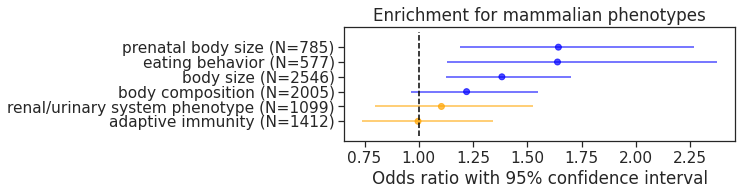

In [306]:
a = plot_specific_CIs(results_old, ["MP:0001431", "MP:0010866", "MP:0003956", "MP:0005451", "MP:0002420", "MP:0005367"], n_test=4, sort=True)
print("Significant enrichments (p < 0.01):\n", a.loc[a.hyper_p <= 0.01, ("description", "hyper_p", "OR_p")])

In [301]:
func = nx.dfs_preorder_nodes(mp_graph, "MP:0000001", 1)
func_nodes = [node for node in func if term_counts[node] > 300]
len(func_nodes)

28

In [289]:
results_old

observed   total         OR      OR_p  OR_CI_lower  OR_CI_upper  \
MP:0000001     359.0  9099.0   1.369861  0.000100     1.169075     1.605131   
MP:0010768     194.0  4587.0   1.358843  0.000470     1.144300     1.613610   
MP:0010769     184.0  4192.0   1.420347  0.000082     1.192765     1.691352   
MP:0005384     182.0  4337.0   1.335314  0.001208     1.120838     1.590831   
MP:0005378     171.0  4118.0   1.309012  0.003111     1.095015     1.564829   
...              ...     ...        ...       ...          ...          ...   
MP:0013693       1.0   914.0   4.901972  0.155270     0.547344    43.901681   
MP:0002429       1.0  1051.0   4.229762  0.197268     0.472345    37.876694   
MP:0012349       1.0   102.0  46.321782  0.000633     5.132526   418.060699   
MP:0002063       1.0   682.0   6.657122  0.090166     0.743078    59.640128   
MP:0001819       1.0  1380.0   3.160986  0.303452     0.353063    28.300408   

             hyper_p sig_5e6  \
MP:0000001  0.000040   False   
MP:0010768  0.000251   False   
MP:0010769  0.000049   False   
MP:0005384  0.000630   False   
MP:0005378  0.001579   False   
...              ...     ...   
MP:0013693  0.021359   False   
MP:0002429  0.027828   False   
MP:0012349  0.000288   False   
MP:0002063  0.012191   False   
MP:0001819  0.046286   False   

                                                  description   size  name  
MP:0000001                                mammalian phenotype  642.0  C877  
MP:0010768                                    mortality/aging  642.0  C877  
MP:0010769                                  abnormal survival  642.0  C877  
MP:0005384                                 cellular phenotype  642.0  C877  
MP:0005378                  growth/size/body region phenotype  642.0  C877  
...                                                       ...    ...   ...  
MP:0013693                               abnormal hemopoiesis    5.0  C927  
MP:0002429         abnormal blood cell morphology/development    5.0  C927  
MP:0012349  increased susceptibility to induction of seizu...    5.0  C927  
MP:0002063              abnormal learning/memory/conditioning    5.0  C927  
MP:0001819                    abnormal immune cell physiology    5.0  C927  

[28441 rows x 11 columns]

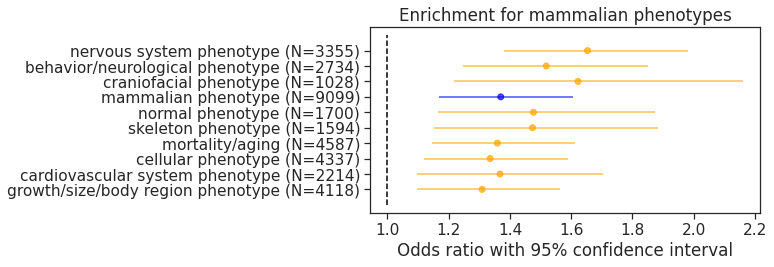

In [303]:
b = plot_specific_CIs(results_old.loc[results_old.OR_p < 0.01], func_nodes, n_test=1, sort=True)


Significant enrichments (p < 0.01):
                                    description       hyper_p          OR_p
MP:0005621            abnormal cell physiology  4.368132e-03  8.873663e-03
MP:0005508        abnormal skeleton morphology  7.745235e-04  1.224183e-03
MP:0003632  abnormal nervous system morphology  1.923257e-04  3.050973e-04
MP:0002108          abnormal muscle morphology  2.412188e-04  3.014465e-04
MP:0003633  abnormal nervous system physiology  2.210373e-07  1.306129e-07


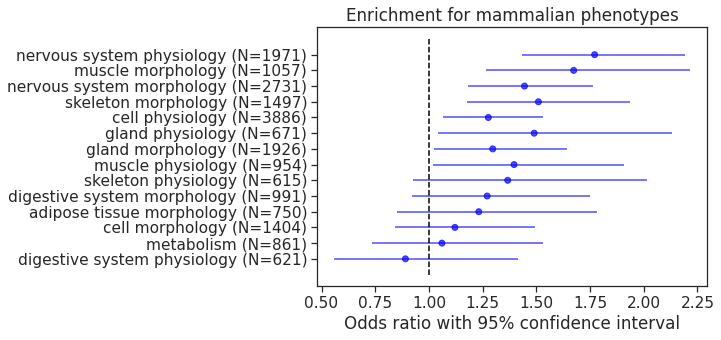

In [239]:
b = plot_specific_CIs(results_old, ["MP:0000003", "MP:0002108", "MP:0002106", "MP:0005508", "MP:0001533", "MP:0003632", "MP:0003633", "MP:0005266", "MP:0002163", "MP:0002164", "MP:0000358", "MP:0005621", "MP:0000462", "MP:0001663"], n_test=14, sort=True)
print("Significant enrichments (p < 0.01):\n", b.loc[b.hyper_p <= 0.01, ("description", "hyper_p", "OR_p")])

Significant enrichments (p < 0.01):
                                description   hyper_p      OR_p
MP:0001431        abnormal eating behavior  0.009846  0.019530
MP:0005367  renal/urinary system phenotype  0.003710  0.006785
MP:0005451       abnormal body composition  0.000273  0.000422
MP:0003956              abnormal body size  0.000071  0.000104


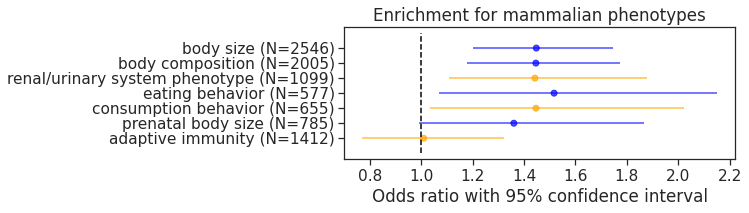

In [248]:
hm = plot_specific_CIs(human_only, ["MP:0001431", "MP:0010866", "MP:0003956", "MP:0005451", "MP:0002069", "MP:0002420", "MP:0005367"], n_test=4, sort=True, use_node="all")
print("Significant enrichments (p < 0.01):\n", hm.loc[hm.hyper_p <= 0.01, ("description", "hyper_p", "OR_p")])

Significant enrichments (p < 0.01):
                                description   hyper_p      OR_p
MP:0005367  renal/urinary system phenotype  0.039830  0.091799
MP:0010866     abnormal prenatal body size  0.023045  0.051457


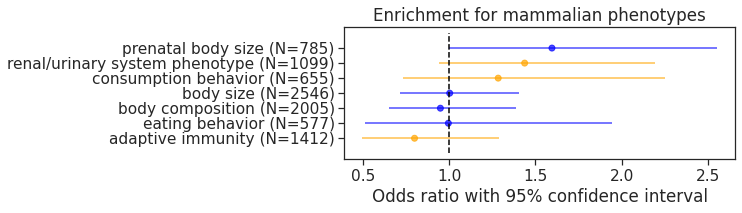

In [250]:
hm = plot_specific_CIs(rat_only, ["MP:0001431", "MP:0010866", "MP:0003956", "MP:0005451", "MP:0002069", "MP:0002420", "MP:0005367"], n_test=4, sort=True, use_node="all")
print("Significant enrichments (p < 0.01):\n", hm.loc[hm.hyper_p <= 0.05, ("description", "hyper_p", "OR_p")])

In [265]:
bmi_results = human_only.loc[human_only.index.isin(bmi_terms.MP)]
bmi_results.head()
all_traits = bmi_results.loc[((bmi_results["name"]=="all") & (bmi_results["OR_p"] <= 0.01) & (bmi_results["observed"] >= 78))].index.values

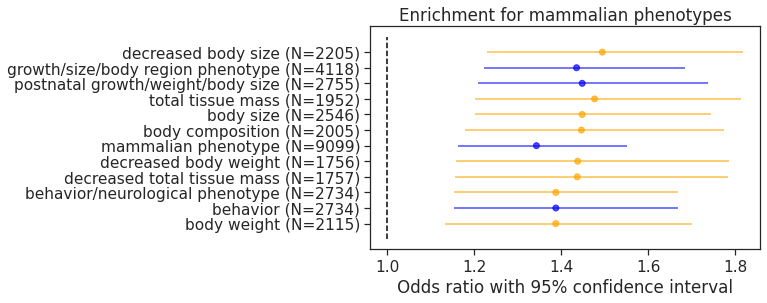

In [266]:
all_traits
hm = plot_specific_CIs(human_only, all_traits, n_test=4, sort=True, use_node="all")


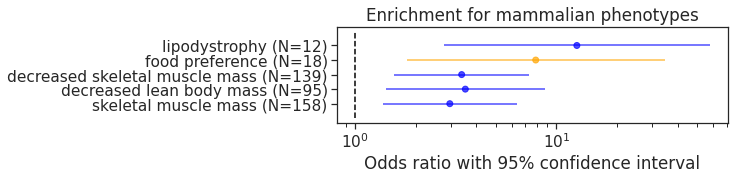

In [277]:
bmi_results = rat_only.loc[rat_only.index.isin(bmi_terms.MP)]
bmi_results.head()
all_traits = bmi_results.loc[((bmi_results["name"]=="all") & (bmi_results["OR_p"] <= 0.01) & (bmi_results["observed"] >= 1))].index.values
rt = plot_specific_CIs(rat_only, all_traits, n_test=4, sort=True, use_node="all")

In [278]:
rt

observed  total         OR      OR_p  OR_CI_lower  OR_CI_upper  \
MP:0004817         7    158   2.957552  0.005568     1.373967     6.366320   
MP:0003961         5     95   3.531609  0.006457     1.424431     8.755960   
MP:0004819         7    139   3.386758  0.001878     1.569613     7.307618   
MP:0001432         2     18   7.896331  0.006019     1.807423    34.497760   
MP:0011174         2     12  12.638225  0.001093     2.757059    57.933018   

             hyper_p  sig_5e6                     description  size name  \
MP:0004817  0.003520    False   abnormal skeletal muscle mass   295  all   
MP:0003961  0.003819    False        decreased lean body mass   295  all   
MP:0004819  0.001587    False  decreased skeletal muscle mass   295  all   
MP:0001432  0.002613    False        abnormal food preference   295  all   
MP:0011174  0.000755    False                   lipodystrophy   295  all   

                 c  
MP:0004817    blue  
MP:0003961    blue  
MP:0004819    blue  
MP:0001432  orange  
MP:0011174    blue

In [39]:
bmi_results = results_old.loc[results_old.index.isin(bmi_terms.MP)]
bmi_results.head()

observed   total        OR      OR_p  OR_CI_lower  OR_CI_upper  \
MP:0000001     359.0  9099.0  1.369861  0.000100     1.169075     1.605131   
MP:0005378     171.0  4118.0  1.309012  0.003111     1.095015     1.564829   
MP:0005386     130.0  2734.0  1.518562  0.000032     1.247139     1.849058   
MP:0004924     130.0  2734.0  1.518562  0.000032     1.247139     1.849058   
MP:0002089     118.0  2755.0  1.327149  0.006525     1.082310     1.627375   

             hyper_p sig_5e6                                 description  \
MP:0000001  0.000040   False                         mammalian phenotype   
MP:0005378  0.001579   False           growth/size/body region phenotype   
MP:0005386  0.000024   False             behavior/neurological phenotype   
MP:0004924  0.000024   False                           abnormal behavior   
MP:0002089  0.003360   False  abnormal postnatal growth/weight/body size   

             size  name  
MP:0000001  642.0  C877  
MP:0005378  642.0  C877  
MP:0005386  642.0  C877  
MP:0004924  642.0  C877  
MP:0002089  642.0  C877

In [79]:
all_traits = bmi_results.loc[((bmi_results["name"]=="C877") & (bmi_results["OR_p"] <= 0.01) & (bmi_results["observed"] >= 10))].index.values

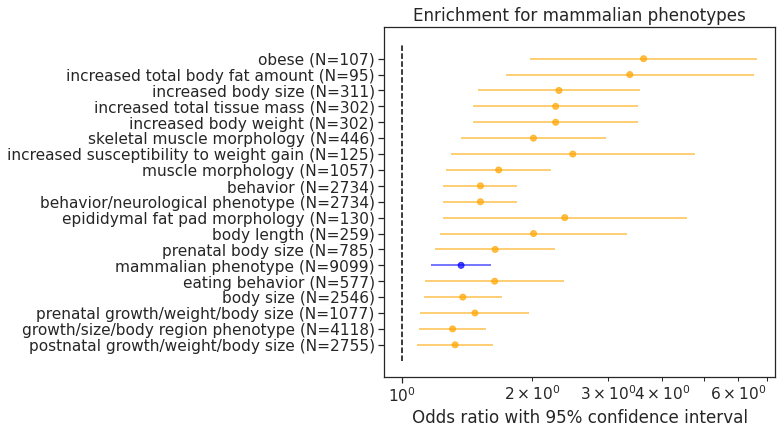

In [81]:
plotted_results = plot_specific_CIs(bmi_results, all_traits, n_test=1, sort=True)

In [82]:
plotted_results

observed   total        OR      OR_p  OR_CI_lower  OR_CI_upper  \
MP:0002089     118.0  2755.0  1.327149  0.006525     1.082310     1.627375   
MP:0005378     171.0  4118.0  1.309012  0.003111     1.095015     1.564829   
MP:0004196      52.0  1077.0  1.474917  0.008732     1.103138     1.971992   
MP:0003956     113.0  2546.0  1.382367  0.002231     1.123266     1.701234   
MP:0001431      31.0   577.0  1.638436  0.009051     1.130871     2.373810   
MP:0000001     359.0  9099.0  1.369861  0.000100     1.169075     1.605131   
MP:0010866      42.0   785.0  1.642598  0.002470     1.191179     2.265089   
MP:0001256      17.0   259.0  2.015947  0.005813     1.224938     3.317755   
MP:0006319      10.0   130.0  2.381065  0.008894     1.243074     4.560849   
MP:0005386     130.0  2734.0  1.518562  0.000032     1.247139     1.849058   
MP:0004924     130.0  2734.0  1.518562  0.000032     1.247139     1.849058   
MP:0002108      57.0  1057.0  1.673754  0.000301     1.265843     2.213112   
MP:0005455      10.0   125.0  2.485278  0.006130     1.296092     4.765560   
MP:0000759      29.0   446.0  2.014971  0.000360     1.371206     2.960978   
MP:0001260      22.0   302.0  2.268180  0.000275     1.458899     3.526385   
MP:0012323      22.0   302.0  2.268180  0.000275     1.458899     3.526385   
MP:0001264      23.0   311.0  2.308102  0.000149     1.498173     3.555889   
MP:0010024      10.0    95.0  3.368019  0.000311     1.740726     6.516567   
MP:0001261      12.0   107.0  3.625664  0.000031     1.978504     6.644130   

             hyper_p sig_5e6                                 description  \
MP:0002089  0.003360   False  abnormal postnatal growth/weight/body size   
MP:0005378  0.001579   False           growth/size/body region phenotype   
MP:0004196  0.004707   False   abnormal prenatal growth/weight/body size   
MP:0003956  0.001237   False                          abnormal body size   
MP:0001431  0.004999   False                    abnormal eating behavior   
MP:0000001  0.000040   False                         mammalian phenotype   
MP:0010866  0.001574   False                 abnormal prenatal body size   
MP:0001256  0.003522   False                        abnormal body length   
MP:0006319  0.004966   False      abnormal epididymal fat pad morphology   
MP:0005386  0.000024   False             behavior/neurological phenotype   
MP:0004924  0.000024   False                           abnormal behavior   
MP:0002108  0.000241   False                  abnormal muscle morphology   
MP:0005455  0.003688   False     increased susceptibility to weight gain   
MP:0000759  0.000340   False         abnormal skeletal muscle morphology   
MP:0001260  0.000296   False                       increased body weight   
MP:0012323  0.000296   False                 increased total tissue mass   
MP:0001264  0.000181   False                         increased body size   
MP:0010024  0.000388   False             increased total body fat amount   
MP:0001261  0.000072   False                                       obese   

             size  name       c  
MP:0002089  642.0  C877  orange  
MP:0005378  642.0  C877  orange  
MP:0004196  642.0  C877  orange  
MP:0003956  642.0  C877  orange  
MP:0001431  642.0  C877  orange  
MP:0000001  642.0  C877    blue  
MP:0010866  642.0  C877  orange  
MP:0001256  642.0  C877  orange  
MP:0006319  642.0  C877  orange  
MP:0005386  642.0  C877  orange  
MP:0004924  642.0  C877  orange  
MP:0002108  642.0  C877  orange  
MP:0005455  642.0  C877  orange  
MP:0000759  642.0  C877  orange  
MP:0001260  642.0  C877  orange  
MP:0012323  642.0  C877  orange  
MP:0001264  642.0  C877  orange  
MP:0010024  642.0  C877  orange  
MP:0001261  642.0  C877  orange

# Gene lists

In [ ]:
term_counts, gene_mapping, term_mapping = genes_per_node(MPO2)

In [575]:
a = get_gene_hits("C879", hier_df_genes, term_mapping, "MP:0001431", MPO2, mp_graph)

gene community          MP   MP_parent  inMP  MsOrtho  \
0  NRCAM      C879  MP:0001431  MP:0001431     0        1   
1   SYT6      C879  MP:0001431  MP:0001431     0        0   
2   SYT2      C879  MP:0001431  MP:0001431     0        1   
3   SYT1      C879  MP:0001431  MP:0001431     1        1   
4  KRT75      C879  MP:0001431  MP:0001431     0        1   

                description  
0  abnormal eating behavior  
1  abnormal eating behavior  
2  abnormal eating behavior  
3  abnormal eating behavior  
4  abnormal eating behavior

In [576]:
c879_1431 = get_gene_hits("C879", hier_df_genes, term_mapping, "MP:0001431", MPO2, mp_graph)

In [577]:
c879_2069 = get_gene_hits("C879", hier_df_genes, term_mapping, "MP:0002069", MPO2, mp_graph)

In [578]:
c879_3632 = get_gene_hits("C879", hier_df_genes, term_mapping, "MP:0003632", MPO2, mp_graph)

In [579]:
c882_4196 = get_gene_hits("C882", hier_df_genes, term_mapping, "MP:0004196", MPO2, mp_graph)

In [580]:
c882_10866 = get_gene_hits("C882", hier_df_genes, term_mapping, "MP:0010866", MPO2, mp_graph)

In [581]:
c882_3632 = get_gene_hits("C882", hier_df_genes, term_mapping, "MP:0003632", MPO2, mp_graph)

In [582]:
all_results = pd.concat([c879_1431, c879_2069, c879_3632, c882_4196, c882_10866, c882_3632])

In [583]:
all_results.head()

gene community          MP   MP_parent  inMP  MsOrtho  \
0  NRCAM      C879  MP:0001431  MP:0001431     0        1   
1   SYT6      C879  MP:0001431  MP:0001431     0        0   
2   SYT2      C879  MP:0001431  MP:0001431     0        1   
3   SYT1      C879  MP:0001431  MP:0001431     1        1   
4  KRT75      C879  MP:0001431  MP:0001431     0        1   

                description  
0  abnormal eating behavior  
1  abnormal eating behavior  
2  abnormal eating behavior  
3  abnormal eating behavior  
4  abnormal eating behavior

In [592]:
a = all_results.loc[((all_results.community == "C879") & (all_results.MP_parent=="MP:0001431") & (all_results.inMP == 1) & (all_results.MP=="MP:0001431")), ("gene")].values
for g in a:
    print(g)

SYT1
POMC
TUB
LGR5
HNF4G
LMTK3
PRLHR
PTPRD
RCAN2
MC4R
BDNF


In [598]:
a = all_results.loc[((all_results.community == "C879") & (all_results.MP_parent=="MP:0002069") & (all_results.inMP == 1) & (all_results.MP=="MP:0002069")), ("gene")].values
for g in a:
    print(g)

SYT1
POMC
TUB
GRIA3
LGR5
HNF4G
LMTK3
PRLHR
PTPRD
RCAN2
MC4R
BDNF


In [600]:
a = all_results.loc[((all_results.community == "C882") & (all_results.MP_parent=="MP:0010866") & (all_results.inMP == 1) & (all_results.MP=="MP:0010866")), ("gene")].values
for g in a:
    print(g)

WNK1
AXIN1
STK4
CCP110
KDM6B
NFATC3
KDM8
SP3
NUMBL
KDM6A
UBR2


In [602]:
a = all_results.loc[((all_results.community == "C882") & (all_results.MP_parent=="MP:0003632") & (all_results.inMP == 1) & (all_results.MP=="MP:0003632")), ("gene")].values
for g in a:
    print(g)

WNK1
ZBTB20
AXIN1
STK4
PHF2
CCP110
KDM6B
NFATC3
KDM8
NDE1
SPG7
MACF1
UTRN
PTBP2
NUMBL
KDM6A
DOCK2
UBR2


# OLD ------------------------------------------------------------

### Subsystem enrichments

(1214, 7)
(133, 9)
(123, 11)
(91, 33)


/tmp/ipykernel_2776219/537901118.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_subset["parent"] = results_subset.MP.apply(lambda x: parent_map.loc[x].parent if x not in parents else x)
/tmp/ipykernel_2776219/537901118.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_subset["sub_parent"] = results_subset.MP.apply(lambda x: parent_map.loc[x].parent2)


[(0.29408557, 0.13721193, 0.38442775, 1.0), (0.83520234, 0.30499724, 0.37346726, 1.0), (0.87511668, 0.37062819, 0.35944178, 1.0), (0.92198615, 0.60943622, 0.45509686, 1.0), (0.92466877, 0.6359095, 0.47129427, 1.0), (0.92466877, 0.6359095, 0.47129427, 1.0), (0.92539502, 0.64345456, 0.47594352, 1.0), (0.92775569, 0.66983999, 0.49230866, 1.0), (0.9274375, 0.66607098, 0.48996097, 1.0), (0.9274375, 0.66607098, 0.48996097, 1.0), (0.92836112, 0.67738527, 0.49701572, 1.0), (0.927111, 0.66230315, 0.48761688, 1.0), (0.92775569, 0.66983999, 0.49230866, 1.0), (0.92775569, 0.66983999, 0.49230866, 1.0), (0.92775569, 0.66983999, 0.49230866, 1.0), (0.92836112, 0.67738527, 0.49701572, 1.0), (0.92864754, 0.68116207, 0.4993754, 1.0), (0.9274375, 0.66607098, 0.48996097, 1.0), (0.92775569, 0.66983999, 0.49230866, 1.0), (0.92836112, 0.67738527, 0.49701572, 1.0), (0.9280599, 0.67361354, 0.49466044, 1.0), (0.92907237, 0.68878959, 0.50411509, 1.0), (0.92864754, 0.68116207, 0.4993754, 1.0), (0.92864754, 0.68116

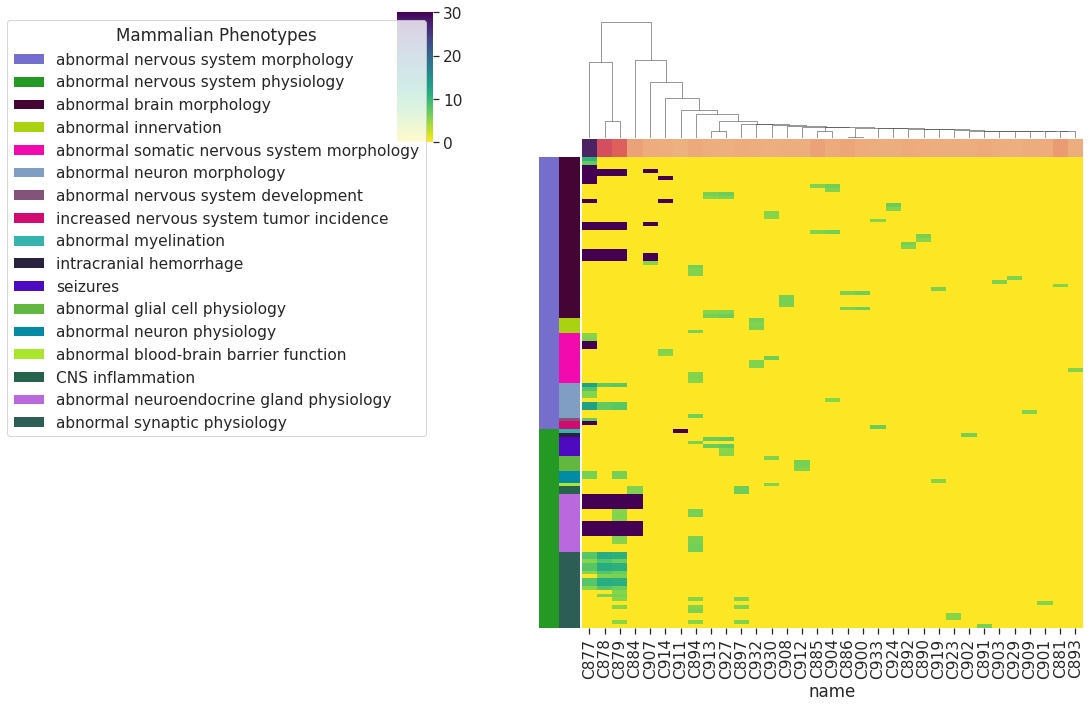

In [264]:
plot_hierarchy_heatmap(new_results, MPO2, root="MP:0003631", levels=2)

# New^3 enrichment

In [88]:
phenotypes = []
term_counts, gene_mapping, x = genes_per_node(MPO2)
for community in tqdm(hier_df_genes.index):
    x = community_term_enrichment_or(community, hier_df_genes, MPO2, mgi_df, term_counts, gene_mapping)
    x = x.assign(name=community)
    phenotypes.append(x)

 18%|█▊        | 11/61 [00:04<00:08,  5.75it/s]

0/6 in MPO.genes


 80%|████████  | 49/61 [00:15<00:01, 11.39it/s]

0/6 in MPO.genes


100%|██████████| 61/61 [00:17<00:00,  3.41it/s]

0/4 in MPO.genes


/tmp/ipykernel_684817/3942392742.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_subset["parent"] = results_subset.MP.apply(lambda x: parent_map.loc[x].parent if x not in parents else x)
/cellar/users/snwright/anaconda3/envs/netcoloc_R/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


handles 28


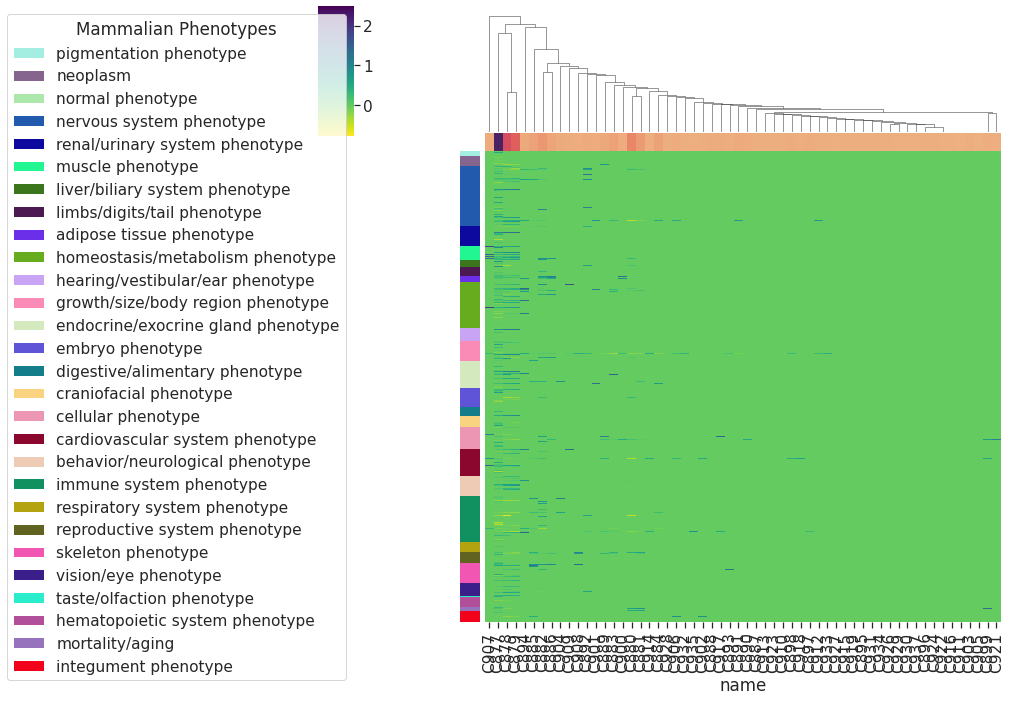

In [119]:
root="MP:0000001"
results["log10_OR"] = np.log10(results.OR)
a, mpG, colors, parent_map = plot_hierarchy_heatmap(results, MPO2, term_counts, value="log10_OR", min_observation=2, min_percent=0.1)

In [118]:
plot_sum_of_nodes(a, mpG, root, colors, MPO2, parent_map, cutoff=0.01)

NameError: name 'root' is not defined

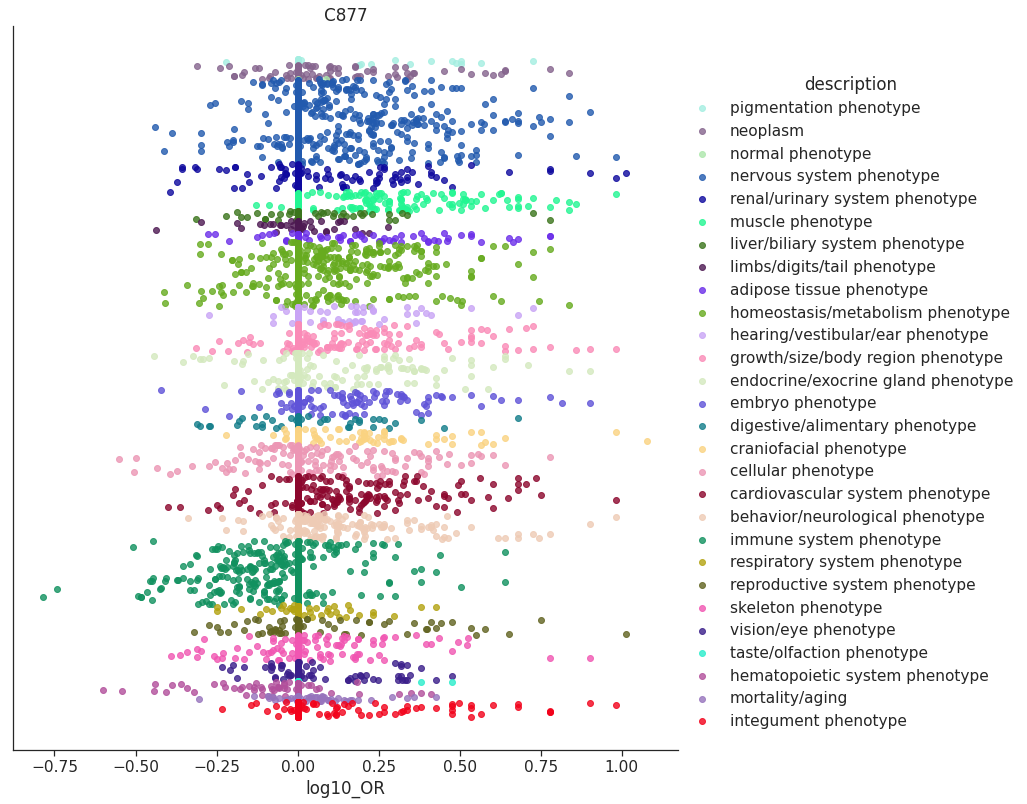

In [128]:
%matplotlib inline
plot_specific_community(a, mpG, "C877", root, colors, MPO2, parent_map, value="log10_OR")

In [583]:
a = a.sort_values(by="hyper_p")

In [585]:
a.loc[(a.observed > 3) & a.name=="C891"]

Empty DataFrame
Columns: [observed, total, hyper_p, sig_5e6, description, size, name, MP, log10P, percent, parent]
Index: []

In [597]:
a.loc[a.name=="C900"].sort_values(by="observed", ascending=False).head(20)

observed   total   hyper_p sig_5e6  \
MP:0009406       6.0    23.0  0.000028   False   
MP:0003393       7.0    31.0  0.000029   False   
MP:0004476       3.0     6.0  0.000042   False   
MP:0003633     108.0  1862.0  0.000049   False   
MP:0020136       9.0    56.0  0.000090   False   
MP:0002996       3.0     7.0  0.000094   False   
MP:0011457       3.0     7.0  0.000094   False   
MP:0009399       7.0    38.0  0.000138   False   
MP:0005075       8.0    52.0  0.000259   False   
MP:0001261      12.0   101.0  0.000272   False   
MP:0011087      41.0   585.0  0.000346   False   
MP:0002899      10.0    78.0  0.000360   False   
MP:0002877      10.0    78.0  0.000360   False   
MP:0012106       9.0    67.0  0.000417   False   
MP:0011698       5.0    25.0  0.000456   False   
MP:0004395       4.0    17.0  0.000502   False   
MP:0001934       4.0    17.0  0.000502   False   
MP:0003923       4.0    17.0  0.000502   False   
MP:0005661       3.0    10.0  0.000512   False   
MP:0003851       3.0    10.0  0.000512   False   
MP:0000275       3.0    10.0  0.000512   False   
MP:0001627       7.0    46.0  0.000550   False   
MP:0008947      10.0    83.0  0.000620   False   
MP:0020135      15.0   153.0  0.000623   False   
MP:0009907       4.0    18.0  0.000671   False   
MP:0009607       2.0     5.0  0.000676   False   
MP:0012024       2.0     5.0  0.000676   False   
MP:0030761       2.0     5.0  0.000676   False   
MP:0009673       2.0     5.0  0.000676   False   
MP:0012688       2.0     5.0  0.000676   False   

                                              description  size  name  \
MP:0009406         decreased skeletal muscle fiber number   356  C877   
MP:0003393                       decreased cardiac output   356  C877   
MP:0004476                           absent palatine bone   356  C877   
MP:0003633             abnormal nervous system physiology   356  C877   
MP:0020136     abnormal interventricular septum thickness   356  C877   
MP:0002996                                      ovotestis   356  C877   
MP:0011457  abnormal metanephric ureteric bud development   356  C877   
MP:0009399           increased skeletal muscle fiber size   356  C877   
MP:0005075                 abnormal melanosome morphology   356  C877   
MP:0001261                                          obese   356  C877   
MP:0011087        neonatal lethality, complete penetrance   356  C877   
MP:0002899                                        fatigue   356  C877   
MP:0002877                 abnormal melanocyte morphology   356  C877   
MP:0012106                    impaired exercise endurance   356  C877   
MP:0011698       abnormal brown adipose tissue physiology   356  C877   
MP:0004395      increased cochlear inner hair cell number   356  C877   
MP:0001934                          increased litter size   356  C877   
MP:0003923          abnormal heart left atrium morphology   356  C877   
MP:0005661         decreased circulating adrenaline level   356  C877   
MP:0003851          skeletal muscle interstitial fibrosis   356  C877   
MP:0000275                              heart hyperplasia   356  C877   
MP:0001627                        abnormal cardiac output   356  C877   
MP:0008947                        increased neuron number   356  C877   
MP:0020135        abnormal heart ventricle wall thickness   356  C877   
MP:0009907                          decreased tongue size   356  C877   
MP:0009607            decreased keratohyalin granule size   356  C877   
MP:0012024                 abnormal nephron morphogenesis   356  C877   
MP:0030761                     increased adrenaline level   356  C877   
MP:0009673                         increased birth weight   356  C877   
MP:0012688               abnormal heart ventricles weight   356  C877   

                    MP    log10P   percent      parent  
MP:0009406  MP:0009406  4.545619  0.260870  MP:0005369  
MP:0003393  MP:0003393  4.541127  0.225806  MP:0005385  
MP:0004476  MP:0004476  4.

### Growth/size

/tmp/ipykernel_2776219/1036151052.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_subset["parent"] = results_subset.MP.apply(lambda x: parent_map.loc[x].parent if x not in parents else x)
/tmp/ipykernel_2776219/1036151052.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_subset["sub_parent"] = results_subset.MP.apply(lambda x: parent_map.loc[x].parent2)
/cellar/users/snwright/anaconda3/envs/netcoloc_R/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large 

handles 12


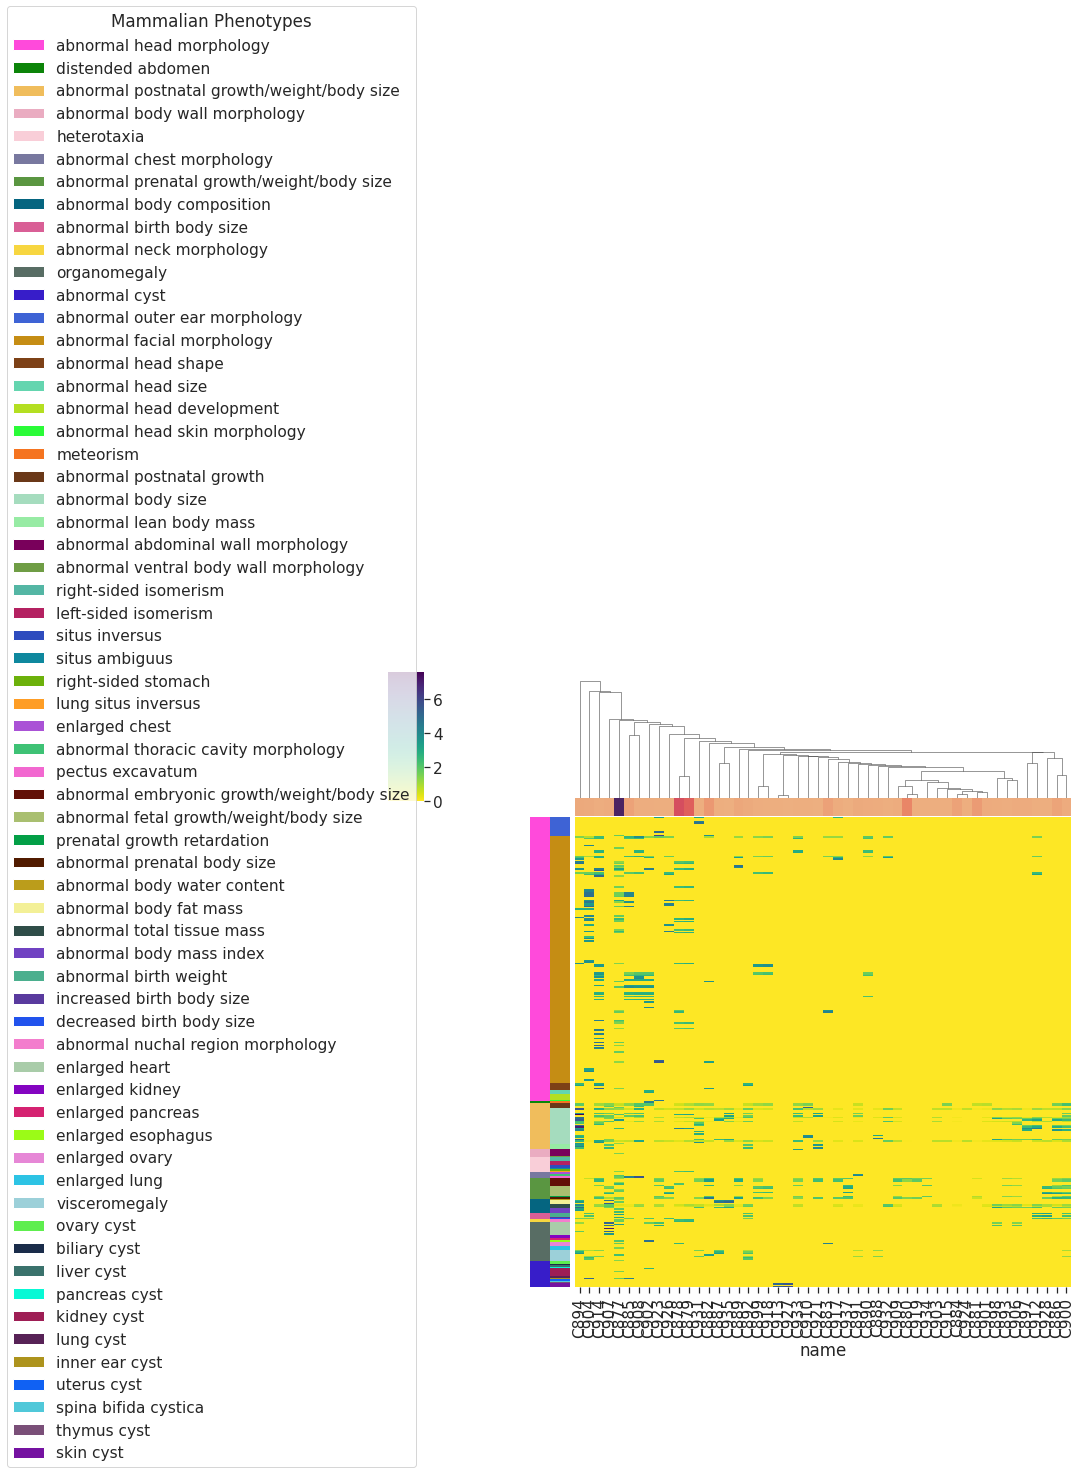

In [566]:
_ = plot_hierarchy_heatmap(results, MPO2, term_counts, root="MP:0005378", levels=2, min_observation=4, min_percent=0.1)

### Nervous system

/tmp/ipykernel_2776219/287899058.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_subset["parent"] = results_subset.MP.apply(lambda x: parent_map.loc[x].parent if x not in parents else x)
/tmp/ipykernel_2776219/287899058.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_subset["sub_parent"] = results_subset.MP.apply(lambda x: parent_map.loc[x].parent2)
/cellar/users/snwright/anaconda3/envs/netcoloc_R/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large ma

handles 2


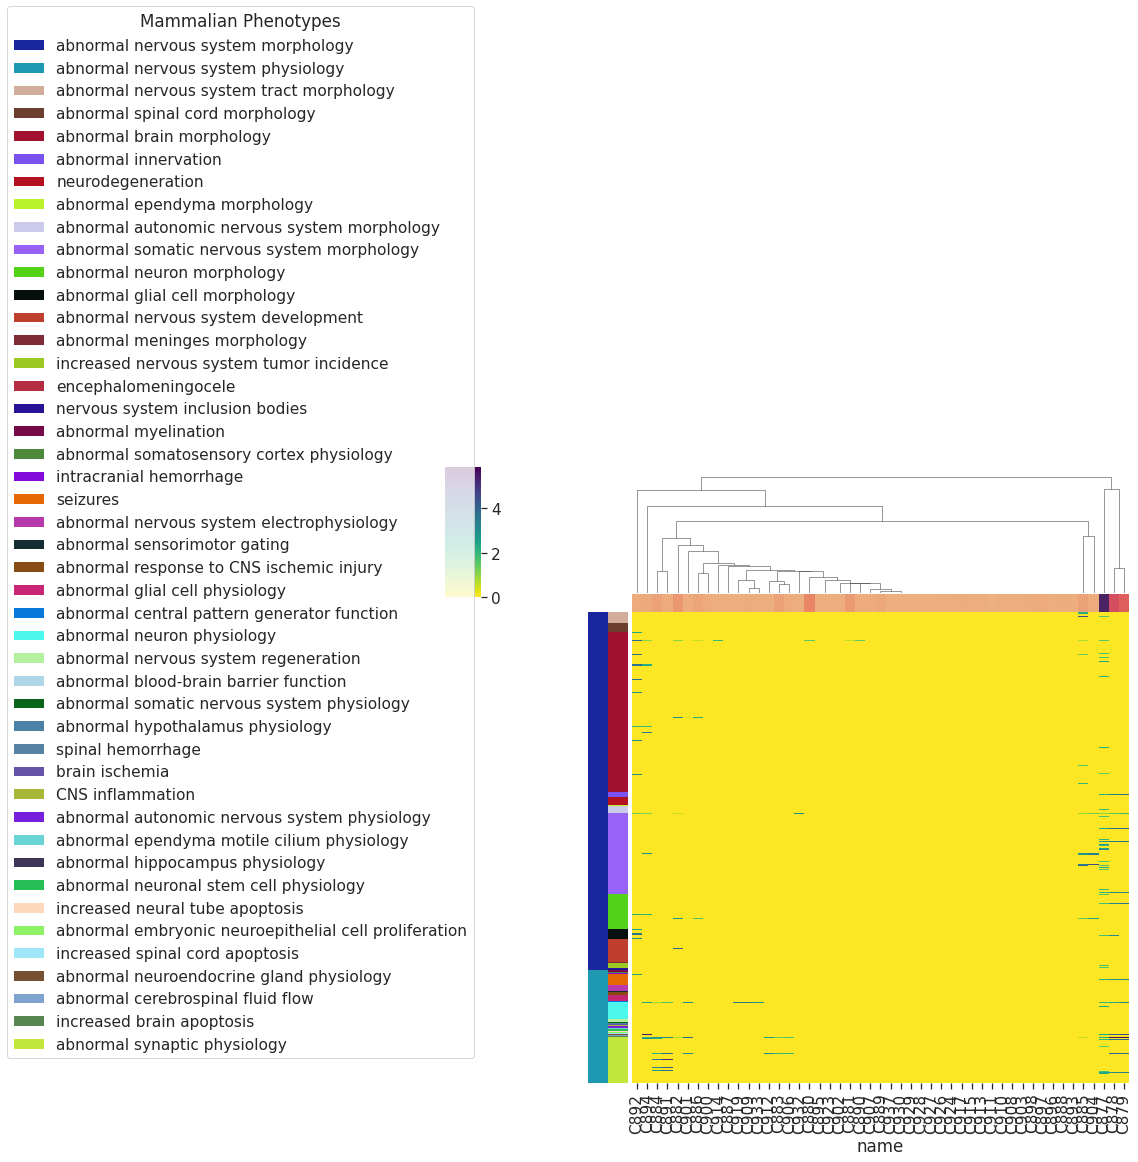

In [580]:
_ = plot_hierarchy_heatmap(results, MPO2, term_counts, root="MP:0003631", levels=2, min_observation=2, min_percent=0.1)

### Endo/exocrine

/tmp/ipykernel_2776219/287899058.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_subset["parent"] = results_subset.MP.apply(lambda x: parent_map.loc[x].parent if x not in parents else x)
/tmp/ipykernel_2776219/287899058.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_subset["sub_parent"] = results_subset.MP.apply(lambda x: parent_map.loc[x].parent2)
/cellar/users/snwright/anaconda3/envs/netcoloc_R/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large ma

handles 2


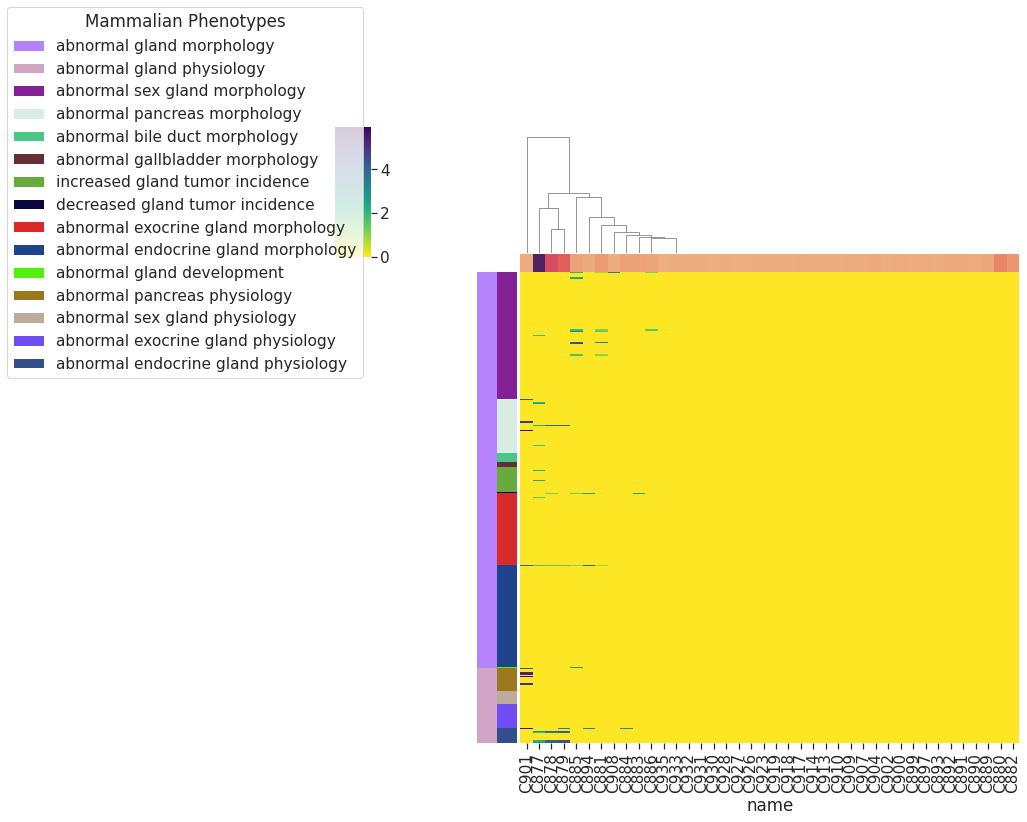

In [578]:
a = plot_hierarchy_heatmap(results, MPO2, term_counts, root="MP:0005379", levels=2, min_observation=3, min_percent=0.1)

In [574]:
a.loc[a.name == "C901"]

observed  total       hyper_p sig_5e6  \
MP:0001944       3.0  278.0  3.569810e-05   False   
MP:0005217       3.0  126.0  1.532437e-06    True   
MP:0009165       3.0  200.0  9.696642e-06   False   
MP:0005215       3.0  199.0  9.505429e-06   False   
MP:0009170       2.0   96.0  4.673408e-05   False   
MP:0020578       2.0   59.0  1.077326e-05   False   
MP:0003339       2.0   46.0  5.053681e-06   False   
MP:0009172       1.0   45.0  5.614703e-04   False   
MP:0009171       1.0   55.0  8.389148e-04   False   
MP:0005216       1.0   44.0  5.367261e-04   False   
MP:0030587       1.0    7.0  1.208831e-05   False   
MP:0009176       1.0   18.0  8.769407e-05   False   
MP:0011932       1.0   21.0  1.202233e-04   False   
MP:0005491       1.0   39.0  4.212400e-04   False   
MP:0020577       1.0   32.0  2.827369e-04   False   
MP:0020579       1.0   11.0  3.161040e-05   False   
MP:0030589       1.0    5.0  5.760839e-06   False   
MP:0009179       1.0    5.0  5.760839e-06   False   
MP:0005218       1.0   14.0  5.223955e-05   False   
MP:0003934       1.0   38.0  3.997943e-04   False   
MP:0009175       1.0   14.0  5.223955e-05   False   
MP:0009043       1.0    8.0  1.611145e-05   False   
MP:0010288       1.0  204.0  1.103260e-02   False   
MP:0009153       1.0   24.0  1.578225e-04   False   
MP:0003430       1.0    6.0  8.637883e-06   False   
MP:0009151       1.0    7.0  1.208831e-05   False   
MP:0013560       4.0  786.0  1.174024e-04   False   
MP:0000639       1.0   94.0  2.431841e-03   False   
MP:0008504       1.0   12.0  3.791766e-05   False   
MP:0010913       1.0   20.0  1.088160e-04   False   
MP:0000631       1.0  126.0  4.326651e-03   False   
MP:0008289       1.0   19.0  9.797271e-05   False   
MP:0020973       1.0  238.0  1.482719e-02   False   
MP:0002694       3.0  173.0  5.444757e-06   False   
MP:0002693       3.0  277.0  3.519460e-05   False   
MP:0003562       3.0  184.0  6.960062e-06   False   
MP:0003059       3.0  120.0  1.259830e-06    True   
MP:0014195       3.0  163.0  4.293850e-06    True   
MP:0010147       3.0  189.0  7.743685e-06   False   
MP:0003564       3.0  160.0  3.986978e-06    True   
MP:0003565       2.0   18.0  2.743543e-07    True   
MP:0003563       2.0   18.0  2.743543e-07    True   
MP:0002710       1.0    7.0  1.208831e-05   False   
MP:0002711       1.0   10.0  2.587317e-05   False   
MP:0013561       4.0  355.0  2.374719e-06    True   
MP:0002909       2.0   31.0  1.504398e-06    True   
MP:0001739       2.0   22.0  5.170478e-07    True   
MP:0001746       1.0   15.0  6.025284e-05   False   
MP:0013570       1.0   30.0  2.481589e-04   False   
MP:0005646       1.0   27.0  2.004737e-04   False   

                                                  description  size  name  \
MP:0001944                       abnormal pancreas morphology     7  C901   
MP:0005217           abnormal pancreatic beta cell morphology     7  C901   
MP:0009165             abnormal endocrine pancreas morphology     7  C901   
MP:0005215               abnormal pancreatic islet morphology     7  C901   
MP:0009170                     abnormal pancreatic islet size     7  C901   
MP:0020578               abnormal pancreatic beta cell number     7  C901   
MP:0003339              decreased pancreatic beta cell number     7  C901   
MP:0009172                            small pancreatic islets     7  C901   
MP:0009171                         enlarged pancreatic islets     7  C901   
MP:0005216          abnormal pancreatic alpha cell morphology     7  C901   
MP:0030587                abnormal pancreatic alpha cell mass     7  C901   
MP:0009176             increased pancreatic alpha cell number     7  C901   
MP:0011932            abnormal endocrine pancreas development     7  C901   
MP:0005491                       pancreatic islet hyperplasia     7  C901   
MP:0020577              abnormal pancreatic alpha cell number     7  C901   
MP:0020579              abnormal pancreatic delta cell number     7  C901   

### Behavior

/tmp/ipykernel_2776219/1036151052.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_subset["parent"] = results_subset.MP.apply(lambda x: parent_map.loc[x].parent if x not in parents else x)
/tmp/ipykernel_2776219/1036151052.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_subset["sub_parent"] = results_subset.MP.apply(lambda x: parent_map.loc[x].parent2)
/cellar/users/snwright/anaconda3/envs/netcoloc_R/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large 

handles 1


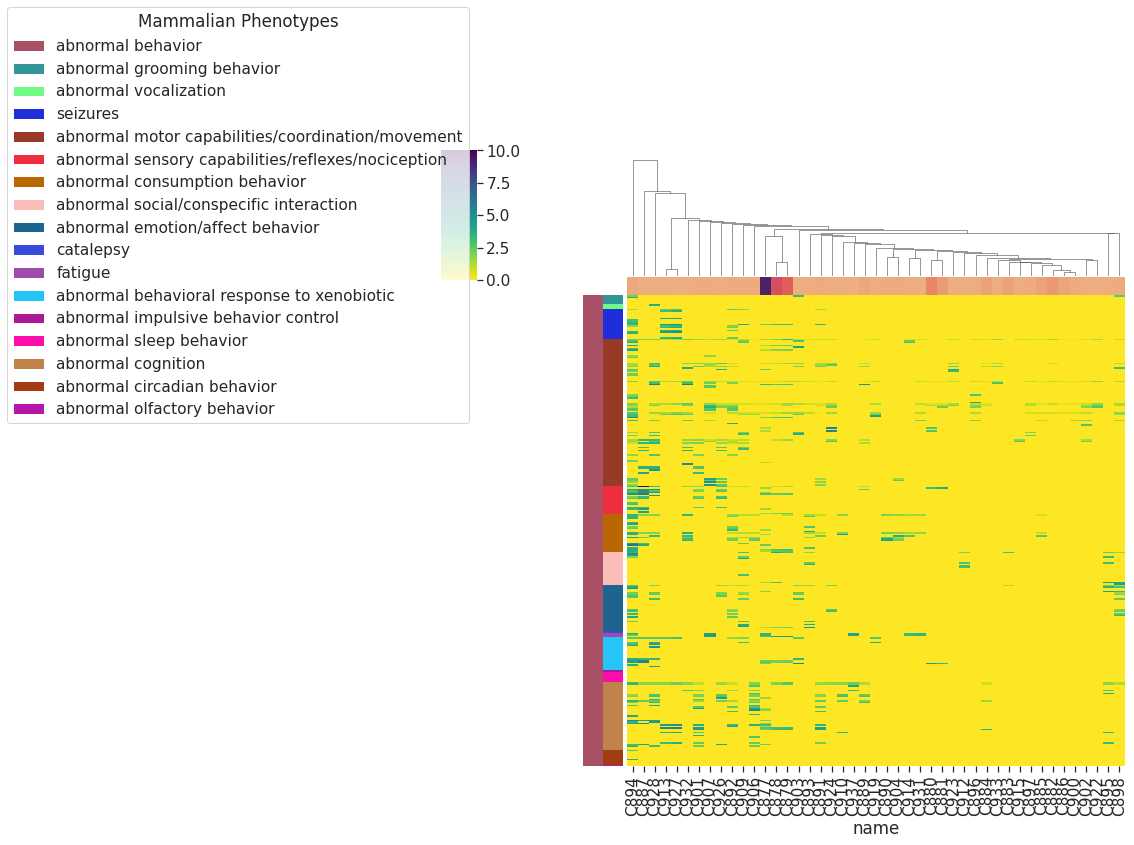

In [569]:
_ = plot_hierarchy_heatmap(results, MPO2, term_counts, root="MP:0005386", levels=2, min_observation=4, min_percent=0.1)

### Skeleton

/tmp/ipykernel_2776219/1036151052.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_subset["parent"] = results_subset.MP.apply(lambda x: parent_map.loc[x].parent if x not in parents else x)
/tmp/ipykernel_2776219/1036151052.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_subset["sub_parent"] = results_subset.MP.apply(lambda x: parent_map.loc[x].parent2)
/cellar/users/snwright/anaconda3/envs/netcoloc_R/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large 

handles 2


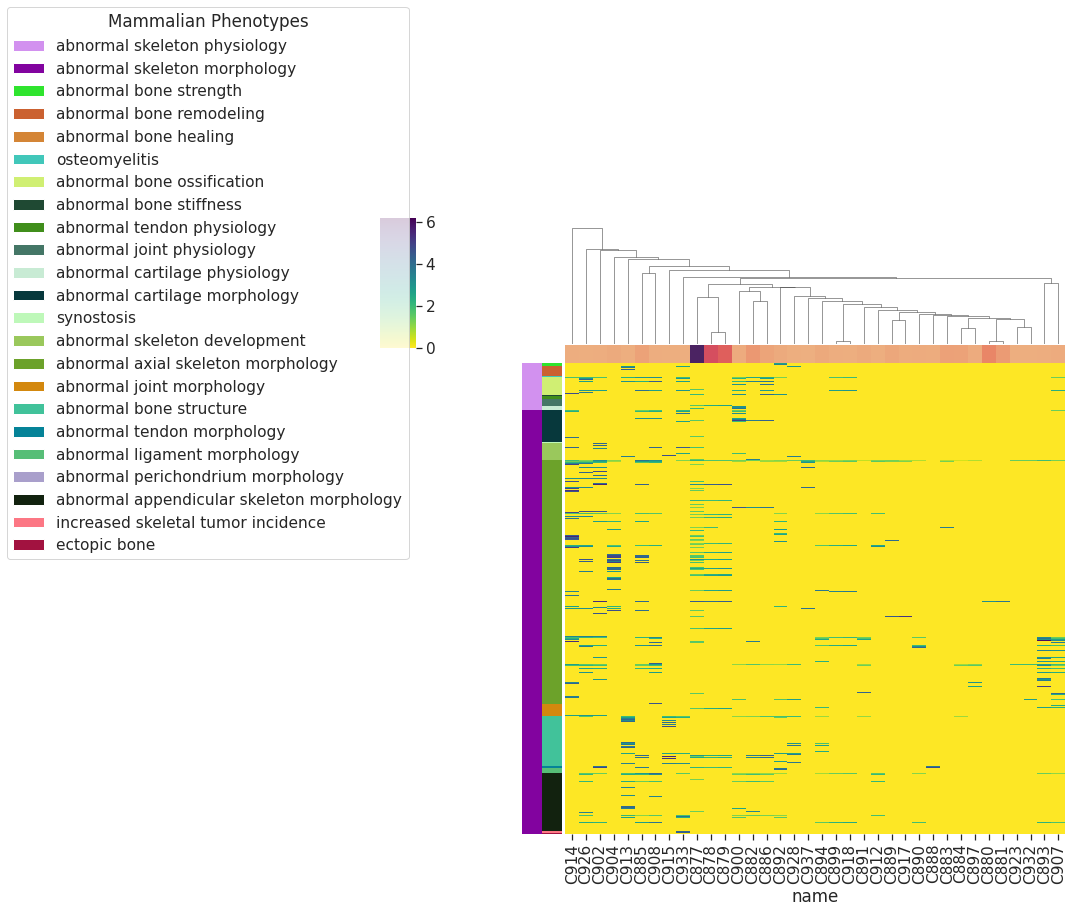

In [570]:
_ = plot_hierarchy_heatmap(results, MPO2, term_counts, root="MP:0005390", levels=2, min_observation=4, min_percent=0.1)

/tmp/ipykernel_2776219/287899058.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_subset["parent"] = results_subset.MP.apply(lambda x: parent_map.loc[x].parent if x not in parents else x)
/tmp/ipykernel_2776219/287899058.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_subset["sub_parent"] = results_subset.MP.apply(lambda x: parent_map.loc[x].parent2)


handles 2


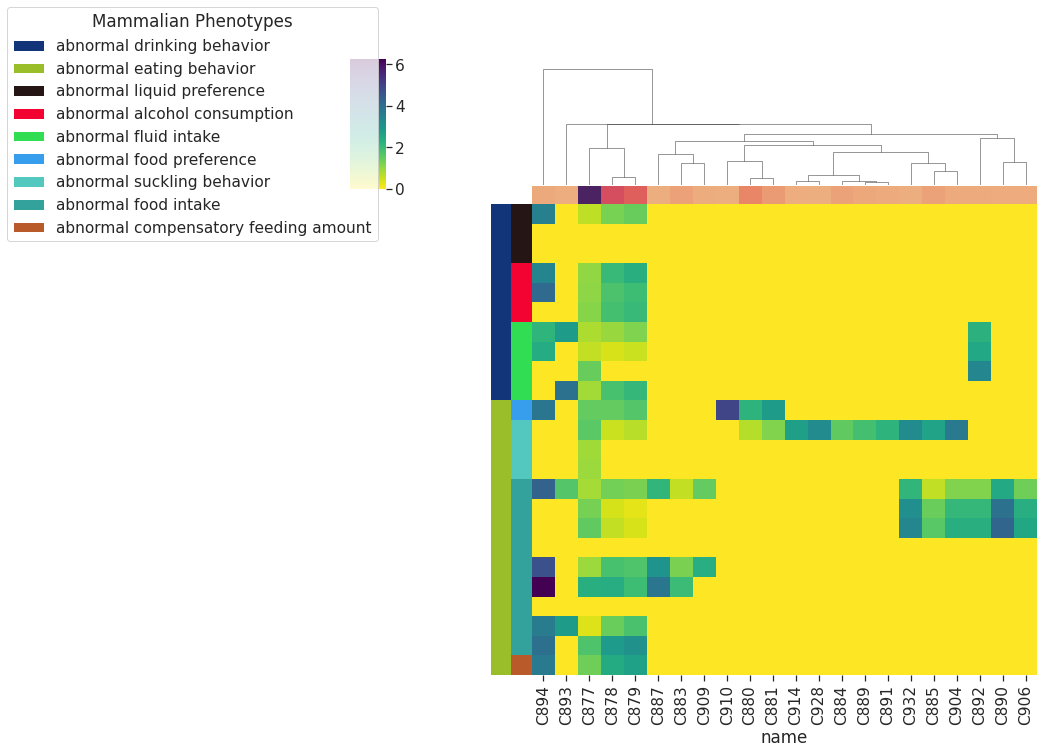

In [603]:
_ = plot_hierarchy_heatmap(results, MPO2, term_counts, root="MP:0002069", levels=2)

In [442]:
len([t for t in term_counts.keys() if term_counts[t] >= 5])

6972